# GANS/Cyclic GANS For Data Augmentation and Neural Style Transfer

In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import random
import itertools
import math
import time
import wandb

from wandb.keras import WandbCallback
from skimage.io import imread
from skimage.transform import resize

# Model class
from tensorflow.keras.models import Model

# Layers
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout, Flatten, Conv2D, Dense, MaxPool2D, Conv2DTranspose, GlobalMaxPool2D, Reshape, BatchNormalization, Input
from tensorflow.keras.layers import Layer

# Optimizer
from tensorflow.keras.optimizers import Adam

# Loss function
from tensorflow.keras.losses import BinaryCrossentropy

# Data loader
from tensorflow.keras.utils import Sequence

# Metrics
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, MSE

# ImageLoader
from skimage.io import imread

# Weights Initializer
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, GlorotUniform

# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

## Getting The Data

In [2]:
def split_data(data_dir, split):
    
    dirs = split.keys()
    # get existing folders names 
    subdirs = [x for x in os.listdir(data_dir) if x not in dirs]
    
    # filling dataset structure
    dataset_dir_structure = {}
    
    for dir_ in dirs:
        dataset_dir_structure[dir_] = subdirs
        
    for key, val in dataset_dir_structure.items():
        if isinstance(val, list):
            for sub_key in val:
                Path(Path(data_dir) / key /
                     sub_key).mkdir(exist_ok=True, parents=True)
    
    cat_images = glob.glob(f"{data_dir}/Cat/*.jpg")
    dog_images = glob.glob(f"{data_dir}/Dog/*.jpg")
    
    assert sum(list(split.values())) < (len(cat_images)+len(dog_images)), f"Split values should not excceed number of datapoints: {sum(list(split.values()))} > {(len(cat_images)+len(dog_images))}"
    
    for split_dir in split.keys():
        for i in range(int(split[split_dir]/2)):
            cat_im = np.random.choice(cat_images)
            shutil.copy(cat_im, f"{data_dir}/{split_dir}/Cat/{i}.jpg")
            cat_images.remove(cat_im)
        
            dog_im = np.random.choice(dog_images)
            shutil.copy(dog_im, f"{data_dir}/{split_dir}/Dog/{i}.jpg")
            dog_images.remove(dog_im)

In [ ]:
split_data("PetImages", {"train": 2500, "test": 500})

## Pre-Processing The Data

In [3]:
# create a dataloader iterator that loads data from directory
# batch data
# resize to all the same size
# split train test
# normalize (min-max)

In [4]:
class DataLoader(Sequence):
    
    def __init__(self, im_dir, labels= None, batch_size= 32, resize= False, output_dim= None, classification= True, shuffle= True):
        
        self.im_dir = im_dir
        self.classification = classification
        self.shuffle = shuffle
        self.resize = resize
        self.output_dim = output_dim
        self.batch_size = batch_size
        
        self.labels = {}
        if isinstance(labels, list):
            for i, label in enumerate(labels):
                self.labels[label] = i
        elif isinstance(labels, dict):
            self.labels = labels
        else:
            for root_dir, subdirs, files in os.walk(self.im_dir):
                for i, subdir in enumerate(subdirs):
                    self.labels[subdir] = i
        
            
        self.images = glob.glob(f"{self.im_dir}/*/*")
        random.shuffle(self.images)
        
        self.on_epoch_end()
        
    
    def __len__(self):
        return int(np.floor(len(self.images)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        im_files_batch = [self.images[idx] for idx in indexes]
        if self.resize:
            batch_images = np.array([resize(imread(file), self.output_dim, preserve_range= True) for file in im_files_batch], dtype= np.uint8)
            batch_images = (np.asanyarray(batch_images, dtype= np.float32) - 127.5)/127.5
            #batch_images = np.asanyarray(batch_images, dtype= np.float32)/255.
            
        else:
            batch_images = np.arrary([imread(file) for file in im_files_batch], dtype= np.uint8)
        
        batch_labels = np.empty((self.batch_size), dtype= np.int8)
        for i, im in enumerate(im_files_batch):
            for label in self.labels.keys():
                if label in im:
                    batch_labels[i] = self.labels[label]
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        "Updates all indexes after the end of each epoch"
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        
    def add_data(self, batched_data):
        return

In [5]:
train_cat_dog_data = DataLoader(im_dir= "dataset/Newdata/Train", resize= True, output_dim= (200, 200, 3))
val_cat_dog_data = DataLoader(im_dir= "dataset/Newdata/Test", resize= True, output_dim= (200, 200, 3))

In [45]:
iter_data = iter(train_cat_dog_data)

In [48]:
predictions = next(iter_data)
predictions[0].shape

(16, 128, 128, 3)

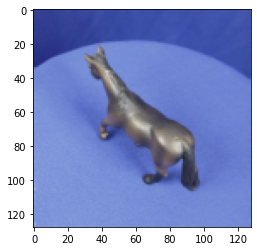

In [50]:
plt.imshow(np.asarray(predictions[0][0, :, :, :] * 127.5 + 127.5, dtype= np.uint8))

Show a bit more of the data

## Define Metrics For Classification
- Accuracy
- Precision
- Recall

In [6]:
def show_metrics_classification(model_history):
    metrics = ["_".join(metric.split("_")[1:]) for metric in model_history.history.keys() if "val" not in metric]
    print(metrics)
    colors = list(itertools.combinations(['b', 'g', 'r', 'c', 'm', 'y', 'k'], 2))
    
    f = plt.figure()
    f.set_figwidth(2.5*len(metrics))
    f.set_figheight(3*len(metrics))
    for i, metric in enumerate(metrics):
        plt.subplot(math.ceil(len(metrics)/2), 2, i+1)
        color_plts = np.random.randint(0, len(colors))
        plt.plot(model_history.history[f"train_{metric}"], color= colors[color_plts][0])
        plt.plot(model_history.history[f"val_{metric}"], color= colors[color_plts][1])
        plt.ylabel(metric)
        plt.xlabel("epochs")
        plt.legend(["train", "val"], loc= "upper left")
        plt.title(f"{metric.title()} vs Epochs")
    plt.show()
    

## Building The Classifier

In [7]:
class Classifier(Model):
    
    def __init__(self, name):
        super(Classifier, self).__init__(name= name)
        
    def build(self, input_shape):
        
        self.conv1 = Conv2D(filters= 50, kernel_size= 3, activation= 'relu', padding= 'same', kernel_initializer= 'glorot_uniform', input_shape= input_shape)
        self.maxpool1 = MaxPool2D(pool_size= (2, 2))
        
        self.conv2 = Conv2D(filters= 20, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool2 = MaxPool2D(pool_size= (2, 2))
        
        self.conv3 = Conv2D(filters= 5, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool3 = MaxPool2D(pool_size= (2, 2))
        
        self.flatten = Flatten()
        self.dense1 = Dense(units= 30, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense2 = Dense(units= 20, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense3 = Dense(units= 1, activation= 'sigmoid', kernel_initializer= 'glorot_uniform')
        
        super(Classifier, self).build(input_shape)
    
    def call(self, input_):
        x = self.conv1(input_)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
     
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        output = self.dense3(x)
        return output
    
    def train_step(self, train_batch):
        X_train, y_train = train_batch
        
        with tf.GradientTape() as tape:
            # apply forward pass
            y_pred = self(X_train, training= True)
            loss = self.compiled_loss(y_train, y_pred, regularization_losses= self.losses)
        # calculate gradients - uses reverse gradient autodiff
        gradients = tape.gradient(loss, self.trainable_variables)
        # backpropagate the gradients and update the weights using the compiled optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.compiled_metrics.update_state(y_train, y_pred)
        return {f"train_{metric.name}": metric.result() for metric in self.metrics}
    
    def test_step(self, test_batch):
        X_test, y_test = test_batch
        # obtain prediciton
        y_pred = self(X_test, training= False)
        
        # updates loss metric
        self.compiled_loss(y_test, y_pred)
        
        # updates metrics
        self.compiled_metrics.update_state(y_test, y_pred)
        
        return {f"{metric.name}": metric.result() for metric in self.metrics}

## Traning the Classifier

In [ ]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:0'):
    
    cats_dogs_classifier = Classifier(name= "cvd")
    cats_dogs_classifier.build(input_shape= (None, 200, 200, 3))

    cats_dogs_classifier.summary()
    cats_dogs_classifier.compile(optimizer= Adam(0.001), loss= BinaryCrossentropy(), metrics= [BinaryAccuracy(), Recall(), Precision(), MSE])
    model_data = cats_dogs_classifier.fit(train_cat_dog_data, validation_data= val_cat_dog_data, epochs= 50, workers= 10)

In [ ]:
show_metrics_classification(cats_dogs_classifier.history)

## DC-GAN

### Building The GAN Architecture
#### Generator

In [31]:
import tensorflow.keras as keras
from tensorflow.keras import layers

class Conv2DTBatchNorm(Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias):
        super(Conv2DTBatchNorm, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
    
    def build(self, input_shape):
        self.conv2d_t = Conv2DTranspose(filters= self.filters, kernel_size= self.kernel_size, strides= self.strides, use_bias= self.use_bias)
        self.batch_norm = BatchNormalization()
        self.leaky_relu = LeakyReLU()
        super(Conv2DTBatchNorm, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        
        x = self.conv2d_t(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        
        return x    

In [32]:
class Generator(Model):
    def __init__(self, latent_dim, name, **kwargs):
        super(Generator, self).__init__(name= name, **kwargs)
        self.latent_dim = latent_dim
    
    def build(self, input_shape):
        assert input_shape[1:] == (1, 1, self.latent_dim), f"input_shape should have shape (batch_size, 1, 1, latent_dimension), received: {input_shape}"
        self.conv2d_t_1 = Conv2DTBatchNorm(filters= 64*12, kernel_size= (4, 4), strides=(1, 1), padding="valid", use_bias= False)
        self.conv2d_t_2 = Conv2DTBatchNorm(filters= 64*8, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_3 = Conv2DTBatchNorm(filters= 64*8, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_4 = Conv2DTBatchNorm(filters= 64*4, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_5 = Conv2DTBatchNorm(filters= 64*4, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_6 = Conv2DTBatchNorm(filters= 64*2, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        
        self.conv2d = Conv2D(filters= 3, kernel_size= (3, 3), strides=(1, 1), padding="same", use_bias= False, activation= "tanh")
        super(Generator, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv2d_t_1(x)
        x = self.conv2d_t_2(x)
        x = self.conv2d_t_3(x)
        x = self.conv2d_t_4(x)
        x = self.conv2d_t_5(x)
        x = self.conv2d_t_6(x)
        
        x = self.conv2d(x)
        return x

#### Discriminator

In [33]:
class Conv2DBatchNorm(Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias, batch_norm= True):
        super(Conv2DBatchNorm, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        
    def build(self, input_shape):
        self.conv = Conv2D(filters= self.filters, kernel_size= self.kernel_size, strides= self.strides, padding= self.padding, use_bias= self.use_bias)
        if self.batch_norm:
            self.bn = BatchNormalization()
        self.leaky_relu = LeakyReLU(alpha= 0.2)
        
        super(Conv2DBatchNorm, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.leaky_relu(x)
        
        return x

In [34]:
class Discriminator(Model):
    def __init__(self, name, **kwargs):
        super(Discriminator, self).__init__(name, **kwargs)
    
    def build(self, input_shape):
        self.conv1 = Conv2DBatchNorm(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        
        self.conv_bn_1 = Conv2DBatchNorm(filters=64*2, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        self.conv_bn_2 = Conv2DBatchNorm(filters=64*4, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_3 = Conv2DBatchNorm(filters=64*8, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_4 = Conv2DBatchNorm(filters=64*8, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_5 = Conv2DBatchNorm(filters=64*4, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_6 = Conv2DBatchNorm(filters=64*2, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        self.conv_bn_7 = Conv2DBatchNorm(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)  
        
        self.conv2 = Conv2D(1, (3, 3), strides=(4, 4), padding="same", use_bias= False, activation= 'sigmoid')
        super(Discriminator, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv1(x)
        
        x = self.conv_bn_1(x)
        x = self.conv_bn_2(x)
        x = self.conv_bn_3(x)
        x = self.conv_bn_4(x)
        x = self.conv_bn_5(x)        
        x = self.conv_bn_6(x)
        x = self.conv_bn_7(x)
        
        x = self.conv2(x)
        return x

#### GAN

In [35]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def call(self, data, training=False): 
        # Method needed to be implemented for tensorflow reasons when using a custom data loader
        pass
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = self.batch_size
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))
        
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1, 1, 1)), tf.zeros((batch_size, 1, 1, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1, 1, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

**Callbacks**

In [39]:
import datetime
class SaveImagesCallback(Callback):
    def __init__(self, logdir, latent_dim, save_freq):
        self.logdir = Path(f"{logdir}/gan_image_output/{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
        self.latent_dim = latent_dim
        self.save_freq = save_freq
        
        self.logdir.mkdir(exist_ok=True, parents=True)
        self.fixed_noise = tf.random.normal([batch_size, 1, 1, self.latent_dim])
        
    def on_epoch_end(self, epoch, logs= None):
        if epoch % self.save_freq == 0:
            generator = self.model.generator
            predictions = generator(self.fixed_noise, training=False)
            
            pred_index = np.random.choice(np.array(list(range(predictions.shape[0]))), size= predictions.shape[0])
            predictions = np.array([predictions[x, :, :, :] for x in pred_index])
            plt_shape = int(np.math.sqrt(predictions.shape[0]))
            
            fig = plt.figure(figsize=(8, 8))
            for i in range(predictions.shape[0]):
                plt.subplot(plt_shape, plt_shape, i+1)
                plt.imshow(np.asarray(predictions[i, :, :, :] * 127.5 + 127.5, dtype= np.uint8))
                plt.axis('off')
            plt.show()
            plt.savefig(f'{str(self.logdir)}/tf_image_at_epoch_{epoch:04d}.png')

Epoch 1/30000
10/10 [==============================] - ETA: 0s - d_loss: 0.6798 - g_loss: 0.6923

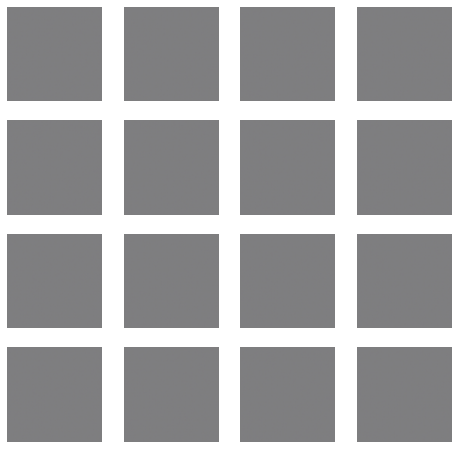

10/10 [==============================] - 2s 158ms/step - d_loss: 0.6759 - g_loss: 0.6920
Epoch 2/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.5159 - g_loss: 0.5923
Epoch 3/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.5608 - g_loss: 0.5813
Epoch 4/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.5906 - g_loss: 0.6130
Epoch 5/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.4044 - g_loss: 0.9810
Epoch 6/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.1641 - g_loss: 5.3907
Epoch 7/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.1024 - g_loss: 4.7261
Epoch 8/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.2691 - g_loss: 1.5437
Epoch 9/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.5114 - g_loss: 0.5898
Epoch 10/30000
10/10 [==============================] - 1s 58ms/step - d_loss: 0.4865 - g_loss:

10/10 [==============================] - 1s 59ms/step - d_loss: 0.4043 - g_loss: 0.6926
Epoch 81/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4069 - g_loss: 0.6954
Epoch 82/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4084 - g_loss: 0.6919
Epoch 83/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4088 - g_loss: 0.6920
Epoch 84/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4065 - g_loss: 0.6918
Epoch 85/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4078 - g_loss: 0.6935
Epoch 86/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4030 - g_loss: 0.6922
Epoch 87/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4036 - g_loss: 0.6943
Epoch 88/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4046 - g_loss: 0.6940
Epoch 89/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4030 - 

<Figure size 432x288 with 0 Axes>

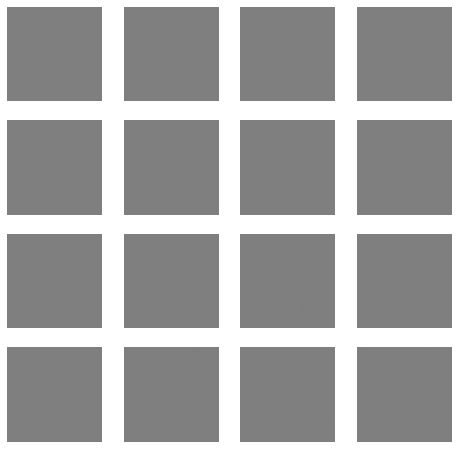

10/10 [==============================] - 2s 164ms/step - d_loss: 0.4060 - g_loss: 0.6916
Epoch 102/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4067 - g_loss: 0.6917
Epoch 103/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4071 - g_loss: 0.6910
Epoch 104/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4106 - g_loss: 0.6914
Epoch 105/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4061 - g_loss: 0.6917
Epoch 106/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4093 - g_loss: 0.6915
Epoch 107/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4118 - g_loss: 0.6912
Epoch 108/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4100 - g_loss: 0.6917
Epoch 109/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4052 - g_loss: 0.6924
Epoch 110/30000
10/10 [==============================] - 1s 59ms/step - d_loss:

10/10 [==============================] - 1s 59ms/step - d_loss: 0.4047 - g_loss: 0.6975
Epoch 180/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4080 - g_loss: 0.6966
Epoch 181/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4045 - g_loss: 0.6930
Epoch 182/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4041 - g_loss: 0.7009
Epoch 183/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4097 - g_loss: 0.6949
Epoch 184/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4062 - g_loss: 0.6985
Epoch 185/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4074 - g_loss: 0.6944
Epoch 186/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4072 - g_loss: 0.6943
Epoch 187/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4098 - g_loss: 0.6975
Epoch 188/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 

<Figure size 432x288 with 0 Axes>

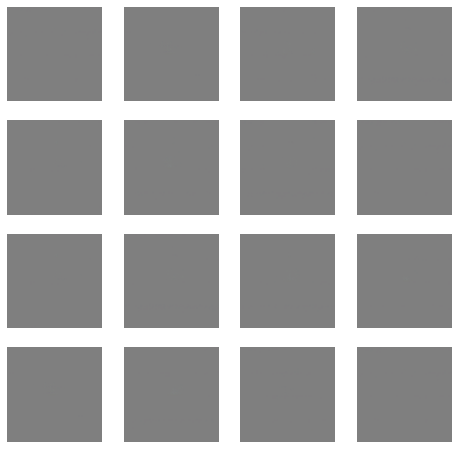

10/10 [==============================] - 2s 167ms/step - d_loss: 0.4069 - g_loss: 0.6923
Epoch 202/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4082 - g_loss: 0.6925
Epoch 203/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4030 - g_loss: 0.6936
Epoch 204/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4059 - g_loss: 0.6915
Epoch 205/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4064 - g_loss: 0.6926
Epoch 206/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4046 - g_loss: 0.6946
Epoch 207/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4114 - g_loss: 0.6951
Epoch 208/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4098 - g_loss: 0.6929
Epoch 209/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4077 - g_loss: 0.6926
Epoch 210/30000
10/10 [==============================] - 1s 59ms/step - d_loss:

10/10 [==============================] - 1s 60ms/step - d_loss: 0.3992 - g_loss: 0.7121
Epoch 280/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4063 - g_loss: 0.7066
Epoch 281/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4071 - g_loss: 0.7026
Epoch 282/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4083 - g_loss: 0.6979
Epoch 283/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4048 - g_loss: 0.6954
Epoch 284/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4036 - g_loss: 0.6971
Epoch 285/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4077 - g_loss: 0.6970
Epoch 286/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4051 - g_loss: 0.7108
Epoch 287/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4022 - g_loss: 0.7038
Epoch 288/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 

<Figure size 432x288 with 0 Axes>

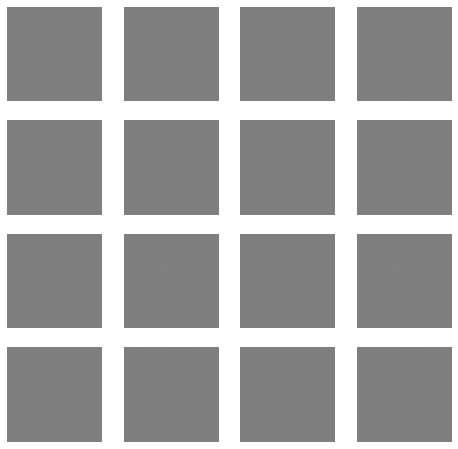

10/10 [==============================] - 2s 156ms/step - d_loss: 0.4109 - g_loss: 0.6918
Epoch 302/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4149 - g_loss: 0.6887
Epoch 303/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4079 - g_loss: 0.6871
Epoch 304/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4091 - g_loss: 0.6869
Epoch 305/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4122 - g_loss: 0.6878
Epoch 306/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4100 - g_loss: 0.6860
Epoch 307/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4090 - g_loss: 0.6858
Epoch 308/30000
10/10 [==============================] - 1s 59ms/step - d_loss: 0.4142 - g_loss: 0.6858
Epoch 309/30000
10/10 [==============================] - 1s 60ms/step - d_loss: 0.4098 - g_loss: 0.6849
Epoch 310/30000
10/10 [==============================] - 1s 60ms/step - d_loss:

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [44]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 16
EPOCHS= 30000
EPOCH_SAVE_FREQ = 30000
LATENT_DIMENSION = 100
IMAGE_SIZE = (128, 128, 3)

train_cat_dog_data = DataLoader(im_dir= "dataset/Newdata/train_merged", resize= True, output_dim= IMAGE_SIZE, batch_size= batch_size)
data_len = len(train_cat_dog_data)

logdir = 'gan-logdir/horses_cows/'
isaveimg = SaveImagesCallback(logdir= logdir, latent_dim= LATENT_DIMENSION, save_freq= 100)
model_checkpoint = ModelCheckpoint(
                    filepath= f"{logdir}/model_checkpoint/{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
                    monitor= "g_loss",
                    save_freq= data_len*EPOCH_SAVE_FREQ)

with tf.device('/device:GPU:0'):
    discriminator = Discriminator(name= "Discriminator")
    generator = Generator(latent_dim= LATENT_DIMENSION, name= "Generator")
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIMENSION, batch_size= batch_size)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
    
    optimizer_d = keras.optimizers.Adam(0.0002, 0.5)
    optimizer_g = keras.optimizers.Adam(0.0002, 0.5)

    gan.compile(
        #d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        #g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        d_optimizer= optimizer_d,
        g_optimizer= optimizer_g,
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    gan.fit(train_cat_dog_data, epochs=EPOCHS, callbacks= [isaveimg], workers= 16)

## GANS Metrics

## Conditional GAN

In [59]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

In [61]:
cgan = CGAN()
cgan.train(epochs=20000, batch_size=32, sample_interval=200)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

91 [D loss: 0.235739, acc.: 92.19%] [G loss: 5.818972]
92 [D loss: 0.062561, acc.: 96.88%] [G loss: 6.128877]
93 [D loss: 0.032486, acc.: 100.00%] [G loss: 6.738251]
94 [D loss: 0.058390, acc.: 96.88%] [G loss: 7.042803]
95 [D loss: 0.041335, acc.: 100.00%] [G loss: 7.389954]
96 [D loss: 0.126193, acc.: 95.31%] [G loss: 7.415787]
97 [D loss: 0.028655, acc.: 100.00%] [G loss: 7.672185]
98 [D loss: 0.031565, acc.: 100.00%] [G loss: 6.399418]
99 [D loss: 0.223476, acc.: 90.62%] [G loss: 7.384377]
100 [D loss: 0.066535, acc.: 96.88%] [G loss: 7.656827]
101 [D loss: 0.151148, acc.: 96.88%] [G loss: 6.839934]
102 [D loss: 0.062289, acc.: 98.44%] [G loss: 5.847848]
103 [D loss: 0.289736, acc.: 89.06%] [G loss: 7.651491]
104 [D loss: 0.117519, acc.: 95.31%] [G loss: 6.825115]
105 [D loss: 0.177496, acc.: 93.75%] [G loss: 6.368011]
106 [D loss: 0.069039, acc.: 98.44%] [G loss: 6.300670]
107 [D loss: 0.242090, acc.: 85.94%] [G loss: 7.680707]
108 [D loss: 0.297337, acc.: 89.06%] [G loss: 7.13387

241 [D loss: 0.424199, acc.: 79.69%] [G loss: 3.219738]
242 [D loss: 0.410004, acc.: 84.38%] [G loss: 3.376088]
243 [D loss: 0.319180, acc.: 87.50%] [G loss: 3.585911]
244 [D loss: 0.393862, acc.: 82.81%] [G loss: 3.066631]
245 [D loss: 0.391079, acc.: 89.06%] [G loss: 2.619067]
246 [D loss: 0.583816, acc.: 78.12%] [G loss: 2.862828]
247 [D loss: 0.246087, acc.: 89.06%] [G loss: 3.402267]
248 [D loss: 0.218955, acc.: 89.06%] [G loss: 3.402057]
249 [D loss: 0.342273, acc.: 87.50%] [G loss: 2.859223]
250 [D loss: 0.258931, acc.: 87.50%] [G loss: 3.155138]
251 [D loss: 0.227841, acc.: 90.62%] [G loss: 3.608529]
252 [D loss: 0.456075, acc.: 78.12%] [G loss: 3.130462]
253 [D loss: 0.217378, acc.: 92.19%] [G loss: 3.044135]
254 [D loss: 0.356471, acc.: 81.25%] [G loss: 3.646144]
255 [D loss: 0.266809, acc.: 92.19%] [G loss: 3.308114]
256 [D loss: 0.336228, acc.: 84.38%] [G loss: 3.047464]
257 [D loss: 0.308442, acc.: 85.94%] [G loss: 3.008865]
258 [D loss: 0.306375, acc.: 84.38%] [G loss: 3.

389 [D loss: 0.407568, acc.: 85.94%] [G loss: 1.971323]
390 [D loss: 0.501078, acc.: 76.56%] [G loss: 2.024232]
391 [D loss: 0.429366, acc.: 79.69%] [G loss: 2.013572]
392 [D loss: 0.498881, acc.: 75.00%] [G loss: 1.881518]
393 [D loss: 0.471318, acc.: 79.69%] [G loss: 1.623265]
394 [D loss: 0.502280, acc.: 73.44%] [G loss: 1.939869]
395 [D loss: 0.703933, acc.: 60.94%] [G loss: 2.188332]
396 [D loss: 0.314577, acc.: 93.75%] [G loss: 2.153385]
397 [D loss: 0.491423, acc.: 71.88%] [G loss: 1.827213]
398 [D loss: 0.660733, acc.: 67.19%] [G loss: 2.197175]
399 [D loss: 0.330303, acc.: 87.50%] [G loss: 2.088710]
400 [D loss: 0.517133, acc.: 65.62%] [G loss: 2.011971]
401 [D loss: 0.403552, acc.: 79.69%] [G loss: 1.876142]
402 [D loss: 0.549740, acc.: 75.00%] [G loss: 1.746303]
403 [D loss: 0.429538, acc.: 79.69%] [G loss: 1.962919]
404 [D loss: 0.558214, acc.: 67.19%] [G loss: 1.682557]
405 [D loss: 0.306941, acc.: 92.19%] [G loss: 1.865440]
406 [D loss: 0.419155, acc.: 79.69%] [G loss: 1.

537 [D loss: 0.727106, acc.: 54.69%] [G loss: 1.799648]
538 [D loss: 0.562321, acc.: 68.75%] [G loss: 1.912097]
539 [D loss: 0.596194, acc.: 67.19%] [G loss: 1.820181]
540 [D loss: 0.598186, acc.: 70.31%] [G loss: 1.741098]
541 [D loss: 0.414599, acc.: 85.94%] [G loss: 1.615401]
542 [D loss: 0.460218, acc.: 76.56%] [G loss: 1.510226]
543 [D loss: 0.457836, acc.: 81.25%] [G loss: 1.575179]
544 [D loss: 0.580668, acc.: 65.62%] [G loss: 1.629973]
545 [D loss: 0.474965, acc.: 75.00%] [G loss: 1.893225]
546 [D loss: 0.656044, acc.: 60.94%] [G loss: 1.848507]
547 [D loss: 0.474339, acc.: 79.69%] [G loss: 1.538012]
548 [D loss: 0.579076, acc.: 64.06%] [G loss: 1.549866]
549 [D loss: 0.521473, acc.: 67.19%] [G loss: 1.818434]
550 [D loss: 0.449412, acc.: 81.25%] [G loss: 1.851610]
551 [D loss: 0.471168, acc.: 75.00%] [G loss: 1.976007]
552 [D loss: 0.551696, acc.: 71.88%] [G loss: 1.865162]
553 [D loss: 0.577093, acc.: 71.88%] [G loss: 1.805336]
554 [D loss: 0.373965, acc.: 82.81%] [G loss: 1.

689 [D loss: 0.505086, acc.: 70.31%] [G loss: 1.571267]
690 [D loss: 0.653133, acc.: 67.19%] [G loss: 1.719451]
691 [D loss: 0.569769, acc.: 76.56%] [G loss: 1.432463]
692 [D loss: 0.461265, acc.: 82.81%] [G loss: 1.704165]
693 [D loss: 0.488490, acc.: 71.88%] [G loss: 1.533409]
694 [D loss: 0.391695, acc.: 84.38%] [G loss: 1.645417]
695 [D loss: 0.560893, acc.: 75.00%] [G loss: 1.586939]
696 [D loss: 0.434699, acc.: 87.50%] [G loss: 1.833370]
697 [D loss: 0.534337, acc.: 71.88%] [G loss: 1.648478]
698 [D loss: 0.474593, acc.: 78.12%] [G loss: 1.991431]
699 [D loss: 0.611479, acc.: 71.88%] [G loss: 1.702041]
700 [D loss: 0.464842, acc.: 75.00%] [G loss: 1.570565]
701 [D loss: 0.540036, acc.: 67.19%] [G loss: 1.910615]
702 [D loss: 0.475315, acc.: 81.25%] [G loss: 1.321098]
703 [D loss: 0.495263, acc.: 82.81%] [G loss: 2.007847]
704 [D loss: 0.440769, acc.: 84.38%] [G loss: 1.749075]
705 [D loss: 0.444358, acc.: 78.12%] [G loss: 1.680712]
706 [D loss: 0.551677, acc.: 75.00%] [G loss: 1.

838 [D loss: 0.502448, acc.: 79.69%] [G loss: 1.346563]
839 [D loss: 0.525073, acc.: 71.88%] [G loss: 1.539472]
840 [D loss: 0.486219, acc.: 81.25%] [G loss: 1.516150]
841 [D loss: 0.543164, acc.: 73.44%] [G loss: 1.686209]
842 [D loss: 0.612802, acc.: 65.62%] [G loss: 1.399041]
843 [D loss: 0.614878, acc.: 62.50%] [G loss: 1.740902]
844 [D loss: 0.507039, acc.: 75.00%] [G loss: 1.796485]
845 [D loss: 0.694884, acc.: 53.12%] [G loss: 1.685101]
846 [D loss: 0.582898, acc.: 68.75%] [G loss: 1.410319]
847 [D loss: 0.581981, acc.: 67.19%] [G loss: 1.319490]
848 [D loss: 0.508913, acc.: 75.00%] [G loss: 1.447331]
849 [D loss: 0.457835, acc.: 79.69%] [G loss: 1.442560]
850 [D loss: 0.499038, acc.: 71.88%] [G loss: 1.455453]
851 [D loss: 0.491852, acc.: 76.56%] [G loss: 1.400691]
852 [D loss: 0.569190, acc.: 71.88%] [G loss: 1.600091]
853 [D loss: 0.432885, acc.: 81.25%] [G loss: 1.715224]
854 [D loss: 0.613690, acc.: 70.31%] [G loss: 1.461322]
855 [D loss: 0.526580, acc.: 70.31%] [G loss: 1.

987 [D loss: 0.616197, acc.: 64.06%] [G loss: 1.397859]
988 [D loss: 0.506682, acc.: 78.12%] [G loss: 1.275026]
989 [D loss: 0.518745, acc.: 78.12%] [G loss: 1.254928]
990 [D loss: 0.454952, acc.: 81.25%] [G loss: 1.419799]
991 [D loss: 0.552583, acc.: 73.44%] [G loss: 1.483563]
992 [D loss: 0.588938, acc.: 70.31%] [G loss: 1.457636]
993 [D loss: 0.590549, acc.: 65.62%] [G loss: 1.416531]
994 [D loss: 0.495393, acc.: 73.44%] [G loss: 1.416335]
995 [D loss: 0.661860, acc.: 68.75%] [G loss: 1.532468]
996 [D loss: 0.529212, acc.: 76.56%] [G loss: 1.484128]
997 [D loss: 0.517732, acc.: 75.00%] [G loss: 1.327857]
998 [D loss: 0.546221, acc.: 70.31%] [G loss: 1.417703]
999 [D loss: 0.501213, acc.: 82.81%] [G loss: 1.351360]
1000 [D loss: 0.618671, acc.: 57.81%] [G loss: 1.414764]
1001 [D loss: 0.585046, acc.: 68.75%] [G loss: 1.299580]
1002 [D loss: 0.494014, acc.: 79.69%] [G loss: 1.542164]
1003 [D loss: 0.608056, acc.: 65.62%] [G loss: 1.473389]
1004 [D loss: 0.486608, acc.: 75.00%] [G los

1135 [D loss: 0.595043, acc.: 67.19%] [G loss: 1.082782]
1136 [D loss: 0.621218, acc.: 64.06%] [G loss: 1.148928]
1137 [D loss: 0.544576, acc.: 67.19%] [G loss: 1.337532]
1138 [D loss: 0.553085, acc.: 70.31%] [G loss: 1.223729]
1139 [D loss: 0.629031, acc.: 70.31%] [G loss: 1.215369]
1140 [D loss: 0.544055, acc.: 67.19%] [G loss: 1.289061]
1141 [D loss: 0.625099, acc.: 59.38%] [G loss: 1.401206]
1142 [D loss: 0.707375, acc.: 68.75%] [G loss: 1.174966]
1143 [D loss: 0.591987, acc.: 71.88%] [G loss: 1.150867]
1144 [D loss: 0.675720, acc.: 60.94%] [G loss: 1.261602]
1145 [D loss: 0.642659, acc.: 59.38%] [G loss: 1.357242]
1146 [D loss: 0.642742, acc.: 60.94%] [G loss: 1.296191]
1147 [D loss: 0.570194, acc.: 76.56%] [G loss: 1.235695]
1148 [D loss: 0.583942, acc.: 62.50%] [G loss: 1.389636]
1149 [D loss: 0.663982, acc.: 56.25%] [G loss: 1.119368]
1150 [D loss: 0.558598, acc.: 67.19%] [G loss: 1.100909]
1151 [D loss: 0.603929, acc.: 68.75%] [G loss: 1.237289]
1152 [D loss: 0.565357, acc.: 7

1280 [D loss: 0.606220, acc.: 65.62%] [G loss: 1.182256]
1281 [D loss: 0.664169, acc.: 62.50%] [G loss: 1.163693]
1282 [D loss: 0.652403, acc.: 60.94%] [G loss: 1.072114]
1283 [D loss: 0.648086, acc.: 64.06%] [G loss: 1.248900]
1284 [D loss: 0.557965, acc.: 68.75%] [G loss: 1.239244]
1285 [D loss: 0.660067, acc.: 60.94%] [G loss: 1.148934]
1286 [D loss: 0.600074, acc.: 70.31%] [G loss: 1.117093]
1287 [D loss: 0.598820, acc.: 68.75%] [G loss: 1.080824]
1288 [D loss: 0.689350, acc.: 64.06%] [G loss: 1.199372]
1289 [D loss: 0.653662, acc.: 57.81%] [G loss: 1.138993]
1290 [D loss: 0.652310, acc.: 59.38%] [G loss: 1.170848]
1291 [D loss: 0.608621, acc.: 71.88%] [G loss: 1.197471]
1292 [D loss: 0.566978, acc.: 71.88%] [G loss: 1.083249]
1293 [D loss: 0.599072, acc.: 67.19%] [G loss: 1.037583]
1294 [D loss: 0.633708, acc.: 71.88%] [G loss: 1.077249]
1295 [D loss: 0.654831, acc.: 59.38%] [G loss: 1.183852]
1296 [D loss: 0.694582, acc.: 56.25%] [G loss: 1.118404]
1297 [D loss: 0.649857, acc.: 6

1426 [D loss: 0.637947, acc.: 67.19%] [G loss: 1.149944]
1427 [D loss: 0.689373, acc.: 56.25%] [G loss: 1.046809]
1428 [D loss: 0.623379, acc.: 64.06%] [G loss: 1.071295]
1429 [D loss: 0.625605, acc.: 68.75%] [G loss: 1.034115]
1430 [D loss: 0.720580, acc.: 56.25%] [G loss: 1.221881]
1431 [D loss: 0.602265, acc.: 65.62%] [G loss: 0.999055]
1432 [D loss: 0.631969, acc.: 68.75%] [G loss: 0.850622]
1433 [D loss: 0.777596, acc.: 50.00%] [G loss: 0.938659]
1434 [D loss: 0.663567, acc.: 57.81%] [G loss: 1.097110]
1435 [D loss: 0.630107, acc.: 64.06%] [G loss: 1.106774]
1436 [D loss: 0.671098, acc.: 62.50%] [G loss: 1.061009]
1437 [D loss: 0.724886, acc.: 51.56%] [G loss: 1.031225]
1438 [D loss: 0.640224, acc.: 62.50%] [G loss: 0.963402]
1439 [D loss: 0.675165, acc.: 60.94%] [G loss: 1.022081]
1440 [D loss: 0.608987, acc.: 67.19%] [G loss: 1.076225]
1441 [D loss: 0.641609, acc.: 65.62%] [G loss: 0.956690]
1442 [D loss: 0.772568, acc.: 54.69%] [G loss: 1.010418]
1443 [D loss: 0.624864, acc.: 6

1572 [D loss: 0.692560, acc.: 62.50%] [G loss: 1.042572]
1573 [D loss: 0.594948, acc.: 64.06%] [G loss: 1.046238]
1574 [D loss: 0.624809, acc.: 65.62%] [G loss: 0.949044]
1575 [D loss: 0.619080, acc.: 65.62%] [G loss: 1.027856]
1576 [D loss: 0.585006, acc.: 73.44%] [G loss: 0.973917]
1577 [D loss: 0.708745, acc.: 46.88%] [G loss: 0.972163]
1578 [D loss: 0.703805, acc.: 62.50%] [G loss: 1.052037]
1579 [D loss: 0.628785, acc.: 62.50%] [G loss: 1.013494]
1580 [D loss: 0.710998, acc.: 54.69%] [G loss: 1.067612]
1581 [D loss: 0.718277, acc.: 51.56%] [G loss: 0.948763]
1582 [D loss: 0.690545, acc.: 59.38%] [G loss: 0.982269]
1583 [D loss: 0.672909, acc.: 54.69%] [G loss: 1.037724]
1584 [D loss: 0.612447, acc.: 71.88%] [G loss: 1.067349]
1585 [D loss: 0.696521, acc.: 48.44%] [G loss: 1.095929]
1586 [D loss: 0.627941, acc.: 60.94%] [G loss: 1.129925]
1587 [D loss: 0.631638, acc.: 64.06%] [G loss: 1.107230]
1588 [D loss: 0.651206, acc.: 64.06%] [G loss: 1.032694]
1589 [D loss: 0.645981, acc.: 5

1717 [D loss: 0.633696, acc.: 60.94%] [G loss: 1.030542]
1718 [D loss: 0.595000, acc.: 68.75%] [G loss: 0.924756]
1719 [D loss: 0.670254, acc.: 56.25%] [G loss: 0.913696]
1720 [D loss: 0.603407, acc.: 67.19%] [G loss: 1.043069]
1721 [D loss: 0.701355, acc.: 59.38%] [G loss: 1.055785]
1722 [D loss: 0.750862, acc.: 48.44%] [G loss: 1.043430]
1723 [D loss: 0.622889, acc.: 68.75%] [G loss: 1.097772]
1724 [D loss: 0.662928, acc.: 60.94%] [G loss: 1.008617]
1725 [D loss: 0.707131, acc.: 53.12%] [G loss: 1.031408]
1726 [D loss: 0.577590, acc.: 67.19%] [G loss: 1.046152]
1727 [D loss: 0.554162, acc.: 68.75%] [G loss: 0.967182]
1728 [D loss: 0.611301, acc.: 67.19%] [G loss: 1.084868]
1729 [D loss: 0.662069, acc.: 60.94%] [G loss: 1.043739]
1730 [D loss: 0.635831, acc.: 65.62%] [G loss: 0.982320]
1731 [D loss: 0.677872, acc.: 54.69%] [G loss: 0.886604]
1732 [D loss: 0.644348, acc.: 60.94%] [G loss: 0.935125]
1733 [D loss: 0.682341, acc.: 54.69%] [G loss: 1.001443]
1734 [D loss: 0.668543, acc.: 6

1862 [D loss: 0.639786, acc.: 67.19%] [G loss: 0.916210]
1863 [D loss: 0.698019, acc.: 48.44%] [G loss: 0.914040]
1864 [D loss: 0.702422, acc.: 54.69%] [G loss: 0.859057]
1865 [D loss: 0.662888, acc.: 57.81%] [G loss: 0.877350]
1866 [D loss: 0.701633, acc.: 60.94%] [G loss: 0.822415]
1867 [D loss: 0.655634, acc.: 56.25%] [G loss: 0.874025]
1868 [D loss: 0.677006, acc.: 56.25%] [G loss: 0.873291]
1869 [D loss: 0.637046, acc.: 67.19%] [G loss: 0.832057]
1870 [D loss: 0.656502, acc.: 62.50%] [G loss: 0.804069]
1871 [D loss: 0.648405, acc.: 59.38%] [G loss: 0.852038]
1872 [D loss: 0.656285, acc.: 60.94%] [G loss: 0.834729]
1873 [D loss: 0.661009, acc.: 60.94%] [G loss: 0.861616]
1874 [D loss: 0.664965, acc.: 64.06%] [G loss: 0.904439]
1875 [D loss: 0.646470, acc.: 70.31%] [G loss: 0.899354]
1876 [D loss: 0.654991, acc.: 62.50%] [G loss: 0.844987]
1877 [D loss: 0.727561, acc.: 53.12%] [G loss: 0.842718]
1878 [D loss: 0.679835, acc.: 53.12%] [G loss: 0.874100]
1879 [D loss: 0.748262, acc.: 5

2006 [D loss: 0.702677, acc.: 57.81%] [G loss: 0.934661]
2007 [D loss: 0.649836, acc.: 59.38%] [G loss: 0.955834]
2008 [D loss: 0.666097, acc.: 60.94%] [G loss: 0.877531]
2009 [D loss: 0.660474, acc.: 59.38%] [G loss: 0.948348]
2010 [D loss: 0.629358, acc.: 65.62%] [G loss: 0.962386]
2011 [D loss: 0.619006, acc.: 60.94%] [G loss: 0.898494]
2012 [D loss: 0.626813, acc.: 65.62%] [G loss: 0.860373]
2013 [D loss: 0.673631, acc.: 62.50%] [G loss: 0.906633]
2014 [D loss: 0.681105, acc.: 53.12%] [G loss: 0.957903]
2015 [D loss: 0.668564, acc.: 64.06%] [G loss: 0.873810]
2016 [D loss: 0.602680, acc.: 73.44%] [G loss: 0.950043]
2017 [D loss: 0.692411, acc.: 53.12%] [G loss: 0.877014]
2018 [D loss: 0.703324, acc.: 57.81%] [G loss: 0.861555]
2019 [D loss: 0.647083, acc.: 59.38%] [G loss: 0.924527]
2020 [D loss: 0.644664, acc.: 57.81%] [G loss: 0.880895]
2021 [D loss: 0.619150, acc.: 67.19%] [G loss: 0.864707]
2022 [D loss: 0.675051, acc.: 60.94%] [G loss: 0.898709]
2023 [D loss: 0.726149, acc.: 5

2150 [D loss: 0.623441, acc.: 67.19%] [G loss: 0.978509]
2151 [D loss: 0.692223, acc.: 48.44%] [G loss: 0.919297]
2152 [D loss: 0.690315, acc.: 57.81%] [G loss: 0.905277]
2153 [D loss: 0.684895, acc.: 57.81%] [G loss: 0.903205]
2154 [D loss: 0.652126, acc.: 62.50%] [G loss: 0.956610]
2155 [D loss: 0.678914, acc.: 59.38%] [G loss: 0.877963]
2156 [D loss: 0.639939, acc.: 59.38%] [G loss: 0.835940]
2157 [D loss: 0.650465, acc.: 57.81%] [G loss: 0.887731]
2158 [D loss: 0.671044, acc.: 56.25%] [G loss: 0.931987]
2159 [D loss: 0.653481, acc.: 57.81%] [G loss: 0.900045]
2160 [D loss: 0.709260, acc.: 42.19%] [G loss: 0.842561]
2161 [D loss: 0.677852, acc.: 56.25%] [G loss: 0.874566]
2162 [D loss: 0.686056, acc.: 51.56%] [G loss: 0.846406]
2163 [D loss: 0.657906, acc.: 59.38%] [G loss: 0.928853]
2164 [D loss: 0.691907, acc.: 51.56%] [G loss: 0.890794]
2165 [D loss: 0.692973, acc.: 54.69%] [G loss: 0.909025]
2166 [D loss: 0.681367, acc.: 57.81%] [G loss: 0.906340]
2167 [D loss: 0.610462, acc.: 6

2296 [D loss: 0.691737, acc.: 56.25%] [G loss: 0.980901]
2297 [D loss: 0.647937, acc.: 56.25%] [G loss: 0.942381]
2298 [D loss: 0.654530, acc.: 60.94%] [G loss: 0.887011]
2299 [D loss: 0.633535, acc.: 64.06%] [G loss: 0.833365]
2300 [D loss: 0.657485, acc.: 60.94%] [G loss: 0.836492]
2301 [D loss: 0.703798, acc.: 53.12%] [G loss: 0.829967]
2302 [D loss: 0.650856, acc.: 68.75%] [G loss: 0.899213]
2303 [D loss: 0.653633, acc.: 60.94%] [G loss: 0.866180]
2304 [D loss: 0.629673, acc.: 65.62%] [G loss: 0.869857]
2305 [D loss: 0.664377, acc.: 57.81%] [G loss: 0.852581]
2306 [D loss: 0.656470, acc.: 57.81%] [G loss: 0.874640]
2307 [D loss: 0.669018, acc.: 62.50%] [G loss: 0.886639]
2308 [D loss: 0.645619, acc.: 60.94%] [G loss: 0.895532]
2309 [D loss: 0.690222, acc.: 54.69%] [G loss: 0.886731]
2310 [D loss: 0.673381, acc.: 62.50%] [G loss: 0.886293]
2311 [D loss: 0.674275, acc.: 57.81%] [G loss: 0.956694]
2312 [D loss: 0.642003, acc.: 59.38%] [G loss: 0.904677]
2313 [D loss: 0.678724, acc.: 5

2443 [D loss: 0.661150, acc.: 56.25%] [G loss: 0.860034]
2444 [D loss: 0.668532, acc.: 59.38%] [G loss: 0.834624]
2445 [D loss: 0.657291, acc.: 57.81%] [G loss: 0.887229]
2446 [D loss: 0.573055, acc.: 71.88%] [G loss: 0.869779]
2447 [D loss: 0.662877, acc.: 51.56%] [G loss: 0.870897]
2448 [D loss: 0.640626, acc.: 57.81%] [G loss: 0.856470]
2449 [D loss: 0.639695, acc.: 60.94%] [G loss: 0.882712]
2450 [D loss: 0.663038, acc.: 62.50%] [G loss: 0.900608]
2451 [D loss: 0.734638, acc.: 46.88%] [G loss: 0.866139]
2452 [D loss: 0.627648, acc.: 65.62%] [G loss: 0.887124]
2453 [D loss: 0.675964, acc.: 53.12%] [G loss: 0.893896]
2454 [D loss: 0.628135, acc.: 68.75%] [G loss: 0.863180]
2455 [D loss: 0.625336, acc.: 67.19%] [G loss: 0.891390]
2456 [D loss: 0.628061, acc.: 62.50%] [G loss: 0.856946]
2457 [D loss: 0.653931, acc.: 51.56%] [G loss: 0.843055]
2458 [D loss: 0.655320, acc.: 64.06%] [G loss: 0.911340]
2459 [D loss: 0.637450, acc.: 64.06%] [G loss: 0.858542]
2460 [D loss: 0.604286, acc.: 6

2590 [D loss: 0.662250, acc.: 57.81%] [G loss: 0.796929]
2591 [D loss: 0.691030, acc.: 46.88%] [G loss: 0.847673]
2592 [D loss: 0.682385, acc.: 50.00%] [G loss: 0.852637]
2593 [D loss: 0.657091, acc.: 59.38%] [G loss: 0.759829]
2594 [D loss: 0.639087, acc.: 53.12%] [G loss: 0.844750]
2595 [D loss: 0.646498, acc.: 70.31%] [G loss: 0.879731]
2596 [D loss: 0.734012, acc.: 48.44%] [G loss: 0.910936]
2597 [D loss: 0.643615, acc.: 65.62%] [G loss: 0.914443]
2598 [D loss: 0.686568, acc.: 54.69%] [G loss: 0.940485]
2599 [D loss: 0.680174, acc.: 59.38%] [G loss: 0.867280]
2600 [D loss: 0.668161, acc.: 59.38%] [G loss: 0.846664]
2601 [D loss: 0.700734, acc.: 45.31%] [G loss: 0.829509]
2602 [D loss: 0.690070, acc.: 57.81%] [G loss: 0.899943]
2603 [D loss: 0.644542, acc.: 64.06%] [G loss: 0.873466]
2604 [D loss: 0.646167, acc.: 56.25%] [G loss: 0.840179]
2605 [D loss: 0.685681, acc.: 57.81%] [G loss: 0.890571]
2606 [D loss: 0.654383, acc.: 54.69%] [G loss: 0.929920]
2607 [D loss: 0.620874, acc.: 6

2737 [D loss: 0.696865, acc.: 56.25%] [G loss: 0.875202]
2738 [D loss: 0.674344, acc.: 56.25%] [G loss: 0.937753]
2739 [D loss: 0.686816, acc.: 50.00%] [G loss: 0.851074]
2740 [D loss: 0.674481, acc.: 53.12%] [G loss: 0.869740]
2741 [D loss: 0.668615, acc.: 56.25%] [G loss: 0.819413]
2742 [D loss: 0.657307, acc.: 54.69%] [G loss: 0.742271]
2743 [D loss: 0.660800, acc.: 60.94%] [G loss: 0.833885]
2744 [D loss: 0.669486, acc.: 64.06%] [G loss: 0.892231]
2745 [D loss: 0.730884, acc.: 54.69%] [G loss: 0.877645]
2746 [D loss: 0.700446, acc.: 54.69%] [G loss: 0.833345]
2747 [D loss: 0.718166, acc.: 48.44%] [G loss: 0.835637]
2748 [D loss: 0.657603, acc.: 60.94%] [G loss: 0.847531]
2749 [D loss: 0.706302, acc.: 54.69%] [G loss: 0.822469]
2750 [D loss: 0.655659, acc.: 54.69%] [G loss: 0.853800]
2751 [D loss: 0.668278, acc.: 57.81%] [G loss: 0.851196]
2752 [D loss: 0.691796, acc.: 51.56%] [G loss: 0.840992]
2753 [D loss: 0.704138, acc.: 51.56%] [G loss: 0.917237]
2754 [D loss: 0.649760, acc.: 5

2885 [D loss: 0.658652, acc.: 56.25%] [G loss: 0.826997]
2886 [D loss: 0.694903, acc.: 54.69%] [G loss: 0.787665]
2887 [D loss: 0.682882, acc.: 53.12%] [G loss: 0.815644]
2888 [D loss: 0.666612, acc.: 59.38%] [G loss: 0.807651]
2889 [D loss: 0.666985, acc.: 60.94%] [G loss: 0.856158]
2890 [D loss: 0.683196, acc.: 53.12%] [G loss: 0.786126]
2891 [D loss: 0.643608, acc.: 57.81%] [G loss: 0.889918]
2892 [D loss: 0.685399, acc.: 46.88%] [G loss: 0.853817]
2893 [D loss: 0.688518, acc.: 51.56%] [G loss: 0.868593]
2894 [D loss: 0.690108, acc.: 64.06%] [G loss: 0.842917]
2895 [D loss: 0.659374, acc.: 59.38%] [G loss: 0.836417]
2896 [D loss: 0.737860, acc.: 48.44%] [G loss: 0.807313]
2897 [D loss: 0.675079, acc.: 54.69%] [G loss: 0.827679]
2898 [D loss: 0.662043, acc.: 51.56%] [G loss: 0.798343]
2899 [D loss: 0.684984, acc.: 51.56%] [G loss: 0.859264]
2900 [D loss: 0.676976, acc.: 54.69%] [G loss: 0.823810]
2901 [D loss: 0.676751, acc.: 53.12%] [G loss: 0.819349]
2902 [D loss: 0.677214, acc.: 5

3032 [D loss: 0.701544, acc.: 54.69%] [G loss: 0.861359]
3033 [D loss: 0.661192, acc.: 56.25%] [G loss: 0.886540]
3034 [D loss: 0.661818, acc.: 60.94%] [G loss: 0.857097]
3035 [D loss: 0.688343, acc.: 50.00%] [G loss: 0.936193]
3036 [D loss: 0.657087, acc.: 64.06%] [G loss: 0.804843]
3037 [D loss: 0.674546, acc.: 53.12%] [G loss: 0.799154]
3038 [D loss: 0.651281, acc.: 56.25%] [G loss: 0.815038]
3039 [D loss: 0.645188, acc.: 57.81%] [G loss: 0.801012]
3040 [D loss: 0.625016, acc.: 60.94%] [G loss: 0.812665]
3041 [D loss: 0.648619, acc.: 57.81%] [G loss: 0.772835]
3042 [D loss: 0.624803, acc.: 67.19%] [G loss: 0.808264]
3043 [D loss: 0.680064, acc.: 60.94%] [G loss: 0.848225]
3044 [D loss: 0.687837, acc.: 56.25%] [G loss: 0.813716]
3045 [D loss: 0.605799, acc.: 67.19%] [G loss: 0.763086]
3046 [D loss: 0.648785, acc.: 56.25%] [G loss: 0.816752]
3047 [D loss: 0.590887, acc.: 71.88%] [G loss: 0.802484]
3048 [D loss: 0.704697, acc.: 57.81%] [G loss: 0.783614]
3049 [D loss: 0.620202, acc.: 6

3176 [D loss: 0.631258, acc.: 62.50%] [G loss: 0.795595]
3177 [D loss: 0.671328, acc.: 57.81%] [G loss: 0.772331]
3178 [D loss: 0.638500, acc.: 56.25%] [G loss: 0.826329]
3179 [D loss: 0.704315, acc.: 46.88%] [G loss: 0.806156]
3180 [D loss: 0.700330, acc.: 51.56%] [G loss: 0.877495]
3181 [D loss: 0.677455, acc.: 56.25%] [G loss: 0.801315]
3182 [D loss: 0.658207, acc.: 64.06%] [G loss: 0.820906]
3183 [D loss: 0.604993, acc.: 71.88%] [G loss: 0.774438]
3184 [D loss: 0.678324, acc.: 56.25%] [G loss: 0.786262]
3185 [D loss: 0.692611, acc.: 54.69%] [G loss: 0.776735]
3186 [D loss: 0.670155, acc.: 56.25%] [G loss: 0.829154]
3187 [D loss: 0.719510, acc.: 53.12%] [G loss: 0.877447]
3188 [D loss: 0.642724, acc.: 60.94%] [G loss: 0.858886]
3189 [D loss: 0.688942, acc.: 50.00%] [G loss: 0.931450]
3190 [D loss: 0.727517, acc.: 43.75%] [G loss: 0.838552]
3191 [D loss: 0.662977, acc.: 57.81%] [G loss: 0.836372]
3192 [D loss: 0.686404, acc.: 53.12%] [G loss: 0.812579]
3193 [D loss: 0.632913, acc.: 6

3324 [D loss: 0.725701, acc.: 50.00%] [G loss: 0.792499]
3325 [D loss: 0.665826, acc.: 57.81%] [G loss: 0.822963]
3326 [D loss: 0.647930, acc.: 62.50%] [G loss: 0.844854]
3327 [D loss: 0.692688, acc.: 50.00%] [G loss: 0.776481]
3328 [D loss: 0.680697, acc.: 53.12%] [G loss: 0.767735]
3329 [D loss: 0.661894, acc.: 57.81%] [G loss: 0.827402]
3330 [D loss: 0.599269, acc.: 65.62%] [G loss: 0.846479]
3331 [D loss: 0.686855, acc.: 56.25%] [G loss: 0.826403]
3332 [D loss: 0.676187, acc.: 53.12%] [G loss: 0.828991]
3333 [D loss: 0.666988, acc.: 50.00%] [G loss: 0.787035]
3334 [D loss: 0.660186, acc.: 56.25%] [G loss: 0.800112]
3335 [D loss: 0.639016, acc.: 64.06%] [G loss: 0.831088]
3336 [D loss: 0.640833, acc.: 59.38%] [G loss: 0.815139]
3337 [D loss: 0.729927, acc.: 59.38%] [G loss: 0.817481]
3338 [D loss: 0.703499, acc.: 50.00%] [G loss: 0.889049]
3339 [D loss: 0.762686, acc.: 48.44%] [G loss: 0.861913]
3340 [D loss: 0.675077, acc.: 57.81%] [G loss: 0.873167]
3341 [D loss: 0.666654, acc.: 6

3472 [D loss: 0.620139, acc.: 53.12%] [G loss: 0.865098]
3473 [D loss: 0.655013, acc.: 60.94%] [G loss: 0.874636]
3474 [D loss: 0.642233, acc.: 57.81%] [G loss: 0.838912]
3475 [D loss: 0.650598, acc.: 59.38%] [G loss: 0.827960]
3476 [D loss: 0.703797, acc.: 50.00%] [G loss: 0.844609]
3477 [D loss: 0.655117, acc.: 59.38%] [G loss: 0.872912]
3478 [D loss: 0.648946, acc.: 64.06%] [G loss: 0.865403]
3479 [D loss: 0.620958, acc.: 62.50%] [G loss: 0.822742]
3480 [D loss: 0.617011, acc.: 67.19%] [G loss: 0.821973]
3481 [D loss: 0.659594, acc.: 56.25%] [G loss: 0.829628]
3482 [D loss: 0.687478, acc.: 51.56%] [G loss: 0.779682]
3483 [D loss: 0.661094, acc.: 64.06%] [G loss: 0.824234]
3484 [D loss: 0.680613, acc.: 53.12%] [G loss: 0.852493]
3485 [D loss: 0.636153, acc.: 67.19%] [G loss: 0.820496]
3486 [D loss: 0.702467, acc.: 62.50%] [G loss: 0.762594]
3487 [D loss: 0.652746, acc.: 62.50%] [G loss: 0.818912]
3488 [D loss: 0.622721, acc.: 64.06%] [G loss: 0.832926]
3489 [D loss: 0.655854, acc.: 5

3616 [D loss: 0.696584, acc.: 54.69%] [G loss: 0.903794]
3617 [D loss: 0.643414, acc.: 60.94%] [G loss: 0.883271]
3618 [D loss: 0.708294, acc.: 51.56%] [G loss: 0.904614]
3619 [D loss: 0.687414, acc.: 48.44%] [G loss: 0.816941]
3620 [D loss: 0.698705, acc.: 48.44%] [G loss: 0.895743]
3621 [D loss: 0.675166, acc.: 51.56%] [G loss: 0.873697]
3622 [D loss: 0.657191, acc.: 60.94%] [G loss: 0.901898]
3623 [D loss: 0.659782, acc.: 50.00%] [G loss: 0.894505]
3624 [D loss: 0.659972, acc.: 62.50%] [G loss: 0.886049]
3625 [D loss: 0.620258, acc.: 60.94%] [G loss: 0.833618]
3626 [D loss: 0.704352, acc.: 56.25%] [G loss: 0.847957]
3627 [D loss: 0.642671, acc.: 60.94%] [G loss: 0.864656]
3628 [D loss: 0.694766, acc.: 51.56%] [G loss: 0.787458]
3629 [D loss: 0.691229, acc.: 54.69%] [G loss: 0.883807]
3630 [D loss: 0.669913, acc.: 54.69%] [G loss: 0.840177]
3631 [D loss: 0.652478, acc.: 62.50%] [G loss: 0.835194]
3632 [D loss: 0.645474, acc.: 59.38%] [G loss: 0.831713]
3633 [D loss: 0.674466, acc.: 5

3760 [D loss: 0.697532, acc.: 53.12%] [G loss: 0.794864]
3761 [D loss: 0.709211, acc.: 46.88%] [G loss: 0.866409]
3762 [D loss: 0.655046, acc.: 57.81%] [G loss: 0.812714]
3763 [D loss: 0.677068, acc.: 51.56%] [G loss: 0.823729]
3764 [D loss: 0.680430, acc.: 60.94%] [G loss: 0.816006]
3765 [D loss: 0.655356, acc.: 59.38%] [G loss: 0.767645]
3766 [D loss: 0.680804, acc.: 51.56%] [G loss: 0.782617]
3767 [D loss: 0.687990, acc.: 53.12%] [G loss: 0.777742]
3768 [D loss: 0.672130, acc.: 60.94%] [G loss: 0.821799]
3769 [D loss: 0.652359, acc.: 64.06%] [G loss: 0.785135]
3770 [D loss: 0.684749, acc.: 51.56%] [G loss: 0.848648]
3771 [D loss: 0.692175, acc.: 51.56%] [G loss: 0.807192]
3772 [D loss: 0.645397, acc.: 62.50%] [G loss: 0.815392]
3773 [D loss: 0.645627, acc.: 60.94%] [G loss: 0.785369]
3774 [D loss: 0.685727, acc.: 48.44%] [G loss: 0.782922]
3775 [D loss: 0.645529, acc.: 59.38%] [G loss: 0.824345]
3776 [D loss: 0.632743, acc.: 67.19%] [G loss: 0.781143]
3777 [D loss: 0.675027, acc.: 5

3907 [D loss: 0.676953, acc.: 53.12%] [G loss: 0.771444]
3908 [D loss: 0.680229, acc.: 48.44%] [G loss: 0.810707]
3909 [D loss: 0.693438, acc.: 57.81%] [G loss: 0.742971]
3910 [D loss: 0.667931, acc.: 59.38%] [G loss: 0.807547]
3911 [D loss: 0.678846, acc.: 64.06%] [G loss: 0.800172]
3912 [D loss: 0.699522, acc.: 50.00%] [G loss: 0.805304]
3913 [D loss: 0.641415, acc.: 64.06%] [G loss: 0.799048]
3914 [D loss: 0.730678, acc.: 59.38%] [G loss: 0.816426]
3915 [D loss: 0.706093, acc.: 45.31%] [G loss: 0.790540]
3916 [D loss: 0.682523, acc.: 60.94%] [G loss: 0.781632]
3917 [D loss: 0.684666, acc.: 50.00%] [G loss: 0.826927]
3918 [D loss: 0.633980, acc.: 62.50%] [G loss: 0.800350]
3919 [D loss: 0.675976, acc.: 57.81%] [G loss: 0.876491]
3920 [D loss: 0.666552, acc.: 62.50%] [G loss: 0.768130]
3921 [D loss: 0.651502, acc.: 62.50%] [G loss: 0.792482]
3922 [D loss: 0.713194, acc.: 46.88%] [G loss: 0.765723]
3923 [D loss: 0.674793, acc.: 56.25%] [G loss: 0.776592]
3924 [D loss: 0.667134, acc.: 6

4051 [D loss: 0.613344, acc.: 62.50%] [G loss: 0.819229]
4052 [D loss: 0.663090, acc.: 64.06%] [G loss: 0.791242]
4053 [D loss: 0.623614, acc.: 62.50%] [G loss: 0.791255]
4054 [D loss: 0.711965, acc.: 51.56%] [G loss: 0.810456]
4055 [D loss: 0.638212, acc.: 57.81%] [G loss: 0.750386]
4056 [D loss: 0.661594, acc.: 53.12%] [G loss: 0.777934]
4057 [D loss: 0.670925, acc.: 56.25%] [G loss: 0.756551]
4058 [D loss: 0.727451, acc.: 51.56%] [G loss: 0.871169]
4059 [D loss: 0.671794, acc.: 50.00%] [G loss: 0.876609]
4060 [D loss: 0.679981, acc.: 51.56%] [G loss: 0.808121]
4061 [D loss: 0.671578, acc.: 59.38%] [G loss: 0.844468]
4062 [D loss: 0.642230, acc.: 62.50%] [G loss: 0.740718]
4063 [D loss: 0.681247, acc.: 54.69%] [G loss: 0.761464]
4064 [D loss: 0.655534, acc.: 60.94%] [G loss: 0.708585]
4065 [D loss: 0.697340, acc.: 60.94%] [G loss: 0.817200]
4066 [D loss: 0.705094, acc.: 51.56%] [G loss: 0.751420]
4067 [D loss: 0.693772, acc.: 51.56%] [G loss: 0.832883]
4068 [D loss: 0.674420, acc.: 5

4195 [D loss: 0.655202, acc.: 62.50%] [G loss: 0.809665]
4196 [D loss: 0.652527, acc.: 64.06%] [G loss: 0.749678]
4197 [D loss: 0.657373, acc.: 56.25%] [G loss: 0.760883]
4198 [D loss: 0.688350, acc.: 54.69%] [G loss: 0.789697]
4199 [D loss: 0.658525, acc.: 54.69%] [G loss: 0.786723]
4200 [D loss: 0.657367, acc.: 57.81%] [G loss: 0.749139]
4201 [D loss: 0.641263, acc.: 64.06%] [G loss: 0.782051]
4202 [D loss: 0.715412, acc.: 45.31%] [G loss: 0.750828]
4203 [D loss: 0.661955, acc.: 56.25%] [G loss: 0.808999]
4204 [D loss: 0.704976, acc.: 51.56%] [G loss: 0.809432]
4205 [D loss: 0.677100, acc.: 59.38%] [G loss: 0.790320]
4206 [D loss: 0.683656, acc.: 56.25%] [G loss: 0.844548]
4207 [D loss: 0.650268, acc.: 60.94%] [G loss: 0.782194]
4208 [D loss: 0.618593, acc.: 65.62%] [G loss: 0.790374]
4209 [D loss: 0.704841, acc.: 50.00%] [G loss: 0.835171]
4210 [D loss: 0.634966, acc.: 64.06%] [G loss: 0.828780]
4211 [D loss: 0.690333, acc.: 48.44%] [G loss: 0.822524]
4212 [D loss: 0.662240, acc.: 6

4341 [D loss: 0.685273, acc.: 53.12%] [G loss: 0.799796]
4342 [D loss: 0.640540, acc.: 59.38%] [G loss: 0.818570]
4343 [D loss: 0.673884, acc.: 54.69%] [G loss: 0.745052]
4344 [D loss: 0.664992, acc.: 53.12%] [G loss: 0.784191]
4345 [D loss: 0.682887, acc.: 59.38%] [G loss: 0.803946]
4346 [D loss: 0.663075, acc.: 56.25%] [G loss: 0.769363]
4347 [D loss: 0.717884, acc.: 50.00%] [G loss: 0.810028]
4348 [D loss: 0.623993, acc.: 65.62%] [G loss: 0.756353]
4349 [D loss: 0.685285, acc.: 60.94%] [G loss: 0.811694]
4350 [D loss: 0.665513, acc.: 56.25%] [G loss: 0.792834]
4351 [D loss: 0.689522, acc.: 54.69%] [G loss: 0.809648]
4352 [D loss: 0.656682, acc.: 67.19%] [G loss: 0.771762]
4353 [D loss: 0.678279, acc.: 51.56%] [G loss: 0.782614]
4354 [D loss: 0.662601, acc.: 53.12%] [G loss: 0.839245]
4355 [D loss: 0.690055, acc.: 60.94%] [G loss: 0.818183]
4356 [D loss: 0.692246, acc.: 60.94%] [G loss: 0.827453]
4357 [D loss: 0.702916, acc.: 56.25%] [G loss: 0.804823]
4358 [D loss: 0.678912, acc.: 6

4486 [D loss: 0.692650, acc.: 46.88%] [G loss: 0.761484]
4487 [D loss: 0.698074, acc.: 50.00%] [G loss: 0.776023]
4488 [D loss: 0.635748, acc.: 64.06%] [G loss: 0.826612]
4489 [D loss: 0.724314, acc.: 48.44%] [G loss: 0.824450]
4490 [D loss: 0.676082, acc.: 60.94%] [G loss: 0.834628]
4491 [D loss: 0.690708, acc.: 54.69%] [G loss: 0.785311]
4492 [D loss: 0.680020, acc.: 64.06%] [G loss: 0.775616]
4493 [D loss: 0.689306, acc.: 54.69%] [G loss: 0.755468]
4494 [D loss: 0.699268, acc.: 46.88%] [G loss: 0.750653]
4495 [D loss: 0.693266, acc.: 54.69%] [G loss: 0.733328]
4496 [D loss: 0.684849, acc.: 56.25%] [G loss: 0.748620]
4497 [D loss: 0.685955, acc.: 45.31%] [G loss: 0.769738]
4498 [D loss: 0.650405, acc.: 60.94%] [G loss: 0.771350]
4499 [D loss: 0.660926, acc.: 53.12%] [G loss: 0.819956]
4500 [D loss: 0.685441, acc.: 51.56%] [G loss: 0.806716]
4501 [D loss: 0.656299, acc.: 65.62%] [G loss: 0.787293]
4502 [D loss: 0.663710, acc.: 57.81%] [G loss: 0.819015]
4503 [D loss: 0.634174, acc.: 5

4632 [D loss: 0.680728, acc.: 54.69%] [G loss: 0.823810]
4633 [D loss: 0.656401, acc.: 59.38%] [G loss: 0.765429]
4634 [D loss: 0.675894, acc.: 57.81%] [G loss: 0.726499]
4635 [D loss: 0.655049, acc.: 65.62%] [G loss: 0.746064]
4636 [D loss: 0.690050, acc.: 54.69%] [G loss: 0.763856]
4637 [D loss: 0.674479, acc.: 57.81%] [G loss: 0.813558]
4638 [D loss: 0.638143, acc.: 68.75%] [G loss: 0.777266]
4639 [D loss: 0.697225, acc.: 56.25%] [G loss: 0.789050]
4640 [D loss: 0.665094, acc.: 65.62%] [G loss: 0.739090]
4641 [D loss: 0.646562, acc.: 59.38%] [G loss: 0.742640]
4642 [D loss: 0.639794, acc.: 59.38%] [G loss: 0.696029]
4643 [D loss: 0.729510, acc.: 56.25%] [G loss: 0.777433]
4644 [D loss: 0.656131, acc.: 59.38%] [G loss: 0.825751]
4645 [D loss: 0.644455, acc.: 62.50%] [G loss: 0.746389]
4646 [D loss: 0.668549, acc.: 56.25%] [G loss: 0.837549]
4647 [D loss: 0.697613, acc.: 56.25%] [G loss: 0.793892]
4648 [D loss: 0.636648, acc.: 59.38%] [G loss: 0.836529]
4649 [D loss: 0.656699, acc.: 6

4780 [D loss: 0.684154, acc.: 57.81%] [G loss: 0.879878]
4781 [D loss: 0.687669, acc.: 53.12%] [G loss: 0.844978]
4782 [D loss: 0.662836, acc.: 62.50%] [G loss: 0.755399]
4783 [D loss: 0.699093, acc.: 54.69%] [G loss: 0.872093]
4784 [D loss: 0.646719, acc.: 65.62%] [G loss: 0.816448]
4785 [D loss: 0.639297, acc.: 67.19%] [G loss: 0.778212]
4786 [D loss: 0.660847, acc.: 59.38%] [G loss: 0.807503]
4787 [D loss: 0.673499, acc.: 62.50%] [G loss: 0.774530]
4788 [D loss: 0.672212, acc.: 56.25%] [G loss: 0.813079]
4789 [D loss: 0.722269, acc.: 53.12%] [G loss: 0.769757]
4790 [D loss: 0.669883, acc.: 56.25%] [G loss: 0.823911]
4791 [D loss: 0.693516, acc.: 51.56%] [G loss: 0.820220]
4792 [D loss: 0.704853, acc.: 53.12%] [G loss: 0.790012]
4793 [D loss: 0.641616, acc.: 68.75%] [G loss: 0.841309]
4794 [D loss: 0.686147, acc.: 57.81%] [G loss: 0.831684]
4795 [D loss: 0.640205, acc.: 59.38%] [G loss: 0.744077]
4796 [D loss: 0.638929, acc.: 68.75%] [G loss: 0.753755]
4797 [D loss: 0.658864, acc.: 5

4928 [D loss: 0.665995, acc.: 50.00%] [G loss: 0.790800]
4929 [D loss: 0.683558, acc.: 51.56%] [G loss: 0.781029]
4930 [D loss: 0.660068, acc.: 67.19%] [G loss: 0.779744]
4931 [D loss: 0.680082, acc.: 53.12%] [G loss: 0.764763]
4932 [D loss: 0.693655, acc.: 54.69%] [G loss: 0.825083]
4933 [D loss: 0.746981, acc.: 53.12%] [G loss: 0.787102]
4934 [D loss: 0.655206, acc.: 62.50%] [G loss: 0.865955]
4935 [D loss: 0.685677, acc.: 50.00%] [G loss: 0.813924]
4936 [D loss: 0.676257, acc.: 56.25%] [G loss: 0.776666]
4937 [D loss: 0.675445, acc.: 56.25%] [G loss: 0.837681]
4938 [D loss: 0.677251, acc.: 57.81%] [G loss: 0.831813]
4939 [D loss: 0.663234, acc.: 56.25%] [G loss: 0.816798]
4940 [D loss: 0.704850, acc.: 56.25%] [G loss: 0.800691]
4941 [D loss: 0.661397, acc.: 59.38%] [G loss: 0.780114]
4942 [D loss: 0.641560, acc.: 64.06%] [G loss: 0.814540]
4943 [D loss: 0.673741, acc.: 53.12%] [G loss: 0.800534]
4944 [D loss: 0.663011, acc.: 57.81%] [G loss: 0.810610]
4945 [D loss: 0.664156, acc.: 6

5074 [D loss: 0.704663, acc.: 54.69%] [G loss: 0.793676]
5075 [D loss: 0.627493, acc.: 64.06%] [G loss: 0.783058]
5076 [D loss: 0.690776, acc.: 48.44%] [G loss: 0.806073]
5077 [D loss: 0.668363, acc.: 56.25%] [G loss: 0.801680]
5078 [D loss: 0.672400, acc.: 54.69%] [G loss: 0.783140]
5079 [D loss: 0.661921, acc.: 53.12%] [G loss: 0.815227]
5080 [D loss: 0.712517, acc.: 56.25%] [G loss: 0.779657]
5081 [D loss: 0.647881, acc.: 60.94%] [G loss: 0.782232]
5082 [D loss: 0.706392, acc.: 53.12%] [G loss: 0.836842]
5083 [D loss: 0.647733, acc.: 60.94%] [G loss: 0.796116]
5084 [D loss: 0.683431, acc.: 57.81%] [G loss: 0.781204]
5085 [D loss: 0.672671, acc.: 50.00%] [G loss: 0.782797]
5086 [D loss: 0.676291, acc.: 67.19%] [G loss: 0.779615]
5087 [D loss: 0.705178, acc.: 53.12%] [G loss: 0.773599]
5088 [D loss: 0.704249, acc.: 50.00%] [G loss: 0.772376]
5089 [D loss: 0.648797, acc.: 60.94%] [G loss: 0.823613]
5090 [D loss: 0.672643, acc.: 54.69%] [G loss: 0.799368]
5091 [D loss: 0.693456, acc.: 5

5222 [D loss: 0.659819, acc.: 53.12%] [G loss: 0.768608]
5223 [D loss: 0.667293, acc.: 65.62%] [G loss: 0.755623]
5224 [D loss: 0.644599, acc.: 57.81%] [G loss: 0.762710]
5225 [D loss: 0.665523, acc.: 57.81%] [G loss: 0.766152]
5226 [D loss: 0.656802, acc.: 59.38%] [G loss: 0.769706]
5227 [D loss: 0.678081, acc.: 56.25%] [G loss: 0.807120]
5228 [D loss: 0.650487, acc.: 57.81%] [G loss: 0.792251]
5229 [D loss: 0.648074, acc.: 54.69%] [G loss: 0.831359]
5230 [D loss: 0.662483, acc.: 67.19%] [G loss: 0.782596]
5231 [D loss: 0.662309, acc.: 56.25%] [G loss: 0.753459]
5232 [D loss: 0.663881, acc.: 60.94%] [G loss: 0.772005]
5233 [D loss: 0.683836, acc.: 50.00%] [G loss: 0.803157]
5234 [D loss: 0.688538, acc.: 53.12%] [G loss: 0.751714]
5235 [D loss: 0.662141, acc.: 56.25%] [G loss: 0.788922]
5236 [D loss: 0.670509, acc.: 56.25%] [G loss: 0.758915]
5237 [D loss: 0.658605, acc.: 53.12%] [G loss: 0.765281]
5238 [D loss: 0.667881, acc.: 57.81%] [G loss: 0.706668]
5239 [D loss: 0.677255, acc.: 5

5369 [D loss: 0.681363, acc.: 57.81%] [G loss: 0.776016]
5370 [D loss: 0.675750, acc.: 62.50%] [G loss: 0.767919]
5371 [D loss: 0.637080, acc.: 64.06%] [G loss: 0.780088]
5372 [D loss: 0.659698, acc.: 62.50%] [G loss: 0.776843]
5373 [D loss: 0.665443, acc.: 59.38%] [G loss: 0.716743]
5374 [D loss: 0.678660, acc.: 60.94%] [G loss: 0.765309]
5375 [D loss: 0.654835, acc.: 60.94%] [G loss: 0.753193]
5376 [D loss: 0.689538, acc.: 51.56%] [G loss: 0.751550]
5377 [D loss: 0.689603, acc.: 51.56%] [G loss: 0.796383]
5378 [D loss: 0.674426, acc.: 62.50%] [G loss: 0.757847]
5379 [D loss: 0.666428, acc.: 57.81%] [G loss: 0.766035]
5380 [D loss: 0.695247, acc.: 57.81%] [G loss: 0.741217]
5381 [D loss: 0.653448, acc.: 62.50%] [G loss: 0.741508]
5382 [D loss: 0.664865, acc.: 46.88%] [G loss: 0.772578]
5383 [D loss: 0.633802, acc.: 60.94%] [G loss: 0.749240]
5384 [D loss: 0.674708, acc.: 48.44%] [G loss: 0.757300]
5385 [D loss: 0.639934, acc.: 64.06%] [G loss: 0.742835]
5386 [D loss: 0.691262, acc.: 5

5517 [D loss: 0.658623, acc.: 59.38%] [G loss: 0.751692]
5518 [D loss: 0.656660, acc.: 59.38%] [G loss: 0.742846]
5519 [D loss: 0.673398, acc.: 59.38%] [G loss: 0.747620]
5520 [D loss: 0.680621, acc.: 57.81%] [G loss: 0.763244]
5521 [D loss: 0.675061, acc.: 53.12%] [G loss: 0.759170]
5522 [D loss: 0.667748, acc.: 60.94%] [G loss: 0.806689]
5523 [D loss: 0.637149, acc.: 70.31%] [G loss: 0.739610]
5524 [D loss: 0.654245, acc.: 62.50%] [G loss: 0.725664]
5525 [D loss: 0.655696, acc.: 57.81%] [G loss: 0.791711]
5526 [D loss: 0.687754, acc.: 57.81%] [G loss: 0.728962]
5527 [D loss: 0.592771, acc.: 68.75%] [G loss: 0.799246]
5528 [D loss: 0.679699, acc.: 57.81%] [G loss: 0.769052]
5529 [D loss: 0.705649, acc.: 51.56%] [G loss: 0.799926]
5530 [D loss: 0.664657, acc.: 62.50%] [G loss: 0.789373]
5531 [D loss: 0.648804, acc.: 59.38%] [G loss: 0.758219]
5532 [D loss: 0.682412, acc.: 57.81%] [G loss: 0.765095]
5533 [D loss: 0.660103, acc.: 60.94%] [G loss: 0.822821]
5534 [D loss: 0.666437, acc.: 5

5663 [D loss: 0.703553, acc.: 50.00%] [G loss: 0.768213]
5664 [D loss: 0.644651, acc.: 65.62%] [G loss: 0.809531]
5665 [D loss: 0.665881, acc.: 60.94%] [G loss: 0.750820]
5666 [D loss: 0.647698, acc.: 62.50%] [G loss: 0.733480]
5667 [D loss: 0.664209, acc.: 53.12%] [G loss: 0.816114]
5668 [D loss: 0.660068, acc.: 57.81%] [G loss: 0.777681]
5669 [D loss: 0.708614, acc.: 51.56%] [G loss: 0.780911]
5670 [D loss: 0.696542, acc.: 51.56%] [G loss: 0.771857]
5671 [D loss: 0.682318, acc.: 51.56%] [G loss: 0.777967]
5672 [D loss: 0.672838, acc.: 56.25%] [G loss: 0.811789]
5673 [D loss: 0.710153, acc.: 50.00%] [G loss: 0.719799]
5674 [D loss: 0.666059, acc.: 54.69%] [G loss: 0.828170]
5675 [D loss: 0.664306, acc.: 59.38%] [G loss: 0.760999]
5676 [D loss: 0.692757, acc.: 53.12%] [G loss: 0.790299]
5677 [D loss: 0.651236, acc.: 60.94%] [G loss: 0.777931]
5678 [D loss: 0.680125, acc.: 60.94%] [G loss: 0.768546]
5679 [D loss: 0.662535, acc.: 62.50%] [G loss: 0.732829]
5680 [D loss: 0.668155, acc.: 6

5811 [D loss: 0.725408, acc.: 51.56%] [G loss: 0.804358]
5812 [D loss: 0.707011, acc.: 53.12%] [G loss: 0.820089]
5813 [D loss: 0.659205, acc.: 51.56%] [G loss: 0.851760]
5814 [D loss: 0.692702, acc.: 54.69%] [G loss: 0.817754]
5815 [D loss: 0.665417, acc.: 57.81%] [G loss: 0.828606]
5816 [D loss: 0.680059, acc.: 54.69%] [G loss: 0.811344]
5817 [D loss: 0.691296, acc.: 53.12%] [G loss: 0.811575]
5818 [D loss: 0.656061, acc.: 70.31%] [G loss: 0.756452]
5819 [D loss: 0.682263, acc.: 50.00%] [G loss: 0.778606]
5820 [D loss: 0.680765, acc.: 54.69%] [G loss: 0.788959]
5821 [D loss: 0.693166, acc.: 59.38%] [G loss: 0.784988]
5822 [D loss: 0.716917, acc.: 51.56%] [G loss: 0.864267]
5823 [D loss: 0.668324, acc.: 57.81%] [G loss: 0.808645]
5824 [D loss: 0.700953, acc.: 54.69%] [G loss: 0.833235]
5825 [D loss: 0.777288, acc.: 48.44%] [G loss: 0.810943]
5826 [D loss: 0.685065, acc.: 51.56%] [G loss: 0.877222]
5827 [D loss: 0.691886, acc.: 56.25%] [G loss: 0.836150]
5828 [D loss: 0.661413, acc.: 6

5956 [D loss: 0.686345, acc.: 59.38%] [G loss: 0.797387]
5957 [D loss: 0.675023, acc.: 57.81%] [G loss: 0.781339]
5958 [D loss: 0.709845, acc.: 57.81%] [G loss: 0.822649]
5959 [D loss: 0.689507, acc.: 54.69%] [G loss: 0.793286]
5960 [D loss: 0.699656, acc.: 54.69%] [G loss: 0.838014]
5961 [D loss: 0.657668, acc.: 62.50%] [G loss: 0.771317]
5962 [D loss: 0.674683, acc.: 48.44%] [G loss: 0.817592]
5963 [D loss: 0.719725, acc.: 56.25%] [G loss: 0.807711]
5964 [D loss: 0.642307, acc.: 67.19%] [G loss: 0.821752]
5965 [D loss: 0.703931, acc.: 53.12%] [G loss: 0.800650]
5966 [D loss: 0.720365, acc.: 50.00%] [G loss: 0.745341]
5967 [D loss: 0.692484, acc.: 51.56%] [G loss: 0.745857]
5968 [D loss: 0.691190, acc.: 45.31%] [G loss: 0.804567]
5969 [D loss: 0.679113, acc.: 57.81%] [G loss: 0.736170]
5970 [D loss: 0.636724, acc.: 59.38%] [G loss: 0.790513]
5971 [D loss: 0.672767, acc.: 54.69%] [G loss: 0.816565]
5972 [D loss: 0.680490, acc.: 67.19%] [G loss: 0.800905]
5973 [D loss: 0.692696, acc.: 5

6100 [D loss: 0.749772, acc.: 50.00%] [G loss: 0.765284]
6101 [D loss: 0.707239, acc.: 54.69%] [G loss: 0.759440]
6102 [D loss: 0.656983, acc.: 62.50%] [G loss: 0.767430]
6103 [D loss: 0.664760, acc.: 57.81%] [G loss: 0.734121]
6104 [D loss: 0.645008, acc.: 54.69%] [G loss: 0.777144]
6105 [D loss: 0.664094, acc.: 54.69%] [G loss: 0.730480]
6106 [D loss: 0.647517, acc.: 64.06%] [G loss: 0.782148]
6107 [D loss: 0.640330, acc.: 56.25%] [G loss: 0.753775]
6108 [D loss: 0.668278, acc.: 59.38%] [G loss: 0.778507]
6109 [D loss: 0.674972, acc.: 60.94%] [G loss: 0.784023]
6110 [D loss: 0.662594, acc.: 70.31%] [G loss: 0.773479]
6111 [D loss: 0.704132, acc.: 54.69%] [G loss: 0.787249]
6112 [D loss: 0.665126, acc.: 53.12%] [G loss: 0.767513]
6113 [D loss: 0.645376, acc.: 60.94%] [G loss: 0.751551]
6114 [D loss: 0.635712, acc.: 54.69%] [G loss: 0.764176]
6115 [D loss: 0.650306, acc.: 60.94%] [G loss: 0.741989]
6116 [D loss: 0.668362, acc.: 56.25%] [G loss: 0.756321]
6117 [D loss: 0.692532, acc.: 5

6249 [D loss: 0.629670, acc.: 60.94%] [G loss: 0.810442]
6250 [D loss: 0.699336, acc.: 53.12%] [G loss: 0.850538]
6251 [D loss: 0.671164, acc.: 62.50%] [G loss: 0.818325]
6252 [D loss: 0.700901, acc.: 48.44%] [G loss: 0.792544]
6253 [D loss: 0.679998, acc.: 56.25%] [G loss: 0.825554]
6254 [D loss: 0.679268, acc.: 56.25%] [G loss: 0.851224]
6255 [D loss: 0.688775, acc.: 53.12%] [G loss: 0.827422]
6256 [D loss: 0.668218, acc.: 53.12%] [G loss: 0.837867]
6257 [D loss: 0.648429, acc.: 59.38%] [G loss: 0.836225]
6258 [D loss: 0.679785, acc.: 54.69%] [G loss: 0.859074]
6259 [D loss: 0.644579, acc.: 64.06%] [G loss: 0.821996]
6260 [D loss: 0.646807, acc.: 57.81%] [G loss: 0.801284]
6261 [D loss: 0.663836, acc.: 54.69%] [G loss: 0.843189]
6262 [D loss: 0.659905, acc.: 64.06%] [G loss: 0.813523]
6263 [D loss: 0.646152, acc.: 60.94%] [G loss: 0.822151]
6264 [D loss: 0.666285, acc.: 51.56%] [G loss: 0.832640]
6265 [D loss: 0.666797, acc.: 56.25%] [G loss: 0.873862]
6266 [D loss: 0.691218, acc.: 5

6393 [D loss: 0.710159, acc.: 45.31%] [G loss: 0.752883]
6394 [D loss: 0.670688, acc.: 62.50%] [G loss: 0.744726]
6395 [D loss: 0.692051, acc.: 46.88%] [G loss: 0.784834]
6396 [D loss: 0.703574, acc.: 51.56%] [G loss: 0.773565]
6397 [D loss: 0.684731, acc.: 51.56%] [G loss: 0.793235]
6398 [D loss: 0.647811, acc.: 62.50%] [G loss: 0.809687]
6399 [D loss: 0.652494, acc.: 59.38%] [G loss: 0.796117]
6400 [D loss: 0.672550, acc.: 54.69%] [G loss: 0.758535]
6401 [D loss: 0.698128, acc.: 54.69%] [G loss: 0.780224]
6402 [D loss: 0.697875, acc.: 46.88%] [G loss: 0.802219]
6403 [D loss: 0.671525, acc.: 51.56%] [G loss: 0.760574]
6404 [D loss: 0.658981, acc.: 62.50%] [G loss: 0.790515]
6405 [D loss: 0.633375, acc.: 65.62%] [G loss: 0.812094]
6406 [D loss: 0.689557, acc.: 53.12%] [G loss: 0.835518]
6407 [D loss: 0.732421, acc.: 43.75%] [G loss: 0.805033]
6408 [D loss: 0.681132, acc.: 60.94%] [G loss: 0.829653]
6409 [D loss: 0.669109, acc.: 62.50%] [G loss: 0.807037]
6410 [D loss: 0.670140, acc.: 6

6539 [D loss: 0.647183, acc.: 60.94%] [G loss: 0.833677]
6540 [D loss: 0.669472, acc.: 56.25%] [G loss: 0.792960]
6541 [D loss: 0.674516, acc.: 54.69%] [G loss: 0.797160]
6542 [D loss: 0.651941, acc.: 60.94%] [G loss: 0.831935]
6543 [D loss: 0.621541, acc.: 60.94%] [G loss: 0.758932]
6544 [D loss: 0.665899, acc.: 64.06%] [G loss: 0.872229]
6545 [D loss: 0.655978, acc.: 60.94%] [G loss: 0.789848]
6546 [D loss: 0.658644, acc.: 56.25%] [G loss: 0.800728]
6547 [D loss: 0.649633, acc.: 57.81%] [G loss: 0.860565]
6548 [D loss: 0.676637, acc.: 54.69%] [G loss: 0.858557]
6549 [D loss: 0.653438, acc.: 62.50%] [G loss: 0.805447]
6550 [D loss: 0.647481, acc.: 57.81%] [G loss: 0.783166]
6551 [D loss: 0.664270, acc.: 64.06%] [G loss: 0.810777]
6552 [D loss: 0.681748, acc.: 57.81%] [G loss: 0.832270]
6553 [D loss: 0.684106, acc.: 62.50%] [G loss: 0.798004]
6554 [D loss: 0.660904, acc.: 67.19%] [G loss: 0.847426]
6555 [D loss: 0.727706, acc.: 51.56%] [G loss: 0.857481]
6556 [D loss: 0.671053, acc.: 5

6683 [D loss: 0.697119, acc.: 51.56%] [G loss: 0.826454]
6684 [D loss: 0.685745, acc.: 60.94%] [G loss: 0.763686]
6685 [D loss: 0.716021, acc.: 50.00%] [G loss: 0.808588]
6686 [D loss: 0.666165, acc.: 60.94%] [G loss: 0.792853]
6687 [D loss: 0.665429, acc.: 59.38%] [G loss: 0.814862]
6688 [D loss: 0.679546, acc.: 56.25%] [G loss: 0.815075]
6689 [D loss: 0.663607, acc.: 56.25%] [G loss: 0.829272]
6690 [D loss: 0.660682, acc.: 60.94%] [G loss: 0.816729]
6691 [D loss: 0.634927, acc.: 65.62%] [G loss: 0.819748]
6692 [D loss: 0.667063, acc.: 59.38%] [G loss: 0.828409]
6693 [D loss: 0.695015, acc.: 54.69%] [G loss: 0.824927]
6694 [D loss: 0.680760, acc.: 57.81%] [G loss: 0.784555]
6695 [D loss: 0.686473, acc.: 54.69%] [G loss: 0.793862]
6696 [D loss: 0.622861, acc.: 68.75%] [G loss: 0.842401]
6697 [D loss: 0.672742, acc.: 62.50%] [G loss: 0.845129]
6698 [D loss: 0.674686, acc.: 56.25%] [G loss: 0.766963]
6699 [D loss: 0.651097, acc.: 56.25%] [G loss: 0.821581]
6700 [D loss: 0.754063, acc.: 5

6831 [D loss: 0.675511, acc.: 54.69%] [G loss: 0.810274]
6832 [D loss: 0.686038, acc.: 57.81%] [G loss: 0.851185]
6833 [D loss: 0.669666, acc.: 65.62%] [G loss: 0.883858]
6834 [D loss: 0.702370, acc.: 53.12%] [G loss: 0.809785]
6835 [D loss: 0.679264, acc.: 56.25%] [G loss: 0.771596]
6836 [D loss: 0.694120, acc.: 53.12%] [G loss: 0.814171]
6837 [D loss: 0.692937, acc.: 51.56%] [G loss: 0.823482]
6838 [D loss: 0.681411, acc.: 59.38%] [G loss: 0.780848]
6839 [D loss: 0.672080, acc.: 59.38%] [G loss: 0.794482]
6840 [D loss: 0.691363, acc.: 51.56%] [G loss: 0.789237]
6841 [D loss: 0.685251, acc.: 53.12%] [G loss: 0.794332]
6842 [D loss: 0.706297, acc.: 59.38%] [G loss: 0.817037]
6843 [D loss: 0.686670, acc.: 56.25%] [G loss: 0.805696]
6844 [D loss: 0.681417, acc.: 54.69%] [G loss: 0.785890]
6845 [D loss: 0.632766, acc.: 64.06%] [G loss: 0.748464]
6846 [D loss: 0.664260, acc.: 56.25%] [G loss: 0.839491]
6847 [D loss: 0.678504, acc.: 53.12%] [G loss: 0.782205]
6848 [D loss: 0.664207, acc.: 5

6976 [D loss: 0.668073, acc.: 54.69%] [G loss: 0.821935]
6977 [D loss: 0.720987, acc.: 46.88%] [G loss: 0.892162]
6978 [D loss: 0.690058, acc.: 54.69%] [G loss: 0.793966]
6979 [D loss: 0.688141, acc.: 51.56%] [G loss: 0.828968]
6980 [D loss: 0.666315, acc.: 51.56%] [G loss: 0.788096]
6981 [D loss: 0.668881, acc.: 46.88%] [G loss: 0.787419]
6982 [D loss: 0.691985, acc.: 53.12%] [G loss: 0.799952]
6983 [D loss: 0.653278, acc.: 65.62%] [G loss: 0.800824]
6984 [D loss: 0.663180, acc.: 57.81%] [G loss: 0.804708]
6985 [D loss: 0.650639, acc.: 54.69%] [G loss: 0.738712]
6986 [D loss: 0.671032, acc.: 57.81%] [G loss: 0.757881]
6987 [D loss: 0.665130, acc.: 64.06%] [G loss: 0.815883]
6988 [D loss: 0.666931, acc.: 51.56%] [G loss: 0.804038]
6989 [D loss: 0.689822, acc.: 46.88%] [G loss: 0.830332]
6990 [D loss: 0.704872, acc.: 54.69%] [G loss: 0.814325]
6991 [D loss: 0.700642, acc.: 50.00%] [G loss: 0.863791]
6992 [D loss: 0.649345, acc.: 57.81%] [G loss: 0.802402]
6993 [D loss: 0.659116, acc.: 6

7124 [D loss: 0.672359, acc.: 64.06%] [G loss: 0.848958]
7125 [D loss: 0.607350, acc.: 73.44%] [G loss: 0.830460]
7126 [D loss: 0.648186, acc.: 59.38%] [G loss: 0.801903]
7127 [D loss: 0.693291, acc.: 54.69%] [G loss: 0.760690]
7128 [D loss: 0.639750, acc.: 62.50%] [G loss: 0.846311]
7129 [D loss: 0.665973, acc.: 65.62%] [G loss: 0.845417]
7130 [D loss: 0.631850, acc.: 67.19%] [G loss: 0.787116]
7131 [D loss: 0.616859, acc.: 62.50%] [G loss: 0.860172]
7132 [D loss: 0.675848, acc.: 54.69%] [G loss: 0.926603]
7133 [D loss: 0.603964, acc.: 62.50%] [G loss: 0.849607]
7134 [D loss: 0.683900, acc.: 57.81%] [G loss: 0.859611]
7135 [D loss: 0.638907, acc.: 59.38%] [G loss: 0.822472]
7136 [D loss: 0.624332, acc.: 62.50%] [G loss: 0.866573]
7137 [D loss: 0.631961, acc.: 59.38%] [G loss: 0.785105]
7138 [D loss: 0.659110, acc.: 59.38%] [G loss: 0.780486]
7139 [D loss: 0.715430, acc.: 54.69%] [G loss: 0.837085]
7140 [D loss: 0.628200, acc.: 62.50%] [G loss: 0.873014]
7141 [D loss: 0.668201, acc.: 5

7269 [D loss: 0.625323, acc.: 70.31%] [G loss: 0.781116]
7270 [D loss: 0.639522, acc.: 56.25%] [G loss: 0.751194]
7271 [D loss: 0.739283, acc.: 51.56%] [G loss: 0.865225]
7272 [D loss: 0.711485, acc.: 56.25%] [G loss: 0.817357]
7273 [D loss: 0.675958, acc.: 64.06%] [G loss: 0.803559]
7274 [D loss: 0.665463, acc.: 59.38%] [G loss: 0.774327]
7275 [D loss: 0.739677, acc.: 43.75%] [G loss: 0.782107]
7276 [D loss: 0.671561, acc.: 59.38%] [G loss: 0.810609]
7277 [D loss: 0.632669, acc.: 59.38%] [G loss: 0.825548]
7278 [D loss: 0.686597, acc.: 56.25%] [G loss: 0.835197]
7279 [D loss: 0.675679, acc.: 59.38%] [G loss: 0.796027]
7280 [D loss: 0.679874, acc.: 60.94%] [G loss: 0.799933]
7281 [D loss: 0.685421, acc.: 53.12%] [G loss: 0.799929]
7282 [D loss: 0.669991, acc.: 54.69%] [G loss: 0.832045]
7283 [D loss: 0.690643, acc.: 48.44%] [G loss: 0.799068]
7284 [D loss: 0.650330, acc.: 59.38%] [G loss: 0.824234]
7285 [D loss: 0.633166, acc.: 71.88%] [G loss: 0.884696]
7286 [D loss: 0.678807, acc.: 5

7417 [D loss: 0.656682, acc.: 59.38%] [G loss: 0.781451]
7418 [D loss: 0.706368, acc.: 54.69%] [G loss: 0.714146]
7419 [D loss: 0.673049, acc.: 57.81%] [G loss: 0.791546]
7420 [D loss: 0.638528, acc.: 62.50%] [G loss: 0.795347]
7421 [D loss: 0.631916, acc.: 57.81%] [G loss: 0.774121]
7422 [D loss: 0.674395, acc.: 57.81%] [G loss: 0.799385]
7423 [D loss: 0.703378, acc.: 45.31%] [G loss: 0.867983]
7424 [D loss: 0.655304, acc.: 67.19%] [G loss: 0.795101]
7425 [D loss: 0.712020, acc.: 51.56%] [G loss: 0.763667]
7426 [D loss: 0.642668, acc.: 64.06%] [G loss: 0.811979]
7427 [D loss: 0.678725, acc.: 46.88%] [G loss: 0.845492]
7428 [D loss: 0.662926, acc.: 57.81%] [G loss: 0.868670]
7429 [D loss: 0.653195, acc.: 56.25%] [G loss: 0.790707]
7430 [D loss: 0.690516, acc.: 56.25%] [G loss: 0.819664]
7431 [D loss: 0.647663, acc.: 68.75%] [G loss: 0.805581]
7432 [D loss: 0.635486, acc.: 57.81%] [G loss: 0.799792]
7433 [D loss: 0.639631, acc.: 62.50%] [G loss: 0.813338]
7434 [D loss: 0.668092, acc.: 5

7561 [D loss: 0.654459, acc.: 60.94%] [G loss: 0.816812]
7562 [D loss: 0.621824, acc.: 60.94%] [G loss: 0.807475]
7563 [D loss: 0.673345, acc.: 56.25%] [G loss: 0.875687]
7564 [D loss: 0.654494, acc.: 54.69%] [G loss: 0.803744]
7565 [D loss: 0.648400, acc.: 53.12%] [G loss: 0.820519]
7566 [D loss: 0.688981, acc.: 53.12%] [G loss: 0.750717]
7567 [D loss: 0.680217, acc.: 51.56%] [G loss: 0.947195]
7568 [D loss: 0.656141, acc.: 56.25%] [G loss: 0.906277]
7569 [D loss: 0.668411, acc.: 65.62%] [G loss: 0.937314]
7570 [D loss: 0.682431, acc.: 57.81%] [G loss: 0.825103]
7571 [D loss: 0.657571, acc.: 60.94%] [G loss: 0.785727]
7572 [D loss: 0.673288, acc.: 64.06%] [G loss: 0.864603]
7573 [D loss: 0.733832, acc.: 45.31%] [G loss: 0.878610]
7574 [D loss: 0.694268, acc.: 53.12%] [G loss: 0.817963]
7575 [D loss: 0.665368, acc.: 64.06%] [G loss: 0.856096]
7576 [D loss: 0.746986, acc.: 45.31%] [G loss: 0.856992]
7577 [D loss: 0.655633, acc.: 64.06%] [G loss: 0.849957]
7578 [D loss: 0.697364, acc.: 5

7708 [D loss: 0.704814, acc.: 45.31%] [G loss: 0.857359]
7709 [D loss: 0.630931, acc.: 62.50%] [G loss: 0.747944]
7710 [D loss: 0.631128, acc.: 64.06%] [G loss: 0.774555]
7711 [D loss: 0.659469, acc.: 57.81%] [G loss: 0.808928]
7712 [D loss: 0.683434, acc.: 53.12%] [G loss: 0.809592]
7713 [D loss: 0.663457, acc.: 54.69%] [G loss: 0.877528]
7714 [D loss: 0.704403, acc.: 53.12%] [G loss: 0.813252]
7715 [D loss: 0.682443, acc.: 53.12%] [G loss: 0.830776]
7716 [D loss: 0.642317, acc.: 59.38%] [G loss: 0.839605]
7717 [D loss: 0.673502, acc.: 51.56%] [G loss: 0.803609]
7718 [D loss: 0.648655, acc.: 60.94%] [G loss: 0.781889]
7719 [D loss: 0.622197, acc.: 64.06%] [G loss: 0.796281]
7720 [D loss: 0.651208, acc.: 62.50%] [G loss: 0.818326]
7721 [D loss: 0.648420, acc.: 54.69%] [G loss: 0.754957]
7722 [D loss: 0.696220, acc.: 57.81%] [G loss: 0.835646]
7723 [D loss: 0.680869, acc.: 51.56%] [G loss: 0.757407]
7724 [D loss: 0.622516, acc.: 64.06%] [G loss: 0.847394]
7725 [D loss: 0.627693, acc.: 6

7854 [D loss: 0.715771, acc.: 50.00%] [G loss: 0.775630]
7855 [D loss: 0.637554, acc.: 64.06%] [G loss: 0.762745]
7856 [D loss: 0.622867, acc.: 65.62%] [G loss: 0.831089]
7857 [D loss: 0.646633, acc.: 67.19%] [G loss: 0.816443]
7858 [D loss: 0.652535, acc.: 57.81%] [G loss: 0.766562]
7859 [D loss: 0.732824, acc.: 46.88%] [G loss: 0.804936]
7860 [D loss: 0.685414, acc.: 48.44%] [G loss: 0.836981]
7861 [D loss: 0.699573, acc.: 48.44%] [G loss: 0.806331]
7862 [D loss: 0.668784, acc.: 57.81%] [G loss: 0.808283]
7863 [D loss: 0.655861, acc.: 56.25%] [G loss: 0.753453]
7864 [D loss: 0.691626, acc.: 56.25%] [G loss: 0.811666]
7865 [D loss: 0.658583, acc.: 59.38%] [G loss: 0.823090]
7866 [D loss: 0.649073, acc.: 64.06%] [G loss: 0.774933]
7867 [D loss: 0.670826, acc.: 59.38%] [G loss: 0.844042]
7868 [D loss: 0.666943, acc.: 64.06%] [G loss: 0.808747]
7869 [D loss: 0.670146, acc.: 51.56%] [G loss: 0.806961]
7870 [D loss: 0.670877, acc.: 56.25%] [G loss: 0.810238]
7871 [D loss: 0.682227, acc.: 5

7998 [D loss: 0.687974, acc.: 48.44%] [G loss: 0.856039]
7999 [D loss: 0.700914, acc.: 48.44%] [G loss: 0.860952]
8000 [D loss: 0.666669, acc.: 60.94%] [G loss: 0.873546]
8001 [D loss: 0.691944, acc.: 54.69%] [G loss: 0.823711]
8002 [D loss: 0.670139, acc.: 53.12%] [G loss: 0.849093]
8003 [D loss: 0.672829, acc.: 50.00%] [G loss: 0.833292]
8004 [D loss: 0.658420, acc.: 62.50%] [G loss: 0.837802]
8005 [D loss: 0.681054, acc.: 56.25%] [G loss: 0.794358]
8006 [D loss: 0.686360, acc.: 57.81%] [G loss: 0.804470]
8007 [D loss: 0.650158, acc.: 59.38%] [G loss: 0.832932]
8008 [D loss: 0.643367, acc.: 60.94%] [G loss: 0.778098]
8009 [D loss: 0.653260, acc.: 62.50%] [G loss: 0.763880]
8010 [D loss: 0.686468, acc.: 50.00%] [G loss: 0.755015]
8011 [D loss: 0.695798, acc.: 59.38%] [G loss: 0.781455]
8012 [D loss: 0.660767, acc.: 53.12%] [G loss: 0.821397]
8013 [D loss: 0.670938, acc.: 54.69%] [G loss: 0.780460]
8014 [D loss: 0.641230, acc.: 59.38%] [G loss: 0.756975]
8015 [D loss: 0.628491, acc.: 6

8143 [D loss: 0.636231, acc.: 65.62%] [G loss: 0.798798]
8144 [D loss: 0.695643, acc.: 51.56%] [G loss: 0.806680]
8145 [D loss: 0.675243, acc.: 53.12%] [G loss: 0.817694]
8146 [D loss: 0.694452, acc.: 57.81%] [G loss: 0.869881]
8147 [D loss: 0.648693, acc.: 65.62%] [G loss: 0.800910]
8148 [D loss: 0.653515, acc.: 62.50%] [G loss: 0.776078]
8149 [D loss: 0.678756, acc.: 45.31%] [G loss: 0.751328]
8150 [D loss: 0.679351, acc.: 54.69%] [G loss: 0.748164]
8151 [D loss: 0.675465, acc.: 48.44%] [G loss: 0.775124]
8152 [D loss: 0.639521, acc.: 64.06%] [G loss: 0.810322]
8153 [D loss: 0.669994, acc.: 62.50%] [G loss: 0.800222]
8154 [D loss: 0.640691, acc.: 64.06%] [G loss: 0.831941]
8155 [D loss: 0.716756, acc.: 53.12%] [G loss: 0.750830]
8156 [D loss: 0.666717, acc.: 57.81%] [G loss: 0.756357]
8157 [D loss: 0.678453, acc.: 48.44%] [G loss: 0.805415]
8158 [D loss: 0.640794, acc.: 57.81%] [G loss: 0.869901]
8159 [D loss: 0.655175, acc.: 54.69%] [G loss: 0.823083]
8160 [D loss: 0.615995, acc.: 6

8291 [D loss: 0.646462, acc.: 62.50%] [G loss: 0.843261]
8292 [D loss: 0.662433, acc.: 57.81%] [G loss: 0.810809]
8293 [D loss: 0.727670, acc.: 51.56%] [G loss: 0.815985]
8294 [D loss: 0.647133, acc.: 56.25%] [G loss: 0.840431]
8295 [D loss: 0.654659, acc.: 59.38%] [G loss: 0.865264]
8296 [D loss: 0.644826, acc.: 71.88%] [G loss: 0.872381]
8297 [D loss: 0.673193, acc.: 59.38%] [G loss: 0.831835]
8298 [D loss: 0.628233, acc.: 67.19%] [G loss: 0.798871]
8299 [D loss: 0.634612, acc.: 64.06%] [G loss: 0.780742]
8300 [D loss: 0.630049, acc.: 64.06%] [G loss: 0.848820]
8301 [D loss: 0.647677, acc.: 57.81%] [G loss: 0.794598]
8302 [D loss: 0.689846, acc.: 59.38%] [G loss: 0.770247]
8303 [D loss: 0.660797, acc.: 54.69%] [G loss: 0.836220]
8304 [D loss: 0.631351, acc.: 54.69%] [G loss: 0.790878]
8305 [D loss: 0.669211, acc.: 67.19%] [G loss: 0.834577]
8306 [D loss: 0.677896, acc.: 48.44%] [G loss: 0.825897]
8307 [D loss: 0.646758, acc.: 62.50%] [G loss: 0.835753]
8308 [D loss: 0.632709, acc.: 6

8436 [D loss: 0.680712, acc.: 59.38%] [G loss: 0.849283]
8437 [D loss: 0.701240, acc.: 53.12%] [G loss: 0.834498]
8438 [D loss: 0.633677, acc.: 65.62%] [G loss: 0.884873]
8439 [D loss: 0.659362, acc.: 64.06%] [G loss: 0.863162]
8440 [D loss: 0.649798, acc.: 64.06%] [G loss: 0.828131]
8441 [D loss: 0.693538, acc.: 54.69%] [G loss: 0.818639]
8442 [D loss: 0.683979, acc.: 51.56%] [G loss: 0.792249]
8443 [D loss: 0.681907, acc.: 59.38%] [G loss: 0.820675]
8444 [D loss: 0.690836, acc.: 51.56%] [G loss: 0.822378]
8445 [D loss: 0.702733, acc.: 54.69%] [G loss: 0.800524]
8446 [D loss: 0.658901, acc.: 54.69%] [G loss: 0.854320]
8447 [D loss: 0.698973, acc.: 60.94%] [G loss: 0.846794]
8448 [D loss: 0.656226, acc.: 60.94%] [G loss: 0.850030]
8449 [D loss: 0.662824, acc.: 59.38%] [G loss: 0.901553]
8450 [D loss: 0.668825, acc.: 50.00%] [G loss: 0.851840]
8451 [D loss: 0.675157, acc.: 62.50%] [G loss: 0.806230]
8452 [D loss: 0.710227, acc.: 57.81%] [G loss: 0.820549]
8453 [D loss: 0.631223, acc.: 7

8583 [D loss: 0.660728, acc.: 54.69%] [G loss: 0.774675]
8584 [D loss: 0.681382, acc.: 54.69%] [G loss: 0.774080]
8585 [D loss: 0.650879, acc.: 62.50%] [G loss: 0.814683]
8586 [D loss: 0.670767, acc.: 56.25%] [G loss: 0.797285]
8587 [D loss: 0.660724, acc.: 50.00%] [G loss: 0.795250]
8588 [D loss: 0.648993, acc.: 59.38%] [G loss: 0.817409]
8589 [D loss: 0.674901, acc.: 60.94%] [G loss: 0.794912]
8590 [D loss: 0.713621, acc.: 46.88%] [G loss: 0.866568]
8591 [D loss: 0.611770, acc.: 64.06%] [G loss: 0.787891]
8592 [D loss: 0.705622, acc.: 53.12%] [G loss: 0.785839]
8593 [D loss: 0.675364, acc.: 56.25%] [G loss: 0.801226]
8594 [D loss: 0.668109, acc.: 54.69%] [G loss: 0.813504]
8595 [D loss: 0.609697, acc.: 76.56%] [G loss: 0.810479]
8596 [D loss: 0.695827, acc.: 54.69%] [G loss: 0.773853]
8597 [D loss: 0.698742, acc.: 48.44%] [G loss: 0.807800]
8598 [D loss: 0.640380, acc.: 60.94%] [G loss: 0.753964]
8599 [D loss: 0.671702, acc.: 56.25%] [G loss: 0.805152]
8600 [D loss: 0.670961, acc.: 5

8729 [D loss: 0.620078, acc.: 60.94%] [G loss: 0.804054]
8730 [D loss: 0.668248, acc.: 54.69%] [G loss: 0.846390]
8731 [D loss: 0.659436, acc.: 50.00%] [G loss: 0.873607]
8732 [D loss: 0.674846, acc.: 56.25%] [G loss: 0.864697]
8733 [D loss: 0.660303, acc.: 51.56%] [G loss: 0.878995]
8734 [D loss: 0.696983, acc.: 45.31%] [G loss: 0.852501]
8735 [D loss: 0.653588, acc.: 54.69%] [G loss: 0.779702]
8736 [D loss: 0.660811, acc.: 57.81%] [G loss: 0.822258]
8737 [D loss: 0.688947, acc.: 51.56%] [G loss: 0.825789]
8738 [D loss: 0.695162, acc.: 45.31%] [G loss: 0.811482]
8739 [D loss: 0.665766, acc.: 54.69%] [G loss: 0.848164]
8740 [D loss: 0.598417, acc.: 64.06%] [G loss: 0.837798]
8741 [D loss: 0.643348, acc.: 64.06%] [G loss: 0.869592]
8742 [D loss: 0.684217, acc.: 59.38%] [G loss: 0.819333]
8743 [D loss: 0.654986, acc.: 56.25%] [G loss: 0.799059]
8744 [D loss: 0.661668, acc.: 60.94%] [G loss: 0.765879]
8745 [D loss: 0.691906, acc.: 53.12%] [G loss: 0.760219]
8746 [D loss: 0.625248, acc.: 6

8875 [D loss: 0.645436, acc.: 59.38%] [G loss: 0.764520]
8876 [D loss: 0.675484, acc.: 53.12%] [G loss: 0.771331]
8877 [D loss: 0.703422, acc.: 54.69%] [G loss: 0.773829]
8878 [D loss: 0.714407, acc.: 50.00%] [G loss: 0.822164]
8879 [D loss: 0.719044, acc.: 54.69%] [G loss: 0.858173]
8880 [D loss: 0.655053, acc.: 54.69%] [G loss: 0.858412]
8881 [D loss: 0.665830, acc.: 57.81%] [G loss: 0.764620]
8882 [D loss: 0.683185, acc.: 53.12%] [G loss: 0.809816]
8883 [D loss: 0.676298, acc.: 59.38%] [G loss: 0.832316]
8884 [D loss: 0.693569, acc.: 50.00%] [G loss: 0.813057]
8885 [D loss: 0.656644, acc.: 57.81%] [G loss: 0.784822]
8886 [D loss: 0.666890, acc.: 64.06%] [G loss: 0.809304]
8887 [D loss: 0.681695, acc.: 57.81%] [G loss: 0.819168]
8888 [D loss: 0.683810, acc.: 53.12%] [G loss: 0.796249]
8889 [D loss: 0.655335, acc.: 56.25%] [G loss: 0.813420]
8890 [D loss: 0.657960, acc.: 62.50%] [G loss: 0.771135]
8891 [D loss: 0.658293, acc.: 57.81%] [G loss: 0.763128]
8892 [D loss: 0.645636, acc.: 6

9021 [D loss: 0.656849, acc.: 56.25%] [G loss: 0.858328]
9022 [D loss: 0.621745, acc.: 67.19%] [G loss: 0.883037]
9023 [D loss: 0.669193, acc.: 53.12%] [G loss: 0.868718]
9024 [D loss: 0.634033, acc.: 67.19%] [G loss: 0.789518]
9025 [D loss: 0.636447, acc.: 65.62%] [G loss: 0.794388]
9026 [D loss: 0.666283, acc.: 59.38%] [G loss: 0.814209]
9027 [D loss: 0.620488, acc.: 57.81%] [G loss: 0.831007]
9028 [D loss: 0.655089, acc.: 62.50%] [G loss: 0.824430]
9029 [D loss: 0.655229, acc.: 60.94%] [G loss: 0.884727]
9030 [D loss: 0.660080, acc.: 59.38%] [G loss: 0.907287]
9031 [D loss: 0.633149, acc.: 67.19%] [G loss: 0.785815]
9032 [D loss: 0.700496, acc.: 53.12%] [G loss: 0.893650]
9033 [D loss: 0.699079, acc.: 51.56%] [G loss: 0.916956]
9034 [D loss: 0.625905, acc.: 65.62%] [G loss: 0.850238]
9035 [D loss: 0.663622, acc.: 51.56%] [G loss: 0.830038]
9036 [D loss: 0.630460, acc.: 59.38%] [G loss: 0.823503]
9037 [D loss: 0.633478, acc.: 60.94%] [G loss: 0.884497]
9038 [D loss: 0.643667, acc.: 6

9167 [D loss: 0.689168, acc.: 57.81%] [G loss: 0.819976]
9168 [D loss: 0.628722, acc.: 64.06%] [G loss: 0.800127]
9169 [D loss: 0.661188, acc.: 56.25%] [G loss: 0.812207]
9170 [D loss: 0.653339, acc.: 59.38%] [G loss: 0.815691]
9171 [D loss: 0.666683, acc.: 54.69%] [G loss: 0.860611]
9172 [D loss: 0.595242, acc.: 71.88%] [G loss: 0.856529]
9173 [D loss: 0.585486, acc.: 73.44%] [G loss: 0.874579]
9174 [D loss: 0.668566, acc.: 57.81%] [G loss: 0.864073]
9175 [D loss: 0.634435, acc.: 64.06%] [G loss: 0.856958]
9176 [D loss: 0.680128, acc.: 57.81%] [G loss: 0.779967]
9177 [D loss: 0.662538, acc.: 59.38%] [G loss: 0.827786]
9178 [D loss: 0.706849, acc.: 48.44%] [G loss: 0.870574]
9179 [D loss: 0.626805, acc.: 62.50%] [G loss: 0.872790]
9180 [D loss: 0.685606, acc.: 56.25%] [G loss: 0.828979]
9181 [D loss: 0.694209, acc.: 53.12%] [G loss: 0.842514]
9182 [D loss: 0.614452, acc.: 68.75%] [G loss: 0.797011]
9183 [D loss: 0.674300, acc.: 54.69%] [G loss: 0.830031]
9184 [D loss: 0.650729, acc.: 5

9311 [D loss: 0.708036, acc.: 56.25%] [G loss: 0.821289]
9312 [D loss: 0.671966, acc.: 54.69%] [G loss: 0.857061]
9313 [D loss: 0.641458, acc.: 65.62%] [G loss: 0.827212]
9314 [D loss: 0.685967, acc.: 51.56%] [G loss: 0.831658]
9315 [D loss: 0.619666, acc.: 64.06%] [G loss: 0.742279]
9316 [D loss: 0.665910, acc.: 56.25%] [G loss: 0.831009]
9317 [D loss: 0.697199, acc.: 53.12%] [G loss: 0.768436]
9318 [D loss: 0.640191, acc.: 62.50%] [G loss: 0.823944]
9319 [D loss: 0.661925, acc.: 54.69%] [G loss: 0.776340]
9320 [D loss: 0.689939, acc.: 57.81%] [G loss: 0.824012]
9321 [D loss: 0.675173, acc.: 54.69%] [G loss: 0.844890]
9322 [D loss: 0.662337, acc.: 54.69%] [G loss: 0.798393]
9323 [D loss: 0.642936, acc.: 60.94%] [G loss: 0.850256]
9324 [D loss: 0.646612, acc.: 62.50%] [G loss: 0.769533]
9325 [D loss: 0.656080, acc.: 60.94%] [G loss: 0.797753]
9326 [D loss: 0.647233, acc.: 60.94%] [G loss: 0.841445]
9327 [D loss: 0.613613, acc.: 65.62%] [G loss: 0.791787]
9328 [D loss: 0.660203, acc.: 5

9458 [D loss: 0.723413, acc.: 53.12%] [G loss: 0.838819]
9459 [D loss: 0.676505, acc.: 59.38%] [G loss: 0.834899]
9460 [D loss: 0.588184, acc.: 65.62%] [G loss: 0.810643]
9461 [D loss: 0.651380, acc.: 53.12%] [G loss: 0.870897]
9462 [D loss: 0.634706, acc.: 62.50%] [G loss: 0.825084]
9463 [D loss: 0.624034, acc.: 64.06%] [G loss: 0.797458]
9464 [D loss: 0.716353, acc.: 54.69%] [G loss: 0.850178]
9465 [D loss: 0.691025, acc.: 50.00%] [G loss: 0.832263]
9466 [D loss: 0.684159, acc.: 50.00%] [G loss: 0.812844]
9467 [D loss: 0.642930, acc.: 59.38%] [G loss: 0.825896]
9468 [D loss: 0.617453, acc.: 67.19%] [G loss: 0.839679]
9469 [D loss: 0.639858, acc.: 60.94%] [G loss: 0.861620]
9470 [D loss: 0.641560, acc.: 59.38%] [G loss: 0.850436]
9471 [D loss: 0.678329, acc.: 56.25%] [G loss: 0.899447]
9472 [D loss: 0.633602, acc.: 62.50%] [G loss: 0.821308]
9473 [D loss: 0.659861, acc.: 57.81%] [G loss: 0.823765]
9474 [D loss: 0.642155, acc.: 57.81%] [G loss: 0.797062]
9475 [D loss: 0.634915, acc.: 6

9607 [D loss: 0.677517, acc.: 59.38%] [G loss: 0.841065]
9608 [D loss: 0.666423, acc.: 54.69%] [G loss: 0.800543]
9609 [D loss: 0.665736, acc.: 53.12%] [G loss: 0.809760]
9610 [D loss: 0.659974, acc.: 56.25%] [G loss: 0.825204]
9611 [D loss: 0.684205, acc.: 54.69%] [G loss: 0.828577]
9612 [D loss: 0.659830, acc.: 56.25%] [G loss: 0.841315]
9613 [D loss: 0.693021, acc.: 54.69%] [G loss: 0.896245]
9614 [D loss: 0.721632, acc.: 51.56%] [G loss: 0.817719]
9615 [D loss: 0.635838, acc.: 65.62%] [G loss: 0.887978]
9616 [D loss: 0.667777, acc.: 59.38%] [G loss: 0.823434]
9617 [D loss: 0.716331, acc.: 50.00%] [G loss: 0.812911]
9618 [D loss: 0.670313, acc.: 57.81%] [G loss: 0.772224]
9619 [D loss: 0.681015, acc.: 56.25%] [G loss: 0.840374]
9620 [D loss: 0.675869, acc.: 48.44%] [G loss: 0.879496]
9621 [D loss: 0.682156, acc.: 56.25%] [G loss: 0.794436]
9622 [D loss: 0.663569, acc.: 65.62%] [G loss: 0.797566]
9623 [D loss: 0.687887, acc.: 57.81%] [G loss: 0.826562]
9624 [D loss: 0.673764, acc.: 5

9751 [D loss: 0.647995, acc.: 56.25%] [G loss: 0.781565]
9752 [D loss: 0.709347, acc.: 46.88%] [G loss: 0.823982]
9753 [D loss: 0.685432, acc.: 62.50%] [G loss: 0.825665]
9754 [D loss: 0.673732, acc.: 56.25%] [G loss: 0.806075]
9755 [D loss: 0.655980, acc.: 60.94%] [G loss: 0.871907]
9756 [D loss: 0.667657, acc.: 53.12%] [G loss: 0.772614]
9757 [D loss: 0.651289, acc.: 56.25%] [G loss: 0.811840]
9758 [D loss: 0.684763, acc.: 57.81%] [G loss: 0.836400]
9759 [D loss: 0.628738, acc.: 67.19%] [G loss: 0.807402]
9760 [D loss: 0.683759, acc.: 50.00%] [G loss: 0.870587]
9761 [D loss: 0.669030, acc.: 56.25%] [G loss: 0.834116]
9762 [D loss: 0.632170, acc.: 57.81%] [G loss: 0.784453]
9763 [D loss: 0.611209, acc.: 67.19%] [G loss: 0.819708]
9764 [D loss: 0.658627, acc.: 60.94%] [G loss: 0.802744]
9765 [D loss: 0.661553, acc.: 56.25%] [G loss: 0.877565]
9766 [D loss: 0.655314, acc.: 54.69%] [G loss: 0.857508]
9767 [D loss: 0.634634, acc.: 65.62%] [G loss: 0.749504]
9768 [D loss: 0.636332, acc.: 7

9898 [D loss: 0.670128, acc.: 51.56%] [G loss: 0.895999]
9899 [D loss: 0.630424, acc.: 68.75%] [G loss: 0.803740]
9900 [D loss: 0.622518, acc.: 64.06%] [G loss: 0.860107]
9901 [D loss: 0.625496, acc.: 64.06%] [G loss: 0.883729]
9902 [D loss: 0.601133, acc.: 64.06%] [G loss: 0.828648]
9903 [D loss: 0.649287, acc.: 60.94%] [G loss: 0.842403]
9904 [D loss: 0.635630, acc.: 57.81%] [G loss: 0.804263]
9905 [D loss: 0.684368, acc.: 60.94%] [G loss: 0.785246]
9906 [D loss: 0.710630, acc.: 57.81%] [G loss: 0.800285]
9907 [D loss: 0.589740, acc.: 65.62%] [G loss: 0.826247]
9908 [D loss: 0.672318, acc.: 50.00%] [G loss: 0.855690]
9909 [D loss: 0.712653, acc.: 59.38%] [G loss: 0.847959]
9910 [D loss: 0.609531, acc.: 67.19%] [G loss: 0.778403]
9911 [D loss: 0.719001, acc.: 46.88%] [G loss: 0.782489]
9912 [D loss: 0.690992, acc.: 57.81%] [G loss: 0.805288]
9913 [D loss: 0.678192, acc.: 60.94%] [G loss: 0.833407]
9914 [D loss: 0.680347, acc.: 51.56%] [G loss: 0.849386]
9915 [D loss: 0.648804, acc.: 5

10042 [D loss: 0.658082, acc.: 60.94%] [G loss: 0.849072]
10043 [D loss: 0.706675, acc.: 54.69%] [G loss: 0.827488]
10044 [D loss: 0.648001, acc.: 60.94%] [G loss: 0.744318]
10045 [D loss: 0.632336, acc.: 62.50%] [G loss: 0.797164]
10046 [D loss: 0.606997, acc.: 68.75%] [G loss: 0.754629]
10047 [D loss: 0.665977, acc.: 60.94%] [G loss: 0.810426]
10048 [D loss: 0.759395, acc.: 43.75%] [G loss: 0.827474]
10049 [D loss: 0.700840, acc.: 50.00%] [G loss: 0.837845]
10050 [D loss: 0.650705, acc.: 67.19%] [G loss: 0.850042]
10051 [D loss: 0.675573, acc.: 51.56%] [G loss: 0.868494]
10052 [D loss: 0.695978, acc.: 53.12%] [G loss: 0.827595]
10053 [D loss: 0.685882, acc.: 51.56%] [G loss: 0.815773]
10054 [D loss: 0.687969, acc.: 51.56%] [G loss: 0.852300]
10055 [D loss: 0.669396, acc.: 62.50%] [G loss: 0.827445]
10056 [D loss: 0.651024, acc.: 60.94%] [G loss: 0.804872]
10057 [D loss: 0.661665, acc.: 65.62%] [G loss: 0.828780]
10058 [D loss: 0.633902, acc.: 65.62%] [G loss: 0.803950]
10059 [D loss:

10189 [D loss: 0.671721, acc.: 48.44%] [G loss: 0.780439]
10190 [D loss: 0.667531, acc.: 53.12%] [G loss: 0.789786]
10191 [D loss: 0.696695, acc.: 51.56%] [G loss: 0.765696]
10192 [D loss: 0.693693, acc.: 43.75%] [G loss: 0.838772]
10193 [D loss: 0.690680, acc.: 46.88%] [G loss: 0.772261]
10194 [D loss: 0.669349, acc.: 57.81%] [G loss: 0.798646]
10195 [D loss: 0.664124, acc.: 56.25%] [G loss: 0.784350]
10196 [D loss: 0.674516, acc.: 54.69%] [G loss: 0.765447]
10197 [D loss: 0.665723, acc.: 59.38%] [G loss: 0.749305]
10198 [D loss: 0.703648, acc.: 48.44%] [G loss: 0.750158]
10199 [D loss: 0.635283, acc.: 65.62%] [G loss: 0.789411]
10200 [D loss: 0.681805, acc.: 53.12%] [G loss: 0.789593]
10201 [D loss: 0.714464, acc.: 45.31%] [G loss: 0.785344]
10202 [D loss: 0.683281, acc.: 59.38%] [G loss: 0.739421]
10203 [D loss: 0.651386, acc.: 60.94%] [G loss: 0.764302]
10204 [D loss: 0.672617, acc.: 62.50%] [G loss: 0.760771]
10205 [D loss: 0.656033, acc.: 60.94%] [G loss: 0.821531]
10206 [D loss:

10336 [D loss: 0.712498, acc.: 56.25%] [G loss: 0.841862]
10337 [D loss: 0.742188, acc.: 50.00%] [G loss: 0.869346]
10338 [D loss: 0.673636, acc.: 54.69%] [G loss: 0.820048]
10339 [D loss: 0.678002, acc.: 57.81%] [G loss: 0.859066]
10340 [D loss: 0.638832, acc.: 62.50%] [G loss: 0.919724]
10341 [D loss: 0.668729, acc.: 57.81%] [G loss: 0.772486]
10342 [D loss: 0.637298, acc.: 64.06%] [G loss: 0.847303]
10343 [D loss: 0.640834, acc.: 60.94%] [G loss: 0.857711]
10344 [D loss: 0.641471, acc.: 64.06%] [G loss: 0.830738]
10345 [D loss: 0.693863, acc.: 51.56%] [G loss: 0.847418]
10346 [D loss: 0.679736, acc.: 53.12%] [G loss: 0.875676]
10347 [D loss: 0.646529, acc.: 53.12%] [G loss: 0.777135]
10348 [D loss: 0.675954, acc.: 53.12%] [G loss: 0.827192]
10349 [D loss: 0.626981, acc.: 53.12%] [G loss: 0.827512]
10350 [D loss: 0.656051, acc.: 54.69%] [G loss: 0.817681]
10351 [D loss: 0.693151, acc.: 50.00%] [G loss: 0.834990]
10352 [D loss: 0.659500, acc.: 59.38%] [G loss: 0.822889]
10353 [D loss:

10480 [D loss: 0.688211, acc.: 54.69%] [G loss: 0.832302]
10481 [D loss: 0.676117, acc.: 56.25%] [G loss: 0.877893]
10482 [D loss: 0.660293, acc.: 62.50%] [G loss: 0.865687]
10483 [D loss: 0.665639, acc.: 51.56%] [G loss: 0.834377]
10484 [D loss: 0.661189, acc.: 53.12%] [G loss: 0.810054]
10485 [D loss: 0.626283, acc.: 57.81%] [G loss: 0.827819]
10486 [D loss: 0.690922, acc.: 48.44%] [G loss: 0.790615]
10487 [D loss: 0.677868, acc.: 56.25%] [G loss: 0.794754]
10488 [D loss: 0.683503, acc.: 48.44%] [G loss: 0.809076]
10489 [D loss: 0.691687, acc.: 59.38%] [G loss: 0.775689]
10490 [D loss: 0.661961, acc.: 51.56%] [G loss: 0.803495]
10491 [D loss: 0.657104, acc.: 59.38%] [G loss: 0.858561]
10492 [D loss: 0.676478, acc.: 62.50%] [G loss: 0.809211]
10493 [D loss: 0.627261, acc.: 64.06%] [G loss: 0.864975]
10494 [D loss: 0.695266, acc.: 57.81%] [G loss: 0.888713]
10495 [D loss: 0.722465, acc.: 46.88%] [G loss: 0.792098]
10496 [D loss: 0.668156, acc.: 62.50%] [G loss: 0.795477]
10497 [D loss:

10623 [D loss: 0.644625, acc.: 65.62%] [G loss: 0.803320]
10624 [D loss: 0.665088, acc.: 64.06%] [G loss: 0.733532]
10625 [D loss: 0.636824, acc.: 56.25%] [G loss: 0.788764]
10626 [D loss: 0.665603, acc.: 56.25%] [G loss: 0.756469]
10627 [D loss: 0.665335, acc.: 51.56%] [G loss: 0.778542]
10628 [D loss: 0.673905, acc.: 54.69%] [G loss: 0.812326]
10629 [D loss: 0.672628, acc.: 51.56%] [G loss: 0.773691]
10630 [D loss: 0.651400, acc.: 60.94%] [G loss: 0.829296]
10631 [D loss: 0.641622, acc.: 62.50%] [G loss: 0.780019]
10632 [D loss: 0.674388, acc.: 53.12%] [G loss: 0.847997]
10633 [D loss: 0.677251, acc.: 57.81%] [G loss: 0.739000]
10634 [D loss: 0.691917, acc.: 53.12%] [G loss: 0.772321]
10635 [D loss: 0.689322, acc.: 53.12%] [G loss: 0.764507]
10636 [D loss: 0.699343, acc.: 53.12%] [G loss: 0.774112]
10637 [D loss: 0.678470, acc.: 51.56%] [G loss: 0.761694]
10638 [D loss: 0.701422, acc.: 46.88%] [G loss: 0.807001]
10639 [D loss: 0.684520, acc.: 50.00%] [G loss: 0.797000]
10640 [D loss:

10765 [D loss: 0.649215, acc.: 60.94%] [G loss: 0.793205]
10766 [D loss: 0.676918, acc.: 51.56%] [G loss: 0.867616]
10767 [D loss: 0.630225, acc.: 60.94%] [G loss: 0.813925]
10768 [D loss: 0.638476, acc.: 62.50%] [G loss: 0.747354]
10769 [D loss: 0.645530, acc.: 64.06%] [G loss: 0.762907]
10770 [D loss: 0.664482, acc.: 57.81%] [G loss: 0.814165]
10771 [D loss: 0.650461, acc.: 62.50%] [G loss: 0.825807]
10772 [D loss: 0.678792, acc.: 51.56%] [G loss: 0.807086]
10773 [D loss: 0.677349, acc.: 59.38%] [G loss: 0.808059]
10774 [D loss: 0.643071, acc.: 64.06%] [G loss: 0.753128]
10775 [D loss: 0.676454, acc.: 56.25%] [G loss: 0.854959]
10776 [D loss: 0.695466, acc.: 60.94%] [G loss: 0.811052]
10777 [D loss: 0.662683, acc.: 56.25%] [G loss: 0.792884]
10778 [D loss: 0.669015, acc.: 57.81%] [G loss: 0.778379]
10779 [D loss: 0.646330, acc.: 57.81%] [G loss: 0.777513]
10780 [D loss: 0.717862, acc.: 56.25%] [G loss: 0.830977]
10781 [D loss: 0.645336, acc.: 60.94%] [G loss: 0.763195]
10782 [D loss:

10908 [D loss: 0.672459, acc.: 51.56%] [G loss: 0.799176]
10909 [D loss: 0.714779, acc.: 53.12%] [G loss: 0.762119]
10910 [D loss: 0.691338, acc.: 59.38%] [G loss: 0.840742]
10911 [D loss: 0.677539, acc.: 59.38%] [G loss: 0.794514]
10912 [D loss: 0.640534, acc.: 56.25%] [G loss: 0.775607]
10913 [D loss: 0.684091, acc.: 60.94%] [G loss: 0.829164]
10914 [D loss: 0.667611, acc.: 65.62%] [G loss: 0.819652]
10915 [D loss: 0.740347, acc.: 48.44%] [G loss: 0.762884]
10916 [D loss: 0.644374, acc.: 62.50%] [G loss: 0.826254]
10917 [D loss: 0.690081, acc.: 45.31%] [G loss: 0.843547]
10918 [D loss: 0.674891, acc.: 60.94%] [G loss: 0.796723]
10919 [D loss: 0.690027, acc.: 57.81%] [G loss: 0.818902]
10920 [D loss: 0.723224, acc.: 54.69%] [G loss: 0.847091]
10921 [D loss: 0.621989, acc.: 64.06%] [G loss: 0.795497]
10922 [D loss: 0.667526, acc.: 53.12%] [G loss: 0.788219]
10923 [D loss: 0.673251, acc.: 53.12%] [G loss: 0.842827]
10924 [D loss: 0.699959, acc.: 56.25%] [G loss: 0.781210]
10925 [D loss:

11052 [D loss: 0.638854, acc.: 59.38%] [G loss: 0.839359]
11053 [D loss: 0.688639, acc.: 53.12%] [G loss: 0.762999]
11054 [D loss: 0.687861, acc.: 50.00%] [G loss: 0.819002]
11055 [D loss: 0.669437, acc.: 54.69%] [G loss: 0.785795]
11056 [D loss: 0.649893, acc.: 65.62%] [G loss: 0.806365]
11057 [D loss: 0.683663, acc.: 62.50%] [G loss: 0.794447]
11058 [D loss: 0.712350, acc.: 53.12%] [G loss: 0.809761]
11059 [D loss: 0.652303, acc.: 54.69%] [G loss: 0.772752]
11060 [D loss: 0.648051, acc.: 70.31%] [G loss: 0.864785]
11061 [D loss: 0.685859, acc.: 54.69%] [G loss: 0.819200]
11062 [D loss: 0.704006, acc.: 56.25%] [G loss: 0.845098]
11063 [D loss: 0.694763, acc.: 51.56%] [G loss: 0.781059]
11064 [D loss: 0.663227, acc.: 51.56%] [G loss: 0.799117]
11065 [D loss: 0.680133, acc.: 56.25%] [G loss: 0.768409]
11066 [D loss: 0.683245, acc.: 57.81%] [G loss: 0.778646]
11067 [D loss: 0.643334, acc.: 64.06%] [G loss: 0.776188]
11068 [D loss: 0.616106, acc.: 70.31%] [G loss: 0.794023]
11069 [D loss:

11194 [D loss: 0.663493, acc.: 60.94%] [G loss: 0.810924]
11195 [D loss: 0.686992, acc.: 54.69%] [G loss: 0.814961]
11196 [D loss: 0.666999, acc.: 57.81%] [G loss: 0.792420]
11197 [D loss: 0.642599, acc.: 60.94%] [G loss: 0.799174]
11198 [D loss: 0.647720, acc.: 59.38%] [G loss: 0.846926]
11199 [D loss: 0.667684, acc.: 53.12%] [G loss: 0.799023]
11200 [D loss: 0.660807, acc.: 64.06%] [G loss: 0.792488]
11201 [D loss: 0.616294, acc.: 70.31%] [G loss: 0.819421]
11202 [D loss: 0.686919, acc.: 54.69%] [G loss: 0.833829]
11203 [D loss: 0.688481, acc.: 53.12%] [G loss: 0.825295]
11204 [D loss: 0.644016, acc.: 62.50%] [G loss: 0.849562]
11205 [D loss: 0.659454, acc.: 64.06%] [G loss: 0.859422]
11206 [D loss: 0.701061, acc.: 51.56%] [G loss: 0.921937]
11207 [D loss: 0.675312, acc.: 59.38%] [G loss: 0.822824]
11208 [D loss: 0.666570, acc.: 57.81%] [G loss: 0.885228]
11209 [D loss: 0.652373, acc.: 65.62%] [G loss: 0.838568]
11210 [D loss: 0.690809, acc.: 53.12%] [G loss: 0.848421]
11211 [D loss:

11336 [D loss: 0.645715, acc.: 64.06%] [G loss: 0.815372]
11337 [D loss: 0.656691, acc.: 59.38%] [G loss: 0.773425]
11338 [D loss: 0.668568, acc.: 57.81%] [G loss: 0.770085]
11339 [D loss: 0.672828, acc.: 53.12%] [G loss: 0.829141]
11340 [D loss: 0.660236, acc.: 56.25%] [G loss: 0.809776]
11341 [D loss: 0.704617, acc.: 45.31%] [G loss: 0.759873]
11342 [D loss: 0.645735, acc.: 59.38%] [G loss: 0.802904]
11343 [D loss: 0.666368, acc.: 53.12%] [G loss: 0.824170]
11344 [D loss: 0.640875, acc.: 57.81%] [G loss: 0.806346]
11345 [D loss: 0.696112, acc.: 53.12%] [G loss: 0.806735]
11346 [D loss: 0.661178, acc.: 62.50%] [G loss: 0.747825]
11347 [D loss: 0.593328, acc.: 68.75%] [G loss: 0.792285]
11348 [D loss: 0.656297, acc.: 62.50%] [G loss: 0.751632]
11349 [D loss: 0.643665, acc.: 57.81%] [G loss: 0.773545]
11350 [D loss: 0.702267, acc.: 53.12%] [G loss: 0.784788]
11351 [D loss: 0.647434, acc.: 57.81%] [G loss: 0.786216]
11352 [D loss: 0.623679, acc.: 68.75%] [G loss: 0.819028]
11353 [D loss:

11480 [D loss: 0.659824, acc.: 54.69%] [G loss: 0.762834]
11481 [D loss: 0.681176, acc.: 60.94%] [G loss: 0.796670]
11482 [D loss: 0.686116, acc.: 56.25%] [G loss: 0.762824]
11483 [D loss: 0.701347, acc.: 53.12%] [G loss: 0.778684]
11484 [D loss: 0.657733, acc.: 62.50%] [G loss: 0.831329]
11485 [D loss: 0.695386, acc.: 43.75%] [G loss: 0.813025]
11486 [D loss: 0.667869, acc.: 62.50%] [G loss: 0.776610]
11487 [D loss: 0.677209, acc.: 51.56%] [G loss: 0.786835]
11488 [D loss: 0.679519, acc.: 57.81%] [G loss: 0.777481]
11489 [D loss: 0.641498, acc.: 60.94%] [G loss: 0.818153]
11490 [D loss: 0.667875, acc.: 54.69%] [G loss: 0.743676]
11491 [D loss: 0.656459, acc.: 60.94%] [G loss: 0.806916]
11492 [D loss: 0.664790, acc.: 57.81%] [G loss: 0.757105]
11493 [D loss: 0.653495, acc.: 59.38%] [G loss: 0.833862]
11494 [D loss: 0.715767, acc.: 42.19%] [G loss: 0.774041]
11495 [D loss: 0.666737, acc.: 54.69%] [G loss: 0.794823]
11496 [D loss: 0.671665, acc.: 62.50%] [G loss: 0.776767]
11497 [D loss:

11626 [D loss: 0.683716, acc.: 48.44%] [G loss: 0.805528]
11627 [D loss: 0.666839, acc.: 59.38%] [G loss: 0.808326]
11628 [D loss: 0.696273, acc.: 57.81%] [G loss: 0.840523]
11629 [D loss: 0.700441, acc.: 56.25%] [G loss: 0.833742]
11630 [D loss: 0.644624, acc.: 62.50%] [G loss: 0.809642]
11631 [D loss: 0.677468, acc.: 57.81%] [G loss: 0.805975]
11632 [D loss: 0.663303, acc.: 51.56%] [G loss: 0.770911]
11633 [D loss: 0.664632, acc.: 60.94%] [G loss: 0.765082]
11634 [D loss: 0.674118, acc.: 54.69%] [G loss: 0.780903]
11635 [D loss: 0.703132, acc.: 56.25%] [G loss: 0.810237]
11636 [D loss: 0.598982, acc.: 76.56%] [G loss: 0.726573]
11637 [D loss: 0.697749, acc.: 54.69%] [G loss: 0.800856]
11638 [D loss: 0.670153, acc.: 59.38%] [G loss: 0.792597]
11639 [D loss: 0.634977, acc.: 64.06%] [G loss: 0.762796]
11640 [D loss: 0.664021, acc.: 60.94%] [G loss: 0.759654]
11641 [D loss: 0.648616, acc.: 57.81%] [G loss: 0.774159]
11642 [D loss: 0.670040, acc.: 60.94%] [G loss: 0.772863]
11643 [D loss:

11772 [D loss: 0.660092, acc.: 59.38%] [G loss: 0.769835]
11773 [D loss: 0.673119, acc.: 54.69%] [G loss: 0.797877]
11774 [D loss: 0.680721, acc.: 56.25%] [G loss: 0.809402]
11775 [D loss: 0.695114, acc.: 54.69%] [G loss: 0.817208]
11776 [D loss: 0.732107, acc.: 43.75%] [G loss: 0.854805]
11777 [D loss: 0.675670, acc.: 53.12%] [G loss: 0.836539]
11778 [D loss: 0.651384, acc.: 56.25%] [G loss: 0.853201]
11779 [D loss: 0.679590, acc.: 59.38%] [G loss: 0.832627]
11780 [D loss: 0.649839, acc.: 57.81%] [G loss: 0.828070]
11781 [D loss: 0.654012, acc.: 62.50%] [G loss: 0.842042]
11782 [D loss: 0.678630, acc.: 45.31%] [G loss: 0.823440]
11783 [D loss: 0.653963, acc.: 65.62%] [G loss: 0.822068]
11784 [D loss: 0.647242, acc.: 59.38%] [G loss: 0.834113]
11785 [D loss: 0.638069, acc.: 65.62%] [G loss: 0.833480]
11786 [D loss: 0.649937, acc.: 46.88%] [G loss: 0.778974]
11787 [D loss: 0.676403, acc.: 53.12%] [G loss: 0.743867]
11788 [D loss: 0.682362, acc.: 53.12%] [G loss: 0.765497]
11789 [D loss:

11918 [D loss: 0.718115, acc.: 48.44%] [G loss: 0.825961]
11919 [D loss: 0.678919, acc.: 42.19%] [G loss: 0.777472]
11920 [D loss: 0.669983, acc.: 59.38%] [G loss: 0.801060]
11921 [D loss: 0.659429, acc.: 59.38%] [G loss: 0.829087]
11922 [D loss: 0.674112, acc.: 57.81%] [G loss: 0.788774]
11923 [D loss: 0.639500, acc.: 56.25%] [G loss: 0.754882]
11924 [D loss: 0.714041, acc.: 54.69%] [G loss: 0.809200]
11925 [D loss: 0.661683, acc.: 59.38%] [G loss: 0.809025]
11926 [D loss: 0.660334, acc.: 53.12%] [G loss: 0.839341]
11927 [D loss: 0.648755, acc.: 64.06%] [G loss: 0.735637]
11928 [D loss: 0.662886, acc.: 54.69%] [G loss: 0.796876]
11929 [D loss: 0.661680, acc.: 62.50%] [G loss: 0.859724]
11930 [D loss: 0.701602, acc.: 54.69%] [G loss: 0.761661]
11931 [D loss: 0.653321, acc.: 62.50%] [G loss: 0.809564]
11932 [D loss: 0.679025, acc.: 54.69%] [G loss: 0.888479]
11933 [D loss: 0.711989, acc.: 53.12%] [G loss: 0.837631]
11934 [D loss: 0.684956, acc.: 57.81%] [G loss: 0.811371]
11935 [D loss:

12063 [D loss: 0.636299, acc.: 60.94%] [G loss: 0.835977]
12064 [D loss: 0.621008, acc.: 65.62%] [G loss: 0.766806]
12065 [D loss: 0.625421, acc.: 67.19%] [G loss: 0.781629]
12066 [D loss: 0.669053, acc.: 64.06%] [G loss: 0.766209]
12067 [D loss: 0.649743, acc.: 54.69%] [G loss: 0.800358]
12068 [D loss: 0.611411, acc.: 57.81%] [G loss: 0.845208]
12069 [D loss: 0.645418, acc.: 59.38%] [G loss: 0.818369]
12070 [D loss: 0.668278, acc.: 57.81%] [G loss: 0.787595]
12071 [D loss: 0.676668, acc.: 57.81%] [G loss: 0.849239]
12072 [D loss: 0.640961, acc.: 60.94%] [G loss: 0.835896]
12073 [D loss: 0.681885, acc.: 59.38%] [G loss: 0.860911]
12074 [D loss: 0.651019, acc.: 57.81%] [G loss: 0.864374]
12075 [D loss: 0.653853, acc.: 64.06%] [G loss: 0.800442]
12076 [D loss: 0.661488, acc.: 57.81%] [G loss: 0.845529]
12077 [D loss: 0.624830, acc.: 67.19%] [G loss: 0.741071]
12078 [D loss: 0.653034, acc.: 56.25%] [G loss: 0.827195]
12079 [D loss: 0.668395, acc.: 60.94%] [G loss: 0.789423]
12080 [D loss:

12206 [D loss: 0.647804, acc.: 64.06%] [G loss: 0.832550]
12207 [D loss: 0.692794, acc.: 53.12%] [G loss: 0.827823]
12208 [D loss: 0.644902, acc.: 65.62%] [G loss: 0.857776]
12209 [D loss: 0.694473, acc.: 56.25%] [G loss: 0.862924]
12210 [D loss: 0.689799, acc.: 54.69%] [G loss: 0.861201]
12211 [D loss: 0.664260, acc.: 57.81%] [G loss: 0.848241]
12212 [D loss: 0.680859, acc.: 60.94%] [G loss: 0.787814]
12213 [D loss: 0.667754, acc.: 57.81%] [G loss: 0.807462]
12214 [D loss: 0.689895, acc.: 50.00%] [G loss: 0.809899]
12215 [D loss: 0.714401, acc.: 56.25%] [G loss: 0.781613]
12216 [D loss: 0.669897, acc.: 60.94%] [G loss: 0.814428]
12217 [D loss: 0.690124, acc.: 57.81%] [G loss: 0.830873]
12218 [D loss: 0.637388, acc.: 62.50%] [G loss: 0.794089]
12219 [D loss: 0.649222, acc.: 51.56%] [G loss: 0.797516]
12220 [D loss: 0.674082, acc.: 53.12%] [G loss: 0.858680]
12221 [D loss: 0.645211, acc.: 67.19%] [G loss: 0.743742]
12222 [D loss: 0.671219, acc.: 57.81%] [G loss: 0.850460]
12223 [D loss:

12352 [D loss: 0.651687, acc.: 59.38%] [G loss: 0.724589]
12353 [D loss: 0.704317, acc.: 57.81%] [G loss: 0.779845]
12354 [D loss: 0.712079, acc.: 46.88%] [G loss: 0.821429]
12355 [D loss: 0.655345, acc.: 53.12%] [G loss: 0.837176]
12356 [D loss: 0.624345, acc.: 64.06%] [G loss: 0.800141]
12357 [D loss: 0.618572, acc.: 62.50%] [G loss: 0.752863]
12358 [D loss: 0.703029, acc.: 57.81%] [G loss: 0.798668]
12359 [D loss: 0.654403, acc.: 59.38%] [G loss: 0.747948]
12360 [D loss: 0.661712, acc.: 59.38%] [G loss: 0.748065]
12361 [D loss: 0.674116, acc.: 51.56%] [G loss: 0.740233]
12362 [D loss: 0.653324, acc.: 62.50%] [G loss: 0.774697]
12363 [D loss: 0.642916, acc.: 60.94%] [G loss: 0.738674]
12364 [D loss: 0.633951, acc.: 62.50%] [G loss: 0.762886]
12365 [D loss: 0.750146, acc.: 46.88%] [G loss: 0.781272]
12366 [D loss: 0.661339, acc.: 57.81%] [G loss: 0.819415]
12367 [D loss: 0.630432, acc.: 64.06%] [G loss: 0.806042]
12368 [D loss: 0.692781, acc.: 64.06%] [G loss: 0.819245]
12369 [D loss:

12494 [D loss: 0.666284, acc.: 54.69%] [G loss: 0.715364]
12495 [D loss: 0.659381, acc.: 62.50%] [G loss: 0.773668]
12496 [D loss: 0.671810, acc.: 65.62%] [G loss: 0.750336]
12497 [D loss: 0.626359, acc.: 64.06%] [G loss: 0.821222]
12498 [D loss: 0.624636, acc.: 57.81%] [G loss: 0.781482]
12499 [D loss: 0.663854, acc.: 50.00%] [G loss: 0.764402]
12500 [D loss: 0.628391, acc.: 67.19%] [G loss: 0.765599]
12501 [D loss: 0.665886, acc.: 59.38%] [G loss: 0.783382]
12502 [D loss: 0.658422, acc.: 62.50%] [G loss: 0.757223]
12503 [D loss: 0.650542, acc.: 59.38%] [G loss: 0.806113]
12504 [D loss: 0.674662, acc.: 54.69%] [G loss: 0.782258]
12505 [D loss: 0.654045, acc.: 46.88%] [G loss: 0.794684]
12506 [D loss: 0.676657, acc.: 59.38%] [G loss: 0.773702]
12507 [D loss: 0.727010, acc.: 48.44%] [G loss: 0.790608]
12508 [D loss: 0.645057, acc.: 62.50%] [G loss: 0.778227]
12509 [D loss: 0.641693, acc.: 56.25%] [G loss: 0.868936]
12510 [D loss: 0.700398, acc.: 54.69%] [G loss: 0.762915]
12511 [D loss:

12638 [D loss: 0.679111, acc.: 56.25%] [G loss: 0.876555]
12639 [D loss: 0.660531, acc.: 56.25%] [G loss: 0.793134]
12640 [D loss: 0.710668, acc.: 51.56%] [G loss: 0.784275]
12641 [D loss: 0.610044, acc.: 67.19%] [G loss: 0.838371]
12642 [D loss: 0.720646, acc.: 46.88%] [G loss: 0.844016]
12643 [D loss: 0.664255, acc.: 51.56%] [G loss: 0.836399]
12644 [D loss: 0.731370, acc.: 46.88%] [G loss: 0.844550]
12645 [D loss: 0.684059, acc.: 60.94%] [G loss: 0.776937]
12646 [D loss: 0.704518, acc.: 45.31%] [G loss: 0.796223]
12647 [D loss: 0.688779, acc.: 50.00%] [G loss: 0.782694]
12648 [D loss: 0.658762, acc.: 59.38%] [G loss: 0.851643]
12649 [D loss: 0.718161, acc.: 50.00%] [G loss: 0.768688]
12650 [D loss: 0.654327, acc.: 57.81%] [G loss: 0.772894]
12651 [D loss: 0.643820, acc.: 60.94%] [G loss: 0.775841]
12652 [D loss: 0.628791, acc.: 68.75%] [G loss: 0.838583]
12653 [D loss: 0.660802, acc.: 54.69%] [G loss: 0.819246]
12654 [D loss: 0.708446, acc.: 67.19%] [G loss: 0.773169]
12655 [D loss:

12784 [D loss: 0.690175, acc.: 53.12%] [G loss: 0.759356]
12785 [D loss: 0.670253, acc.: 54.69%] [G loss: 0.806292]
12786 [D loss: 0.659463, acc.: 64.06%] [G loss: 0.797853]
12787 [D loss: 0.674529, acc.: 57.81%] [G loss: 0.834097]
12788 [D loss: 0.680005, acc.: 62.50%] [G loss: 0.753024]
12789 [D loss: 0.645494, acc.: 65.62%] [G loss: 0.795947]
12790 [D loss: 0.657287, acc.: 54.69%] [G loss: 0.794395]
12791 [D loss: 0.698472, acc.: 54.69%] [G loss: 0.781858]
12792 [D loss: 0.657856, acc.: 59.38%] [G loss: 0.878329]
12793 [D loss: 0.641019, acc.: 60.94%] [G loss: 0.752892]
12794 [D loss: 0.674606, acc.: 54.69%] [G loss: 0.807580]
12795 [D loss: 0.681433, acc.: 51.56%] [G loss: 0.802810]
12796 [D loss: 0.685240, acc.: 53.12%] [G loss: 0.832741]
12797 [D loss: 0.633562, acc.: 56.25%] [G loss: 0.832075]
12798 [D loss: 0.642782, acc.: 53.12%] [G loss: 0.832119]
12799 [D loss: 0.658872, acc.: 54.69%] [G loss: 0.842182]
12800 [D loss: 0.679959, acc.: 56.25%] [G loss: 0.850385]
12801 [D loss:

12926 [D loss: 0.662251, acc.: 59.38%] [G loss: 0.780408]
12927 [D loss: 0.675890, acc.: 57.81%] [G loss: 0.800139]
12928 [D loss: 0.699754, acc.: 53.12%] [G loss: 0.844166]
12929 [D loss: 0.673721, acc.: 60.94%] [G loss: 0.834435]
12930 [D loss: 0.655449, acc.: 57.81%] [G loss: 0.781866]
12931 [D loss: 0.651508, acc.: 64.06%] [G loss: 0.764510]
12932 [D loss: 0.647060, acc.: 57.81%] [G loss: 0.739927]
12933 [D loss: 0.684153, acc.: 57.81%] [G loss: 0.834407]
12934 [D loss: 0.681184, acc.: 57.81%] [G loss: 0.722643]
12935 [D loss: 0.638281, acc.: 60.94%] [G loss: 0.742600]
12936 [D loss: 0.611649, acc.: 67.19%] [G loss: 0.787372]
12937 [D loss: 0.673145, acc.: 59.38%] [G loss: 0.796027]
12938 [D loss: 0.665999, acc.: 53.12%] [G loss: 0.825114]
12939 [D loss: 0.696299, acc.: 51.56%] [G loss: 0.790730]
12940 [D loss: 0.687676, acc.: 56.25%] [G loss: 0.775582]
12941 [D loss: 0.680668, acc.: 56.25%] [G loss: 0.820980]
12942 [D loss: 0.696892, acc.: 54.69%] [G loss: 0.806806]
12943 [D loss:

13071 [D loss: 0.663885, acc.: 54.69%] [G loss: 0.763604]
13072 [D loss: 0.646526, acc.: 64.06%] [G loss: 0.766505]
13073 [D loss: 0.662414, acc.: 57.81%] [G loss: 0.740372]
13074 [D loss: 0.718529, acc.: 50.00%] [G loss: 0.774355]
13075 [D loss: 0.743857, acc.: 53.12%] [G loss: 0.817601]
13076 [D loss: 0.666014, acc.: 53.12%] [G loss: 0.785686]
13077 [D loss: 0.671883, acc.: 60.94%] [G loss: 0.805211]
13078 [D loss: 0.683338, acc.: 51.56%] [G loss: 0.779001]
13079 [D loss: 0.661013, acc.: 57.81%] [G loss: 0.778996]
13080 [D loss: 0.663749, acc.: 59.38%] [G loss: 0.757755]
13081 [D loss: 0.672360, acc.: 54.69%] [G loss: 0.818753]
13082 [D loss: 0.690626, acc.: 45.31%] [G loss: 0.746477]
13083 [D loss: 0.689480, acc.: 54.69%] [G loss: 0.802071]
13084 [D loss: 0.675903, acc.: 56.25%] [G loss: 0.777425]
13085 [D loss: 0.658055, acc.: 57.81%] [G loss: 0.791874]
13086 [D loss: 0.702417, acc.: 53.12%] [G loss: 0.759097]
13087 [D loss: 0.694969, acc.: 45.31%] [G loss: 0.727510]
13088 [D loss:

13216 [D loss: 0.654674, acc.: 56.25%] [G loss: 0.803997]
13217 [D loss: 0.697565, acc.: 62.50%] [G loss: 0.803355]
13218 [D loss: 0.706291, acc.: 53.12%] [G loss: 0.818808]
13219 [D loss: 0.663993, acc.: 60.94%] [G loss: 0.816275]
13220 [D loss: 0.673455, acc.: 59.38%] [G loss: 0.791062]
13221 [D loss: 0.644706, acc.: 67.19%] [G loss: 0.877393]
13222 [D loss: 0.643708, acc.: 62.50%] [G loss: 0.816396]
13223 [D loss: 0.633444, acc.: 59.38%] [G loss: 0.785100]
13224 [D loss: 0.625694, acc.: 60.94%] [G loss: 0.784081]
13225 [D loss: 0.630499, acc.: 60.94%] [G loss: 0.788478]
13226 [D loss: 0.675557, acc.: 57.81%] [G loss: 0.780992]
13227 [D loss: 0.666825, acc.: 51.56%] [G loss: 0.719288]
13228 [D loss: 0.660724, acc.: 59.38%] [G loss: 0.761409]
13229 [D loss: 0.663650, acc.: 57.81%] [G loss: 0.808828]
13230 [D loss: 0.638061, acc.: 71.88%] [G loss: 0.785046]
13231 [D loss: 0.664455, acc.: 54.69%] [G loss: 0.833627]
13232 [D loss: 0.659023, acc.: 54.69%] [G loss: 0.789603]
13233 [D loss:

13358 [D loss: 0.658469, acc.: 48.44%] [G loss: 0.801693]
13359 [D loss: 0.668976, acc.: 56.25%] [G loss: 0.796687]
13360 [D loss: 0.656125, acc.: 59.38%] [G loss: 0.764480]
13361 [D loss: 0.701292, acc.: 53.12%] [G loss: 0.878566]
13362 [D loss: 0.700229, acc.: 56.25%] [G loss: 0.806719]
13363 [D loss: 0.726153, acc.: 45.31%] [G loss: 0.757690]
13364 [D loss: 0.670303, acc.: 59.38%] [G loss: 0.786014]
13365 [D loss: 0.680549, acc.: 59.38%] [G loss: 0.798412]
13366 [D loss: 0.645567, acc.: 56.25%] [G loss: 0.776191]
13367 [D loss: 0.672084, acc.: 56.25%] [G loss: 0.785836]
13368 [D loss: 0.696253, acc.: 53.12%] [G loss: 0.753638]
13369 [D loss: 0.708746, acc.: 56.25%] [G loss: 0.855406]
13370 [D loss: 0.638675, acc.: 64.06%] [G loss: 0.803926]
13371 [D loss: 0.644458, acc.: 67.19%] [G loss: 0.780301]
13372 [D loss: 0.696016, acc.: 53.12%] [G loss: 0.805361]
13373 [D loss: 0.680303, acc.: 56.25%] [G loss: 0.791329]
13374 [D loss: 0.664030, acc.: 59.38%] [G loss: 0.740647]
13375 [D loss:

13503 [D loss: 0.642656, acc.: 53.12%] [G loss: 0.776005]
13504 [D loss: 0.685532, acc.: 53.12%] [G loss: 0.740133]
13505 [D loss: 0.680272, acc.: 54.69%] [G loss: 0.794051]
13506 [D loss: 0.656963, acc.: 54.69%] [G loss: 0.763954]
13507 [D loss: 0.687558, acc.: 50.00%] [G loss: 0.773893]
13508 [D loss: 0.658892, acc.: 62.50%] [G loss: 0.754132]
13509 [D loss: 0.676289, acc.: 54.69%] [G loss: 0.768666]
13510 [D loss: 0.712288, acc.: 53.12%] [G loss: 0.821850]
13511 [D loss: 0.625877, acc.: 67.19%] [G loss: 0.783265]
13512 [D loss: 0.671200, acc.: 59.38%] [G loss: 0.792066]
13513 [D loss: 0.693190, acc.: 51.56%] [G loss: 0.789069]
13514 [D loss: 0.668853, acc.: 51.56%] [G loss: 0.765377]
13515 [D loss: 0.679650, acc.: 62.50%] [G loss: 0.783900]
13516 [D loss: 0.667006, acc.: 62.50%] [G loss: 0.806249]
13517 [D loss: 0.647275, acc.: 56.25%] [G loss: 0.795997]
13518 [D loss: 0.650245, acc.: 53.12%] [G loss: 0.771234]
13519 [D loss: 0.723976, acc.: 50.00%] [G loss: 0.761026]
13520 [D loss:

13647 [D loss: 0.668761, acc.: 59.38%] [G loss: 0.741548]
13648 [D loss: 0.662144, acc.: 64.06%] [G loss: 0.807216]
13649 [D loss: 0.673318, acc.: 60.94%] [G loss: 0.789072]
13650 [D loss: 0.661778, acc.: 59.38%] [G loss: 0.792611]
13651 [D loss: 0.652315, acc.: 60.94%] [G loss: 0.792018]
13652 [D loss: 0.684005, acc.: 57.81%] [G loss: 0.744474]
13653 [D loss: 0.662572, acc.: 62.50%] [G loss: 0.729778]
13654 [D loss: 0.663206, acc.: 56.25%] [G loss: 0.747564]
13655 [D loss: 0.732148, acc.: 48.44%] [G loss: 0.769413]
13656 [D loss: 0.673232, acc.: 51.56%] [G loss: 0.809906]
13657 [D loss: 0.616688, acc.: 65.62%] [G loss: 0.741455]
13658 [D loss: 0.673689, acc.: 54.69%] [G loss: 0.777034]
13659 [D loss: 0.726260, acc.: 39.06%] [G loss: 0.719606]
13660 [D loss: 0.724969, acc.: 37.50%] [G loss: 0.788857]
13661 [D loss: 0.654063, acc.: 62.50%] [G loss: 0.782959]
13662 [D loss: 0.631815, acc.: 65.62%] [G loss: 0.786315]
13663 [D loss: 0.611000, acc.: 67.19%] [G loss: 0.765831]
13664 [D loss:

13789 [D loss: 0.677983, acc.: 57.81%] [G loss: 0.802525]
13790 [D loss: 0.674168, acc.: 56.25%] [G loss: 0.847594]
13791 [D loss: 0.662774, acc.: 56.25%] [G loss: 0.797268]
13792 [D loss: 0.651860, acc.: 62.50%] [G loss: 0.783019]
13793 [D loss: 0.652613, acc.: 57.81%] [G loss: 0.801978]
13794 [D loss: 0.652968, acc.: 54.69%] [G loss: 0.822145]
13795 [D loss: 0.612052, acc.: 62.50%] [G loss: 0.803778]
13796 [D loss: 0.672724, acc.: 53.12%] [G loss: 0.783099]
13797 [D loss: 0.690334, acc.: 56.25%] [G loss: 0.754927]
13798 [D loss: 0.653461, acc.: 56.25%] [G loss: 0.883771]
13799 [D loss: 0.720214, acc.: 56.25%] [G loss: 0.758016]
13800 [D loss: 0.628879, acc.: 62.50%] [G loss: 0.809461]
13801 [D loss: 0.662114, acc.: 59.38%] [G loss: 0.828118]
13802 [D loss: 0.655993, acc.: 56.25%] [G loss: 0.845657]
13803 [D loss: 0.695092, acc.: 60.94%] [G loss: 0.877008]
13804 [D loss: 0.661617, acc.: 54.69%] [G loss: 0.890075]
13805 [D loss: 0.718726, acc.: 46.88%] [G loss: 0.874683]
13806 [D loss:

13933 [D loss: 0.667018, acc.: 60.94%] [G loss: 0.783968]
13934 [D loss: 0.677310, acc.: 57.81%] [G loss: 0.851266]
13935 [D loss: 0.654936, acc.: 57.81%] [G loss: 0.775776]
13936 [D loss: 0.669967, acc.: 60.94%] [G loss: 0.839194]
13937 [D loss: 0.666472, acc.: 64.06%] [G loss: 0.796931]
13938 [D loss: 0.666093, acc.: 56.25%] [G loss: 0.784068]
13939 [D loss: 0.619512, acc.: 60.94%] [G loss: 0.802068]
13940 [D loss: 0.602369, acc.: 70.31%] [G loss: 0.755099]
13941 [D loss: 0.656936, acc.: 45.31%] [G loss: 0.759002]
13942 [D loss: 0.696998, acc.: 57.81%] [G loss: 0.743525]
13943 [D loss: 0.695713, acc.: 57.81%] [G loss: 0.750934]
13944 [D loss: 0.642765, acc.: 59.38%] [G loss: 0.790995]
13945 [D loss: 0.700391, acc.: 59.38%] [G loss: 0.821020]
13946 [D loss: 0.659624, acc.: 59.38%] [G loss: 0.862896]
13947 [D loss: 0.617292, acc.: 64.06%] [G loss: 0.767928]
13948 [D loss: 0.640556, acc.: 57.81%] [G loss: 0.832348]
13949 [D loss: 0.660391, acc.: 62.50%] [G loss: 0.826709]
13950 [D loss:

14078 [D loss: 0.667812, acc.: 54.69%] [G loss: 0.815870]
14079 [D loss: 0.657148, acc.: 62.50%] [G loss: 0.794104]
14080 [D loss: 0.654491, acc.: 62.50%] [G loss: 0.818044]
14081 [D loss: 0.684098, acc.: 51.56%] [G loss: 0.800329]
14082 [D loss: 0.722383, acc.: 48.44%] [G loss: 0.790007]
14083 [D loss: 0.721897, acc.: 48.44%] [G loss: 0.852203]
14084 [D loss: 0.689633, acc.: 54.69%] [G loss: 0.805229]
14085 [D loss: 0.649917, acc.: 57.81%] [G loss: 0.821965]
14086 [D loss: 0.654127, acc.: 51.56%] [G loss: 0.823451]
14087 [D loss: 0.637473, acc.: 59.38%] [G loss: 0.784685]
14088 [D loss: 0.646940, acc.: 65.62%] [G loss: 0.867804]
14089 [D loss: 0.675406, acc.: 54.69%] [G loss: 0.831172]
14090 [D loss: 0.727384, acc.: 48.44%] [G loss: 0.765189]
14091 [D loss: 0.660231, acc.: 59.38%] [G loss: 0.748127]
14092 [D loss: 0.683128, acc.: 48.44%] [G loss: 0.765947]
14093 [D loss: 0.668390, acc.: 48.44%] [G loss: 0.768618]
14094 [D loss: 0.654890, acc.: 54.69%] [G loss: 0.817145]
14095 [D loss:

14223 [D loss: 0.675150, acc.: 50.00%] [G loss: 0.812738]
14224 [D loss: 0.667674, acc.: 60.94%] [G loss: 0.910993]
14225 [D loss: 0.658457, acc.: 54.69%] [G loss: 0.760180]
14226 [D loss: 0.640213, acc.: 65.62%] [G loss: 0.800135]
14227 [D loss: 0.670428, acc.: 57.81%] [G loss: 0.789699]
14228 [D loss: 0.653629, acc.: 50.00%] [G loss: 0.824736]
14229 [D loss: 0.650492, acc.: 57.81%] [G loss: 0.836520]
14230 [D loss: 0.693823, acc.: 64.06%] [G loss: 0.781256]
14231 [D loss: 0.675255, acc.: 56.25%] [G loss: 0.789869]
14232 [D loss: 0.699033, acc.: 50.00%] [G loss: 0.787703]
14233 [D loss: 0.648267, acc.: 62.50%] [G loss: 0.749678]
14234 [D loss: 0.677780, acc.: 57.81%] [G loss: 0.786534]
14235 [D loss: 0.709555, acc.: 51.56%] [G loss: 0.818289]
14236 [D loss: 0.628327, acc.: 70.31%] [G loss: 0.800082]
14237 [D loss: 0.645608, acc.: 67.19%] [G loss: 0.809114]
14238 [D loss: 0.717851, acc.: 51.56%] [G loss: 0.833301]
14239 [D loss: 0.619703, acc.: 64.06%] [G loss: 0.817655]
14240 [D loss:

14365 [D loss: 0.695272, acc.: 59.38%] [G loss: 0.805300]
14366 [D loss: 0.669827, acc.: 57.81%] [G loss: 0.783430]
14367 [D loss: 0.699170, acc.: 57.81%] [G loss: 0.794683]
14368 [D loss: 0.635028, acc.: 65.62%] [G loss: 0.816905]
14369 [D loss: 0.666479, acc.: 64.06%] [G loss: 0.787339]
14370 [D loss: 0.669430, acc.: 56.25%] [G loss: 0.740182]
14371 [D loss: 0.667993, acc.: 60.94%] [G loss: 0.768974]
14372 [D loss: 0.678839, acc.: 54.69%] [G loss: 0.759130]
14373 [D loss: 0.696261, acc.: 54.69%] [G loss: 0.766054]
14374 [D loss: 0.651889, acc.: 62.50%] [G loss: 0.751691]
14375 [D loss: 0.670112, acc.: 53.12%] [G loss: 0.788720]
14376 [D loss: 0.708748, acc.: 54.69%] [G loss: 0.747542]
14377 [D loss: 0.687881, acc.: 53.12%] [G loss: 0.725110]
14378 [D loss: 0.683574, acc.: 53.12%] [G loss: 0.753692]
14379 [D loss: 0.690159, acc.: 56.25%] [G loss: 0.822011]
14380 [D loss: 0.695257, acc.: 54.69%] [G loss: 0.776421]
14381 [D loss: 0.698511, acc.: 46.88%] [G loss: 0.818574]
14382 [D loss:

14510 [D loss: 0.682272, acc.: 64.06%] [G loss: 0.804019]
14511 [D loss: 0.637748, acc.: 59.38%] [G loss: 0.778457]
14512 [D loss: 0.673784, acc.: 56.25%] [G loss: 0.769025]
14513 [D loss: 0.639232, acc.: 62.50%] [G loss: 0.848540]
14514 [D loss: 0.669204, acc.: 56.25%] [G loss: 0.809758]
14515 [D loss: 0.671821, acc.: 53.12%] [G loss: 0.824015]
14516 [D loss: 0.654819, acc.: 62.50%] [G loss: 0.778971]
14517 [D loss: 0.691737, acc.: 57.81%] [G loss: 0.801221]
14518 [D loss: 0.655036, acc.: 62.50%] [G loss: 0.819152]
14519 [D loss: 0.665201, acc.: 65.62%] [G loss: 0.785304]
14520 [D loss: 0.681094, acc.: 48.44%] [G loss: 0.822888]
14521 [D loss: 0.689881, acc.: 59.38%] [G loss: 0.826208]
14522 [D loss: 0.730996, acc.: 53.12%] [G loss: 0.784986]
14523 [D loss: 0.645922, acc.: 60.94%] [G loss: 0.839471]
14524 [D loss: 0.652066, acc.: 60.94%] [G loss: 0.798107]
14525 [D loss: 0.617050, acc.: 64.06%] [G loss: 0.762031]
14526 [D loss: 0.681654, acc.: 51.56%] [G loss: 0.802601]
14527 [D loss:

14655 [D loss: 0.661125, acc.: 64.06%] [G loss: 0.812662]
14656 [D loss: 0.684244, acc.: 51.56%] [G loss: 0.813555]
14657 [D loss: 0.689157, acc.: 51.56%] [G loss: 0.808049]
14658 [D loss: 0.667054, acc.: 68.75%] [G loss: 0.781371]
14659 [D loss: 0.651761, acc.: 56.25%] [G loss: 0.756340]
14660 [D loss: 0.653358, acc.: 59.38%] [G loss: 0.769167]
14661 [D loss: 0.655229, acc.: 56.25%] [G loss: 0.804921]
14662 [D loss: 0.635428, acc.: 64.06%] [G loss: 0.787922]
14663 [D loss: 0.663700, acc.: 53.12%] [G loss: 0.838616]
14664 [D loss: 0.676356, acc.: 56.25%] [G loss: 0.797693]
14665 [D loss: 0.699628, acc.: 48.44%] [G loss: 0.762622]
14666 [D loss: 0.651417, acc.: 62.50%] [G loss: 0.753566]
14667 [D loss: 0.653448, acc.: 57.81%] [G loss: 0.794285]
14668 [D loss: 0.671615, acc.: 59.38%] [G loss: 0.791725]
14669 [D loss: 0.681144, acc.: 51.56%] [G loss: 0.829462]
14670 [D loss: 0.694971, acc.: 57.81%] [G loss: 0.705752]
14671 [D loss: 0.679465, acc.: 54.69%] [G loss: 0.805949]
14672 [D loss:

14799 [D loss: 0.656775, acc.: 57.81%] [G loss: 0.778958]
14800 [D loss: 0.646906, acc.: 57.81%] [G loss: 0.782495]
14801 [D loss: 0.625854, acc.: 65.62%] [G loss: 0.803623]
14802 [D loss: 0.653399, acc.: 62.50%] [G loss: 0.745393]
14803 [D loss: 0.744301, acc.: 48.44%] [G loss: 0.790089]
14804 [D loss: 0.670073, acc.: 62.50%] [G loss: 0.795352]
14805 [D loss: 0.686494, acc.: 53.12%] [G loss: 0.784378]
14806 [D loss: 0.651418, acc.: 56.25%] [G loss: 0.832946]
14807 [D loss: 0.665004, acc.: 60.94%] [G loss: 0.824728]
14808 [D loss: 0.653265, acc.: 57.81%] [G loss: 0.807278]
14809 [D loss: 0.700505, acc.: 43.75%] [G loss: 0.835575]
14810 [D loss: 0.670943, acc.: 57.81%] [G loss: 0.776077]
14811 [D loss: 0.632412, acc.: 60.94%] [G loss: 0.796375]
14812 [D loss: 0.645622, acc.: 59.38%] [G loss: 0.843368]
14813 [D loss: 0.693761, acc.: 53.12%] [G loss: 0.816093]
14814 [D loss: 0.663803, acc.: 53.12%] [G loss: 0.752320]
14815 [D loss: 0.630734, acc.: 68.75%] [G loss: 0.785840]
14816 [D loss:

14945 [D loss: 0.656768, acc.: 59.38%] [G loss: 0.830144]
14946 [D loss: 0.661553, acc.: 54.69%] [G loss: 0.810995]
14947 [D loss: 0.664276, acc.: 51.56%] [G loss: 0.846980]
14948 [D loss: 0.677531, acc.: 51.56%] [G loss: 0.825197]
14949 [D loss: 0.625445, acc.: 56.25%] [G loss: 0.769584]
14950 [D loss: 0.629394, acc.: 56.25%] [G loss: 0.780398]
14951 [D loss: 0.688901, acc.: 45.31%] [G loss: 0.790486]
14952 [D loss: 0.624864, acc.: 60.94%] [G loss: 0.844064]
14953 [D loss: 0.651082, acc.: 62.50%] [G loss: 0.891909]
14954 [D loss: 0.690728, acc.: 53.12%] [G loss: 0.797806]
14955 [D loss: 0.652440, acc.: 67.19%] [G loss: 0.845128]
14956 [D loss: 0.624429, acc.: 56.25%] [G loss: 0.824298]
14957 [D loss: 0.644924, acc.: 62.50%] [G loss: 0.804789]
14958 [D loss: 0.611645, acc.: 67.19%] [G loss: 0.875788]
14959 [D loss: 0.630409, acc.: 64.06%] [G loss: 0.831919]
14960 [D loss: 0.634737, acc.: 65.62%] [G loss: 0.816167]
14961 [D loss: 0.624003, acc.: 68.75%] [G loss: 0.823657]
14962 [D loss:

15091 [D loss: 0.657423, acc.: 54.69%] [G loss: 0.843060]
15092 [D loss: 0.669378, acc.: 56.25%] [G loss: 0.775908]
15093 [D loss: 0.665849, acc.: 53.12%] [G loss: 0.821043]
15094 [D loss: 0.652045, acc.: 56.25%] [G loss: 0.810946]
15095 [D loss: 0.692058, acc.: 50.00%] [G loss: 0.808539]
15096 [D loss: 0.665765, acc.: 56.25%] [G loss: 0.811058]
15097 [D loss: 0.684493, acc.: 67.19%] [G loss: 0.758690]
15098 [D loss: 0.665440, acc.: 60.94%] [G loss: 0.787645]
15099 [D loss: 0.672160, acc.: 64.06%] [G loss: 0.798265]
15100 [D loss: 0.616446, acc.: 71.88%] [G loss: 0.822632]
15101 [D loss: 0.711056, acc.: 51.56%] [G loss: 0.802792]
15102 [D loss: 0.642907, acc.: 60.94%] [G loss: 0.865074]
15103 [D loss: 0.649699, acc.: 62.50%] [G loss: 0.823639]
15104 [D loss: 0.679456, acc.: 50.00%] [G loss: 0.824370]
15105 [D loss: 0.680903, acc.: 57.81%] [G loss: 0.817591]
15106 [D loss: 0.632142, acc.: 62.50%] [G loss: 0.768405]
15107 [D loss: 0.612130, acc.: 73.44%] [G loss: 0.809216]
15108 [D loss:

15236 [D loss: 0.713418, acc.: 56.25%] [G loss: 0.814433]
15237 [D loss: 0.685415, acc.: 59.38%] [G loss: 0.722248]
15238 [D loss: 0.715059, acc.: 53.12%] [G loss: 0.848695]
15239 [D loss: 0.651684, acc.: 65.62%] [G loss: 0.861014]
15240 [D loss: 0.639583, acc.: 60.94%] [G loss: 0.714270]
15241 [D loss: 0.669591, acc.: 57.81%] [G loss: 0.852528]
15242 [D loss: 0.663473, acc.: 56.25%] [G loss: 0.792408]
15243 [D loss: 0.621943, acc.: 64.06%] [G loss: 0.835596]
15244 [D loss: 0.614338, acc.: 67.19%] [G loss: 0.788948]
15245 [D loss: 0.650488, acc.: 60.94%] [G loss: 0.792079]
15246 [D loss: 0.656720, acc.: 65.62%] [G loss: 0.836510]
15247 [D loss: 0.668261, acc.: 56.25%] [G loss: 0.826213]
15248 [D loss: 0.704305, acc.: 53.12%] [G loss: 0.895278]
15249 [D loss: 0.712675, acc.: 51.56%] [G loss: 0.827390]
15250 [D loss: 0.672255, acc.: 53.12%] [G loss: 0.806736]
15251 [D loss: 0.610974, acc.: 68.75%] [G loss: 0.788464]
15252 [D loss: 0.653195, acc.: 62.50%] [G loss: 0.834034]
15253 [D loss:

15378 [D loss: 0.643574, acc.: 65.62%] [G loss: 0.803741]
15379 [D loss: 0.721407, acc.: 51.56%] [G loss: 0.797738]
15380 [D loss: 0.706064, acc.: 54.69%] [G loss: 0.812539]
15381 [D loss: 0.667408, acc.: 50.00%] [G loss: 0.832851]
15382 [D loss: 0.671379, acc.: 56.25%] [G loss: 0.827919]
15383 [D loss: 0.679639, acc.: 57.81%] [G loss: 0.811392]
15384 [D loss: 0.684856, acc.: 54.69%] [G loss: 0.845748]
15385 [D loss: 0.725353, acc.: 53.12%] [G loss: 0.820074]
15386 [D loss: 0.693888, acc.: 50.00%] [G loss: 0.783157]
15387 [D loss: 0.636515, acc.: 60.94%] [G loss: 0.800590]
15388 [D loss: 0.646571, acc.: 59.38%] [G loss: 0.808021]
15389 [D loss: 0.658500, acc.: 70.31%] [G loss: 0.796035]
15390 [D loss: 0.666646, acc.: 60.94%] [G loss: 0.764294]
15391 [D loss: 0.672532, acc.: 51.56%] [G loss: 0.754987]
15392 [D loss: 0.658877, acc.: 59.38%] [G loss: 0.832109]
15393 [D loss: 0.651221, acc.: 65.62%] [G loss: 0.765338]
15394 [D loss: 0.650805, acc.: 57.81%] [G loss: 0.813704]
15395 [D loss:

15521 [D loss: 0.647354, acc.: 54.69%] [G loss: 0.882600]
15522 [D loss: 0.605958, acc.: 64.06%] [G loss: 0.775949]
15523 [D loss: 0.636708, acc.: 67.19%] [G loss: 0.763597]
15524 [D loss: 0.664373, acc.: 54.69%] [G loss: 0.781690]
15525 [D loss: 0.589654, acc.: 64.06%] [G loss: 0.766270]
15526 [D loss: 0.633991, acc.: 56.25%] [G loss: 0.833186]
15527 [D loss: 0.657204, acc.: 57.81%] [G loss: 0.863246]
15528 [D loss: 0.704167, acc.: 60.94%] [G loss: 0.841326]
15529 [D loss: 0.646587, acc.: 62.50%] [G loss: 0.773330]
15530 [D loss: 0.677787, acc.: 60.94%] [G loss: 0.793063]
15531 [D loss: 0.679070, acc.: 53.12%] [G loss: 0.856457]
15532 [D loss: 0.624288, acc.: 64.06%] [G loss: 0.810659]
15533 [D loss: 0.672462, acc.: 51.56%] [G loss: 0.764145]
15534 [D loss: 0.678942, acc.: 54.69%] [G loss: 0.839731]
15535 [D loss: 0.627111, acc.: 64.06%] [G loss: 0.823963]
15536 [D loss: 0.632686, acc.: 59.38%] [G loss: 0.820160]
15537 [D loss: 0.632352, acc.: 64.06%] [G loss: 0.818489]
15538 [D loss:

15663 [D loss: 0.673945, acc.: 57.81%] [G loss: 0.760014]
15664 [D loss: 0.680350, acc.: 51.56%] [G loss: 0.786178]
15665 [D loss: 0.724843, acc.: 46.88%] [G loss: 0.798483]
15666 [D loss: 0.646702, acc.: 59.38%] [G loss: 0.761228]
15667 [D loss: 0.699538, acc.: 51.56%] [G loss: 0.676513]
15668 [D loss: 0.683280, acc.: 53.12%] [G loss: 0.755345]
15669 [D loss: 0.669272, acc.: 51.56%] [G loss: 0.800915]
15670 [D loss: 0.673696, acc.: 54.69%] [G loss: 0.787521]
15671 [D loss: 0.699803, acc.: 56.25%] [G loss: 0.745890]
15672 [D loss: 0.711023, acc.: 46.88%] [G loss: 0.764049]
15673 [D loss: 0.630411, acc.: 65.62%] [G loss: 0.730397]
15674 [D loss: 0.679862, acc.: 54.69%] [G loss: 0.771025]
15675 [D loss: 0.660716, acc.: 54.69%] [G loss: 0.775653]
15676 [D loss: 0.642972, acc.: 62.50%] [G loss: 0.774832]
15677 [D loss: 0.705672, acc.: 42.19%] [G loss: 0.754147]
15678 [D loss: 0.662799, acc.: 64.06%] [G loss: 0.697077]
15679 [D loss: 0.693309, acc.: 53.12%] [G loss: 0.769599]
15680 [D loss:

15807 [D loss: 0.681827, acc.: 50.00%] [G loss: 0.828288]
15808 [D loss: 0.669561, acc.: 53.12%] [G loss: 0.775317]
15809 [D loss: 0.633427, acc.: 64.06%] [G loss: 0.819381]
15810 [D loss: 0.624565, acc.: 68.75%] [G loss: 0.884916]
15811 [D loss: 0.628089, acc.: 57.81%] [G loss: 0.841005]
15812 [D loss: 0.666281, acc.: 59.38%] [G loss: 0.802543]
15813 [D loss: 0.662826, acc.: 57.81%] [G loss: 0.810655]
15814 [D loss: 0.646581, acc.: 60.94%] [G loss: 0.815110]
15815 [D loss: 0.660652, acc.: 59.38%] [G loss: 0.793158]
15816 [D loss: 0.679777, acc.: 59.38%] [G loss: 0.777061]
15817 [D loss: 0.674245, acc.: 57.81%] [G loss: 0.777842]
15818 [D loss: 0.681918, acc.: 50.00%] [G loss: 0.752829]
15819 [D loss: 0.635461, acc.: 67.19%] [G loss: 0.824704]
15820 [D loss: 0.660320, acc.: 57.81%] [G loss: 0.754980]
15821 [D loss: 0.711125, acc.: 53.12%] [G loss: 0.808043]
15822 [D loss: 0.662502, acc.: 64.06%] [G loss: 0.770191]
15823 [D loss: 0.593221, acc.: 70.31%] [G loss: 0.783793]
15824 [D loss:

15951 [D loss: 0.682274, acc.: 57.81%] [G loss: 0.777981]
15952 [D loss: 0.658558, acc.: 60.94%] [G loss: 0.819674]
15953 [D loss: 0.667496, acc.: 50.00%] [G loss: 0.878062]
15954 [D loss: 0.697103, acc.: 50.00%] [G loss: 0.808783]
15955 [D loss: 0.648883, acc.: 62.50%] [G loss: 0.819838]
15956 [D loss: 0.734613, acc.: 53.12%] [G loss: 0.799580]
15957 [D loss: 0.643810, acc.: 60.94%] [G loss: 0.855993]
15958 [D loss: 0.670290, acc.: 60.94%] [G loss: 0.799299]
15959 [D loss: 0.682910, acc.: 50.00%] [G loss: 0.802652]
15960 [D loss: 0.707497, acc.: 50.00%] [G loss: 0.797649]
15961 [D loss: 0.662170, acc.: 59.38%] [G loss: 0.768924]
15962 [D loss: 0.667014, acc.: 59.38%] [G loss: 0.695060]
15963 [D loss: 0.701281, acc.: 54.69%] [G loss: 0.810981]
15964 [D loss: 0.704513, acc.: 50.00%] [G loss: 0.832596]
15965 [D loss: 0.677206, acc.: 56.25%] [G loss: 0.825066]
15966 [D loss: 0.662717, acc.: 60.94%] [G loss: 0.826847]
15967 [D loss: 0.673858, acc.: 50.00%] [G loss: 0.829866]
15968 [D loss:

16097 [D loss: 0.646810, acc.: 59.38%] [G loss: 0.791288]
16098 [D loss: 0.653209, acc.: 60.94%] [G loss: 0.726743]
16099 [D loss: 0.713643, acc.: 56.25%] [G loss: 0.752723]
16100 [D loss: 0.666589, acc.: 57.81%] [G loss: 0.801634]
16101 [D loss: 0.698202, acc.: 57.81%] [G loss: 0.806987]
16102 [D loss: 0.633918, acc.: 54.69%] [G loss: 0.824821]
16103 [D loss: 0.667377, acc.: 54.69%] [G loss: 0.768395]
16104 [D loss: 0.636753, acc.: 62.50%] [G loss: 0.730220]
16105 [D loss: 0.745578, acc.: 40.62%] [G loss: 0.787961]
16106 [D loss: 0.697730, acc.: 50.00%] [G loss: 0.811261]
16107 [D loss: 0.676337, acc.: 64.06%] [G loss: 0.813254]
16108 [D loss: 0.650926, acc.: 56.25%] [G loss: 0.811820]
16109 [D loss: 0.651399, acc.: 57.81%] [G loss: 0.770946]
16110 [D loss: 0.666186, acc.: 59.38%] [G loss: 0.832536]
16111 [D loss: 0.658873, acc.: 51.56%] [G loss: 0.862251]
16112 [D loss: 0.669644, acc.: 50.00%] [G loss: 0.820876]
16113 [D loss: 0.633651, acc.: 65.62%] [G loss: 0.797022]
16114 [D loss:

16241 [D loss: 0.649211, acc.: 54.69%] [G loss: 0.877288]
16242 [D loss: 0.680442, acc.: 50.00%] [G loss: 0.793806]
16243 [D loss: 0.651889, acc.: 62.50%] [G loss: 0.855129]
16244 [D loss: 0.668644, acc.: 51.56%] [G loss: 0.815046]
16245 [D loss: 0.667773, acc.: 54.69%] [G loss: 0.854417]
16246 [D loss: 0.640541, acc.: 57.81%] [G loss: 0.862987]
16247 [D loss: 0.635861, acc.: 62.50%] [G loss: 0.894014]
16248 [D loss: 0.658318, acc.: 54.69%] [G loss: 0.837662]
16249 [D loss: 0.677489, acc.: 54.69%] [G loss: 0.807954]
16250 [D loss: 0.667020, acc.: 57.81%] [G loss: 0.805383]
16251 [D loss: 0.685102, acc.: 54.69%] [G loss: 0.843758]
16252 [D loss: 0.638389, acc.: 59.38%] [G loss: 0.888892]
16253 [D loss: 0.661999, acc.: 59.38%] [G loss: 0.881441]
16254 [D loss: 0.684368, acc.: 53.12%] [G loss: 0.830316]
16255 [D loss: 0.652356, acc.: 59.38%] [G loss: 0.807003]
16256 [D loss: 0.655373, acc.: 60.94%] [G loss: 0.826714]
16257 [D loss: 0.618065, acc.: 68.75%] [G loss: 0.931154]
16258 [D loss:

16385 [D loss: 0.640882, acc.: 62.50%] [G loss: 0.836567]
16386 [D loss: 0.651920, acc.: 62.50%] [G loss: 0.802881]
16387 [D loss: 0.751157, acc.: 40.62%] [G loss: 0.761932]
16388 [D loss: 0.688115, acc.: 56.25%] [G loss: 0.815623]
16389 [D loss: 0.647889, acc.: 59.38%] [G loss: 0.853354]
16390 [D loss: 0.626808, acc.: 64.06%] [G loss: 0.810783]
16391 [D loss: 0.668027, acc.: 65.62%] [G loss: 0.824796]
16392 [D loss: 0.720993, acc.: 48.44%] [G loss: 0.789819]
16393 [D loss: 0.661695, acc.: 57.81%] [G loss: 0.824322]
16394 [D loss: 0.652393, acc.: 57.81%] [G loss: 0.736750]
16395 [D loss: 0.651682, acc.: 54.69%] [G loss: 0.820383]
16396 [D loss: 0.676245, acc.: 56.25%] [G loss: 0.858500]
16397 [D loss: 0.702711, acc.: 57.81%] [G loss: 0.796874]
16398 [D loss: 0.660065, acc.: 60.94%] [G loss: 0.770169]
16399 [D loss: 0.709703, acc.: 59.38%] [G loss: 0.795313]
16400 [D loss: 0.659895, acc.: 56.25%] [G loss: 0.748578]
16401 [D loss: 0.696918, acc.: 59.38%] [G loss: 0.823425]
16402 [D loss:

16530 [D loss: 0.720891, acc.: 46.88%] [G loss: 0.811138]
16531 [D loss: 0.675499, acc.: 45.31%] [G loss: 0.747687]
16532 [D loss: 0.650252, acc.: 59.38%] [G loss: 0.787131]
16533 [D loss: 0.637138, acc.: 64.06%] [G loss: 0.834491]
16534 [D loss: 0.644996, acc.: 64.06%] [G loss: 0.775418]
16535 [D loss: 0.651580, acc.: 51.56%] [G loss: 0.733616]
16536 [D loss: 0.669342, acc.: 62.50%] [G loss: 0.797510]
16537 [D loss: 0.720874, acc.: 56.25%] [G loss: 0.764570]
16538 [D loss: 0.695499, acc.: 56.25%] [G loss: 0.809909]
16539 [D loss: 0.655198, acc.: 62.50%] [G loss: 0.789991]
16540 [D loss: 0.670478, acc.: 53.12%] [G loss: 0.769372]
16541 [D loss: 0.706738, acc.: 57.81%] [G loss: 0.774190]
16542 [D loss: 0.659778, acc.: 62.50%] [G loss: 0.844531]
16543 [D loss: 0.658079, acc.: 64.06%] [G loss: 0.814050]
16544 [D loss: 0.683068, acc.: 57.81%] [G loss: 0.820424]
16545 [D loss: 0.730741, acc.: 50.00%] [G loss: 0.815822]
16546 [D loss: 0.639517, acc.: 62.50%] [G loss: 0.794531]
16547 [D loss:

16672 [D loss: 0.671781, acc.: 56.25%] [G loss: 0.829228]
16673 [D loss: 0.722253, acc.: 51.56%] [G loss: 0.792617]
16674 [D loss: 0.731958, acc.: 54.69%] [G loss: 0.791191]
16675 [D loss: 0.687799, acc.: 59.38%] [G loss: 0.804842]
16676 [D loss: 0.665286, acc.: 65.62%] [G loss: 0.854800]
16677 [D loss: 0.637547, acc.: 65.62%] [G loss: 0.858991]
16678 [D loss: 0.629954, acc.: 60.94%] [G loss: 0.780392]
16679 [D loss: 0.670826, acc.: 53.12%] [G loss: 0.794399]
16680 [D loss: 0.651088, acc.: 64.06%] [G loss: 0.810080]
16681 [D loss: 0.691143, acc.: 48.44%] [G loss: 0.849465]
16682 [D loss: 0.635130, acc.: 67.19%] [G loss: 0.826223]
16683 [D loss: 0.715649, acc.: 46.88%] [G loss: 0.804422]
16684 [D loss: 0.676431, acc.: 53.12%] [G loss: 0.830482]
16685 [D loss: 0.661523, acc.: 57.81%] [G loss: 0.810224]
16686 [D loss: 0.653630, acc.: 59.38%] [G loss: 0.781254]
16687 [D loss: 0.707924, acc.: 53.12%] [G loss: 0.751223]
16688 [D loss: 0.680932, acc.: 53.12%] [G loss: 0.784712]
16689 [D loss:

16816 [D loss: 0.619374, acc.: 62.50%] [G loss: 0.811885]
16817 [D loss: 0.675125, acc.: 51.56%] [G loss: 0.816293]
16818 [D loss: 0.692853, acc.: 54.69%] [G loss: 0.762342]
16819 [D loss: 0.647287, acc.: 59.38%] [G loss: 0.752963]
16820 [D loss: 0.670341, acc.: 59.38%] [G loss: 0.747769]
16821 [D loss: 0.674826, acc.: 60.94%] [G loss: 0.781158]
16822 [D loss: 0.728788, acc.: 45.31%] [G loss: 0.783495]
16823 [D loss: 0.719139, acc.: 59.38%] [G loss: 0.805677]
16824 [D loss: 0.649126, acc.: 56.25%] [G loss: 0.842357]
16825 [D loss: 0.666215, acc.: 54.69%] [G loss: 0.849430]
16826 [D loss: 0.655479, acc.: 54.69%] [G loss: 0.778392]
16827 [D loss: 0.654264, acc.: 59.38%] [G loss: 0.807569]
16828 [D loss: 0.666804, acc.: 56.25%] [G loss: 0.762529]
16829 [D loss: 0.728295, acc.: 50.00%] [G loss: 0.780384]
16830 [D loss: 0.637498, acc.: 71.88%] [G loss: 0.788127]
16831 [D loss: 0.688643, acc.: 48.44%] [G loss: 0.832938]
16832 [D loss: 0.640293, acc.: 59.38%] [G loss: 0.811340]
16833 [D loss:

16959 [D loss: 0.692384, acc.: 56.25%] [G loss: 0.759172]
16960 [D loss: 0.735410, acc.: 42.19%] [G loss: 0.819539]
16961 [D loss: 0.625327, acc.: 59.38%] [G loss: 0.795723]
16962 [D loss: 0.660665, acc.: 57.81%] [G loss: 0.735922]
16963 [D loss: 0.754573, acc.: 46.88%] [G loss: 0.774717]
16964 [D loss: 0.689498, acc.: 59.38%] [G loss: 0.770102]
16965 [D loss: 0.689090, acc.: 50.00%] [G loss: 0.786154]
16966 [D loss: 0.627673, acc.: 67.19%] [G loss: 0.831660]
16967 [D loss: 0.695949, acc.: 53.12%] [G loss: 0.840214]
16968 [D loss: 0.680297, acc.: 51.56%] [G loss: 0.778846]
16969 [D loss: 0.641303, acc.: 56.25%] [G loss: 0.771282]
16970 [D loss: 0.612647, acc.: 67.19%] [G loss: 0.810835]
16971 [D loss: 0.645316, acc.: 57.81%] [G loss: 0.786652]
16972 [D loss: 0.667016, acc.: 57.81%] [G loss: 0.749707]
16973 [D loss: 0.672391, acc.: 64.06%] [G loss: 0.783450]
16974 [D loss: 0.654172, acc.: 57.81%] [G loss: 0.830032]
16975 [D loss: 0.681614, acc.: 56.25%] [G loss: 0.784202]
16976 [D loss:

17105 [D loss: 0.662663, acc.: 60.94%] [G loss: 0.797282]
17106 [D loss: 0.671760, acc.: 59.38%] [G loss: 0.794896]
17107 [D loss: 0.663562, acc.: 57.81%] [G loss: 0.789692]
17108 [D loss: 0.647079, acc.: 67.19%] [G loss: 0.760649]
17109 [D loss: 0.662051, acc.: 57.81%] [G loss: 0.786185]
17110 [D loss: 0.701937, acc.: 53.12%] [G loss: 0.777224]
17111 [D loss: 0.664667, acc.: 57.81%] [G loss: 0.729960]
17112 [D loss: 0.657532, acc.: 53.12%] [G loss: 0.804960]
17113 [D loss: 0.634345, acc.: 62.50%] [G loss: 0.726165]
17114 [D loss: 0.654362, acc.: 54.69%] [G loss: 0.796845]
17115 [D loss: 0.675944, acc.: 60.94%] [G loss: 0.783857]
17116 [D loss: 0.656765, acc.: 59.38%] [G loss: 0.814649]
17117 [D loss: 0.620293, acc.: 65.62%] [G loss: 0.742600]
17118 [D loss: 0.629046, acc.: 62.50%] [G loss: 0.766748]
17119 [D loss: 0.647261, acc.: 56.25%] [G loss: 0.732625]
17120 [D loss: 0.615381, acc.: 73.44%] [G loss: 0.834560]
17121 [D loss: 0.753972, acc.: 45.31%] [G loss: 0.799082]
17122 [D loss:

17251 [D loss: 0.681597, acc.: 59.38%] [G loss: 0.822046]
17252 [D loss: 0.658964, acc.: 64.06%] [G loss: 0.804285]
17253 [D loss: 0.642954, acc.: 67.19%] [G loss: 0.810586]
17254 [D loss: 0.624654, acc.: 59.38%] [G loss: 0.754068]
17255 [D loss: 0.641357, acc.: 62.50%] [G loss: 0.798362]
17256 [D loss: 0.656626, acc.: 59.38%] [G loss: 0.752485]
17257 [D loss: 0.681914, acc.: 51.56%] [G loss: 0.782455]
17258 [D loss: 0.632437, acc.: 62.50%] [G loss: 0.808308]
17259 [D loss: 0.676791, acc.: 50.00%] [G loss: 0.818599]
17260 [D loss: 0.667858, acc.: 59.38%] [G loss: 0.798911]
17261 [D loss: 0.636978, acc.: 65.62%] [G loss: 0.827361]
17262 [D loss: 0.726903, acc.: 48.44%] [G loss: 0.744866]
17263 [D loss: 0.705116, acc.: 51.56%] [G loss: 0.836036]
17264 [D loss: 0.668684, acc.: 54.69%] [G loss: 0.820828]
17265 [D loss: 0.613292, acc.: 68.75%] [G loss: 0.836678]
17266 [D loss: 0.622391, acc.: 60.94%] [G loss: 0.818050]
17267 [D loss: 0.657324, acc.: 59.38%] [G loss: 0.809181]
17268 [D loss:

17393 [D loss: 0.681623, acc.: 54.69%] [G loss: 0.812256]
17394 [D loss: 0.719821, acc.: 51.56%] [G loss: 0.812125]
17395 [D loss: 0.624222, acc.: 67.19%] [G loss: 0.803555]
17396 [D loss: 0.695903, acc.: 43.75%] [G loss: 0.803028]
17397 [D loss: 0.668251, acc.: 48.44%] [G loss: 0.770938]
17398 [D loss: 0.625089, acc.: 67.19%] [G loss: 0.768035]
17399 [D loss: 0.683625, acc.: 59.38%] [G loss: 0.837136]
17400 [D loss: 0.659611, acc.: 56.25%] [G loss: 0.805203]
17401 [D loss: 0.688139, acc.: 54.69%] [G loss: 0.820940]
17402 [D loss: 0.674568, acc.: 53.12%] [G loss: 0.835522]
17403 [D loss: 0.674644, acc.: 50.00%] [G loss: 0.844313]
17404 [D loss: 0.722567, acc.: 42.19%] [G loss: 0.802560]
17405 [D loss: 0.695325, acc.: 53.12%] [G loss: 0.806358]
17406 [D loss: 0.637889, acc.: 62.50%] [G loss: 0.819132]
17407 [D loss: 0.662932, acc.: 56.25%] [G loss: 0.845328]
17408 [D loss: 0.663992, acc.: 59.38%] [G loss: 0.869879]
17409 [D loss: 0.697779, acc.: 53.12%] [G loss: 0.856870]
17410 [D loss:

17536 [D loss: 0.656869, acc.: 57.81%] [G loss: 0.841504]
17537 [D loss: 0.677116, acc.: 60.94%] [G loss: 0.772768]
17538 [D loss: 0.647147, acc.: 64.06%] [G loss: 0.756930]
17539 [D loss: 0.667356, acc.: 51.56%] [G loss: 0.766021]
17540 [D loss: 0.661806, acc.: 56.25%] [G loss: 0.791782]
17541 [D loss: 0.663757, acc.: 57.81%] [G loss: 0.781974]
17542 [D loss: 0.644368, acc.: 57.81%] [G loss: 0.793596]
17543 [D loss: 0.717724, acc.: 57.81%] [G loss: 0.742710]
17544 [D loss: 0.671219, acc.: 54.69%] [G loss: 0.789831]
17545 [D loss: 0.652789, acc.: 62.50%] [G loss: 0.719864]
17546 [D loss: 0.663030, acc.: 51.56%] [G loss: 0.801296]
17547 [D loss: 0.700811, acc.: 53.12%] [G loss: 0.767469]
17548 [D loss: 0.657463, acc.: 53.12%] [G loss: 0.771461]
17549 [D loss: 0.680346, acc.: 46.88%] [G loss: 0.780048]
17550 [D loss: 0.676965, acc.: 56.25%] [G loss: 0.756427]
17551 [D loss: 0.675564, acc.: 51.56%] [G loss: 0.788625]
17552 [D loss: 0.637399, acc.: 60.94%] [G loss: 0.805198]
17553 [D loss:

17678 [D loss: 0.636077, acc.: 65.62%] [G loss: 0.851654]
17679 [D loss: 0.621260, acc.: 64.06%] [G loss: 0.738475]
17680 [D loss: 0.683432, acc.: 56.25%] [G loss: 0.858299]
17681 [D loss: 0.684474, acc.: 53.12%] [G loss: 0.886822]
17682 [D loss: 0.673790, acc.: 64.06%] [G loss: 0.813940]
17683 [D loss: 0.665709, acc.: 54.69%] [G loss: 0.813184]
17684 [D loss: 0.627142, acc.: 67.19%] [G loss: 0.849347]
17685 [D loss: 0.645732, acc.: 64.06%] [G loss: 0.840591]
17686 [D loss: 0.699150, acc.: 53.12%] [G loss: 0.798175]
17687 [D loss: 0.649284, acc.: 59.38%] [G loss: 0.821672]
17688 [D loss: 0.647005, acc.: 60.94%] [G loss: 0.797369]
17689 [D loss: 0.641110, acc.: 65.62%] [G loss: 0.860137]
17690 [D loss: 0.674396, acc.: 57.81%] [G loss: 0.837028]
17691 [D loss: 0.647149, acc.: 60.94%] [G loss: 0.832429]
17692 [D loss: 0.622757, acc.: 62.50%] [G loss: 0.800183]
17693 [D loss: 0.720657, acc.: 48.44%] [G loss: 0.818519]
17694 [D loss: 0.677996, acc.: 59.38%] [G loss: 0.904168]
17695 [D loss:

17821 [D loss: 0.659494, acc.: 51.56%] [G loss: 0.839604]
17822 [D loss: 0.688579, acc.: 51.56%] [G loss: 0.751409]
17823 [D loss: 0.648221, acc.: 59.38%] [G loss: 0.810287]
17824 [D loss: 0.771376, acc.: 35.94%] [G loss: 0.827363]
17825 [D loss: 0.681705, acc.: 54.69%] [G loss: 0.873449]
17826 [D loss: 0.627579, acc.: 64.06%] [G loss: 0.793771]
17827 [D loss: 0.703879, acc.: 57.81%] [G loss: 0.845295]
17828 [D loss: 0.712002, acc.: 53.12%] [G loss: 0.802844]
17829 [D loss: 0.627904, acc.: 70.31%] [G loss: 0.833632]
17830 [D loss: 0.630755, acc.: 59.38%] [G loss: 0.783296]
17831 [D loss: 0.657026, acc.: 59.38%] [G loss: 0.719804]
17832 [D loss: 0.694316, acc.: 57.81%] [G loss: 0.834234]
17833 [D loss: 0.670704, acc.: 53.12%] [G loss: 0.757778]
17834 [D loss: 0.668864, acc.: 56.25%] [G loss: 0.760481]
17835 [D loss: 0.616916, acc.: 71.88%] [G loss: 0.824759]
17836 [D loss: 0.664776, acc.: 60.94%] [G loss: 0.805455]
17837 [D loss: 0.671683, acc.: 53.12%] [G loss: 0.812859]
17838 [D loss:

17964 [D loss: 0.713137, acc.: 51.56%] [G loss: 0.784967]
17965 [D loss: 0.675808, acc.: 51.56%] [G loss: 0.852543]
17966 [D loss: 0.689079, acc.: 48.44%] [G loss: 0.770333]
17967 [D loss: 0.680900, acc.: 53.12%] [G loss: 0.820680]
17968 [D loss: 0.646830, acc.: 59.38%] [G loss: 0.830290]
17969 [D loss: 0.647347, acc.: 56.25%] [G loss: 0.794400]
17970 [D loss: 0.650510, acc.: 59.38%] [G loss: 0.784522]
17971 [D loss: 0.719717, acc.: 51.56%] [G loss: 0.799273]
17972 [D loss: 0.651915, acc.: 60.94%] [G loss: 0.812235]
17973 [D loss: 0.689762, acc.: 59.38%] [G loss: 0.780005]
17974 [D loss: 0.637470, acc.: 57.81%] [G loss: 0.823245]
17975 [D loss: 0.678534, acc.: 62.50%] [G loss: 0.789658]
17976 [D loss: 0.652153, acc.: 65.62%] [G loss: 0.794398]
17977 [D loss: 0.661214, acc.: 54.69%] [G loss: 0.778043]
17978 [D loss: 0.671005, acc.: 53.12%] [G loss: 0.789495]
17979 [D loss: 0.656634, acc.: 60.94%] [G loss: 0.754203]
17980 [D loss: 0.674451, acc.: 51.56%] [G loss: 0.726862]
17981 [D loss:

18106 [D loss: 0.717096, acc.: 51.56%] [G loss: 0.848949]
18107 [D loss: 0.686105, acc.: 57.81%] [G loss: 0.821723]
18108 [D loss: 0.697846, acc.: 50.00%] [G loss: 0.825445]
18109 [D loss: 0.625288, acc.: 62.50%] [G loss: 0.832693]
18110 [D loss: 0.661388, acc.: 62.50%] [G loss: 0.885526]
18111 [D loss: 0.642747, acc.: 59.38%] [G loss: 0.791062]
18112 [D loss: 0.684791, acc.: 56.25%] [G loss: 0.794640]
18113 [D loss: 0.600861, acc.: 70.31%] [G loss: 0.841262]
18114 [D loss: 0.626192, acc.: 68.75%] [G loss: 0.818491]
18115 [D loss: 0.658166, acc.: 64.06%] [G loss: 0.818770]
18116 [D loss: 0.639563, acc.: 53.12%] [G loss: 0.767839]
18117 [D loss: 0.635104, acc.: 60.94%] [G loss: 0.840899]
18118 [D loss: 0.661466, acc.: 64.06%] [G loss: 0.892882]
18119 [D loss: 0.632509, acc.: 57.81%] [G loss: 0.838953]
18120 [D loss: 0.638106, acc.: 60.94%] [G loss: 0.850170]
18121 [D loss: 0.666571, acc.: 54.69%] [G loss: 0.832152]
18122 [D loss: 0.642160, acc.: 60.94%] [G loss: 0.869981]
18123 [D loss:

18252 [D loss: 0.673604, acc.: 60.94%] [G loss: 0.824340]
18253 [D loss: 0.669014, acc.: 57.81%] [G loss: 0.727434]
18254 [D loss: 0.663565, acc.: 59.38%] [G loss: 0.831133]
18255 [D loss: 0.677702, acc.: 50.00%] [G loss: 0.854032]
18256 [D loss: 0.713206, acc.: 46.88%] [G loss: 0.783837]
18257 [D loss: 0.667891, acc.: 57.81%] [G loss: 0.844968]
18258 [D loss: 0.669990, acc.: 56.25%] [G loss: 0.825398]
18259 [D loss: 0.705780, acc.: 57.81%] [G loss: 0.861012]
18260 [D loss: 0.638997, acc.: 64.06%] [G loss: 0.884696]
18261 [D loss: 0.655633, acc.: 64.06%] [G loss: 0.814841]
18262 [D loss: 0.622837, acc.: 64.06%] [G loss: 0.836047]
18263 [D loss: 0.669351, acc.: 60.94%] [G loss: 0.833921]
18264 [D loss: 0.675816, acc.: 57.81%] [G loss: 0.803342]
18265 [D loss: 0.643709, acc.: 57.81%] [G loss: 0.811384]
18266 [D loss: 0.686831, acc.: 64.06%] [G loss: 0.815147]
18267 [D loss: 0.628304, acc.: 64.06%] [G loss: 0.825955]
18268 [D loss: 0.641828, acc.: 60.94%] [G loss: 0.802832]
18269 [D loss:

18395 [D loss: 0.652277, acc.: 64.06%] [G loss: 0.816629]
18396 [D loss: 0.636901, acc.: 62.50%] [G loss: 0.801290]
18397 [D loss: 0.652281, acc.: 60.94%] [G loss: 0.798263]
18398 [D loss: 0.630807, acc.: 64.06%] [G loss: 0.686856]
18399 [D loss: 0.643500, acc.: 64.06%] [G loss: 0.773623]
18400 [D loss: 0.718812, acc.: 48.44%] [G loss: 0.795824]
18401 [D loss: 0.639080, acc.: 62.50%] [G loss: 0.840830]
18402 [D loss: 0.641728, acc.: 62.50%] [G loss: 0.780748]
18403 [D loss: 0.692353, acc.: 51.56%] [G loss: 0.835468]
18404 [D loss: 0.652524, acc.: 56.25%] [G loss: 0.805158]
18405 [D loss: 0.683489, acc.: 51.56%] [G loss: 0.794104]
18406 [D loss: 0.697287, acc.: 48.44%] [G loss: 0.776987]
18407 [D loss: 0.643026, acc.: 59.38%] [G loss: 0.807126]
18408 [D loss: 0.688577, acc.: 53.12%] [G loss: 0.795271]
18409 [D loss: 0.652465, acc.: 60.94%] [G loss: 0.781800]
18410 [D loss: 0.645028, acc.: 60.94%] [G loss: 0.759781]
18411 [D loss: 0.678325, acc.: 48.44%] [G loss: 0.723734]
18412 [D loss:

18540 [D loss: 0.680964, acc.: 59.38%] [G loss: 0.762743]
18541 [D loss: 0.628283, acc.: 56.25%] [G loss: 0.781117]
18542 [D loss: 0.631900, acc.: 62.50%] [G loss: 0.829219]
18543 [D loss: 0.656469, acc.: 57.81%] [G loss: 0.740856]
18544 [D loss: 0.716652, acc.: 56.25%] [G loss: 0.790218]
18545 [D loss: 0.613727, acc.: 70.31%] [G loss: 0.804567]
18546 [D loss: 0.617277, acc.: 67.19%] [G loss: 0.820763]
18547 [D loss: 0.675175, acc.: 60.94%] [G loss: 0.802190]
18548 [D loss: 0.648268, acc.: 57.81%] [G loss: 0.831270]
18549 [D loss: 0.714382, acc.: 57.81%] [G loss: 0.796415]
18550 [D loss: 0.690527, acc.: 54.69%] [G loss: 0.866615]
18551 [D loss: 0.607201, acc.: 68.75%] [G loss: 0.837632]
18552 [D loss: 0.655296, acc.: 65.62%] [G loss: 0.796007]
18553 [D loss: 0.733369, acc.: 50.00%] [G loss: 0.833067]
18554 [D loss: 0.699914, acc.: 53.12%] [G loss: 0.783609]
18555 [D loss: 0.669230, acc.: 53.12%] [G loss: 0.864694]
18556 [D loss: 0.645602, acc.: 46.88%] [G loss: 0.842939]
18557 [D loss:

18684 [D loss: 0.673437, acc.: 56.25%] [G loss: 0.850492]
18685 [D loss: 0.671945, acc.: 57.81%] [G loss: 0.778869]
18686 [D loss: 0.684086, acc.: 53.12%] [G loss: 0.796521]
18687 [D loss: 0.667088, acc.: 53.12%] [G loss: 0.800808]
18688 [D loss: 0.638727, acc.: 65.62%] [G loss: 0.758308]
18689 [D loss: 0.670025, acc.: 59.38%] [G loss: 0.760961]
18690 [D loss: 0.674669, acc.: 45.31%] [G loss: 0.786860]
18691 [D loss: 0.662245, acc.: 60.94%] [G loss: 0.762691]
18692 [D loss: 0.671772, acc.: 50.00%] [G loss: 0.740060]
18693 [D loss: 0.676300, acc.: 60.94%] [G loss: 0.789217]
18694 [D loss: 0.661575, acc.: 51.56%] [G loss: 0.777196]
18695 [D loss: 0.665720, acc.: 57.81%] [G loss: 0.763684]
18696 [D loss: 0.662721, acc.: 60.94%] [G loss: 0.814163]
18697 [D loss: 0.665082, acc.: 57.81%] [G loss: 0.740542]
18698 [D loss: 0.717668, acc.: 48.44%] [G loss: 0.805420]
18699 [D loss: 0.661925, acc.: 56.25%] [G loss: 0.747315]
18700 [D loss: 0.653857, acc.: 60.94%] [G loss: 0.779996]
18701 [D loss:

18826 [D loss: 0.694528, acc.: 53.12%] [G loss: 0.771962]
18827 [D loss: 0.675109, acc.: 60.94%] [G loss: 0.734552]
18828 [D loss: 0.645923, acc.: 60.94%] [G loss: 0.752625]
18829 [D loss: 0.676366, acc.: 50.00%] [G loss: 0.787209]
18830 [D loss: 0.715156, acc.: 50.00%] [G loss: 0.781293]
18831 [D loss: 0.651592, acc.: 62.50%] [G loss: 0.789799]
18832 [D loss: 0.647186, acc.: 54.69%] [G loss: 0.722214]
18833 [D loss: 0.611638, acc.: 67.19%] [G loss: 0.811659]
18834 [D loss: 0.718822, acc.: 54.69%] [G loss: 0.785537]
18835 [D loss: 0.677392, acc.: 51.56%] [G loss: 0.791680]
18836 [D loss: 0.658210, acc.: 65.62%] [G loss: 0.762165]
18837 [D loss: 0.688553, acc.: 57.81%] [G loss: 0.754655]
18838 [D loss: 0.694489, acc.: 57.81%] [G loss: 0.762668]
18839 [D loss: 0.664407, acc.: 57.81%] [G loss: 0.759724]
18840 [D loss: 0.702354, acc.: 53.12%] [G loss: 0.719707]
18841 [D loss: 0.703627, acc.: 45.31%] [G loss: 0.763582]
18842 [D loss: 0.676291, acc.: 53.12%] [G loss: 0.781326]
18843 [D loss:

18968 [D loss: 0.664668, acc.: 56.25%] [G loss: 0.800588]
18969 [D loss: 0.661663, acc.: 64.06%] [G loss: 0.763354]
18970 [D loss: 0.633088, acc.: 60.94%] [G loss: 0.812470]
18971 [D loss: 0.668479, acc.: 60.94%] [G loss: 0.842202]
18972 [D loss: 0.708092, acc.: 53.12%] [G loss: 0.799975]
18973 [D loss: 0.750205, acc.: 45.31%] [G loss: 0.779880]
18974 [D loss: 0.658869, acc.: 57.81%] [G loss: 0.783248]
18975 [D loss: 0.682216, acc.: 60.94%] [G loss: 0.793246]
18976 [D loss: 0.670286, acc.: 57.81%] [G loss: 0.884398]
18977 [D loss: 0.671063, acc.: 67.19%] [G loss: 0.830823]
18978 [D loss: 0.715301, acc.: 60.94%] [G loss: 0.824063]
18979 [D loss: 0.632634, acc.: 57.81%] [G loss: 0.810813]
18980 [D loss: 0.690293, acc.: 54.69%] [G loss: 0.745845]
18981 [D loss: 0.678349, acc.: 46.88%] [G loss: 0.788153]
18982 [D loss: 0.663986, acc.: 60.94%] [G loss: 0.838698]
18983 [D loss: 0.659799, acc.: 65.62%] [G loss: 0.794562]
18984 [D loss: 0.628269, acc.: 65.62%] [G loss: 0.846162]
18985 [D loss:

19113 [D loss: 0.627997, acc.: 67.19%] [G loss: 0.779542]
19114 [D loss: 0.663830, acc.: 54.69%] [G loss: 0.785086]
19115 [D loss: 0.625848, acc.: 60.94%] [G loss: 0.786405]
19116 [D loss: 0.672702, acc.: 51.56%] [G loss: 0.850647]
19117 [D loss: 0.667492, acc.: 54.69%] [G loss: 0.771582]
19118 [D loss: 0.628517, acc.: 64.06%] [G loss: 0.825881]
19119 [D loss: 0.673916, acc.: 53.12%] [G loss: 0.800981]
19120 [D loss: 0.679236, acc.: 60.94%] [G loss: 0.868259]
19121 [D loss: 0.672545, acc.: 56.25%] [G loss: 0.770123]
19122 [D loss: 0.643355, acc.: 62.50%] [G loss: 0.811013]
19123 [D loss: 0.677185, acc.: 51.56%] [G loss: 0.792018]
19124 [D loss: 0.628506, acc.: 59.38%] [G loss: 0.789569]
19125 [D loss: 0.657123, acc.: 59.38%] [G loss: 0.786849]
19126 [D loss: 0.665364, acc.: 68.75%] [G loss: 0.814901]
19127 [D loss: 0.686691, acc.: 51.56%] [G loss: 0.785405]
19128 [D loss: 0.675849, acc.: 57.81%] [G loss: 0.854320]
19129 [D loss: 0.664191, acc.: 62.50%] [G loss: 0.793849]
19130 [D loss:

19259 [D loss: 0.634455, acc.: 57.81%] [G loss: 0.829039]
19260 [D loss: 0.670798, acc.: 57.81%] [G loss: 0.805692]
19261 [D loss: 0.654467, acc.: 59.38%] [G loss: 0.839943]
19262 [D loss: 0.676390, acc.: 51.56%] [G loss: 0.840986]
19263 [D loss: 0.659168, acc.: 57.81%] [G loss: 0.798013]
19264 [D loss: 0.652626, acc.: 60.94%] [G loss: 0.829699]
19265 [D loss: 0.625372, acc.: 57.81%] [G loss: 0.819590]
19266 [D loss: 0.650828, acc.: 60.94%] [G loss: 0.862844]
19267 [D loss: 0.655163, acc.: 57.81%] [G loss: 0.839653]
19268 [D loss: 0.648645, acc.: 67.19%] [G loss: 0.807895]
19269 [D loss: 0.665517, acc.: 59.38%] [G loss: 0.818329]
19270 [D loss: 0.647885, acc.: 59.38%] [G loss: 0.793057]
19271 [D loss: 0.662847, acc.: 54.69%] [G loss: 0.776568]
19272 [D loss: 0.637811, acc.: 60.94%] [G loss: 0.742454]
19273 [D loss: 0.679165, acc.: 53.12%] [G loss: 0.818248]
19274 [D loss: 0.622662, acc.: 68.75%] [G loss: 0.798073]
19275 [D loss: 0.667818, acc.: 53.12%] [G loss: 0.865744]
19276 [D loss:

19401 [D loss: 0.702349, acc.: 54.69%] [G loss: 0.748049]
19402 [D loss: 0.665539, acc.: 51.56%] [G loss: 0.759443]
19403 [D loss: 0.681332, acc.: 54.69%] [G loss: 0.722554]
19404 [D loss: 0.733962, acc.: 51.56%] [G loss: 0.779141]
19405 [D loss: 0.661651, acc.: 59.38%] [G loss: 0.761570]
19406 [D loss: 0.660839, acc.: 62.50%] [G loss: 0.746075]
19407 [D loss: 0.739994, acc.: 45.31%] [G loss: 0.772337]
19408 [D loss: 0.703755, acc.: 59.38%] [G loss: 0.739814]
19409 [D loss: 0.702305, acc.: 56.25%] [G loss: 0.796223]
19410 [D loss: 0.690524, acc.: 60.94%] [G loss: 0.794505]
19411 [D loss: 0.647253, acc.: 60.94%] [G loss: 0.725757]
19412 [D loss: 0.689523, acc.: 59.38%] [G loss: 0.752118]
19413 [D loss: 0.709022, acc.: 51.56%] [G loss: 0.792686]
19414 [D loss: 0.657595, acc.: 67.19%] [G loss: 0.766392]
19415 [D loss: 0.689124, acc.: 51.56%] [G loss: 0.780490]
19416 [D loss: 0.662097, acc.: 59.38%] [G loss: 0.784972]
19417 [D loss: 0.644364, acc.: 60.94%] [G loss: 0.770478]
19418 [D loss:

19544 [D loss: 0.711203, acc.: 51.56%] [G loss: 0.756336]
19545 [D loss: 0.666890, acc.: 50.00%] [G loss: 0.813408]
19546 [D loss: 0.666095, acc.: 51.56%] [G loss: 0.799872]
19547 [D loss: 0.680694, acc.: 51.56%] [G loss: 0.779350]
19548 [D loss: 0.603180, acc.: 71.88%] [G loss: 0.788232]
19549 [D loss: 0.632555, acc.: 65.62%] [G loss: 0.750303]
19550 [D loss: 0.631240, acc.: 65.62%] [G loss: 0.829810]
19551 [D loss: 0.685496, acc.: 53.12%] [G loss: 0.732475]
19552 [D loss: 0.657049, acc.: 62.50%] [G loss: 0.733396]
19553 [D loss: 0.650721, acc.: 57.81%] [G loss: 0.778981]
19554 [D loss: 0.668765, acc.: 62.50%] [G loss: 0.653929]
19555 [D loss: 0.661897, acc.: 53.12%] [G loss: 0.819770]
19556 [D loss: 0.680988, acc.: 56.25%] [G loss: 0.804528]
19557 [D loss: 0.654043, acc.: 57.81%] [G loss: 0.841784]
19558 [D loss: 0.682053, acc.: 56.25%] [G loss: 0.762296]
19559 [D loss: 0.698905, acc.: 56.25%] [G loss: 0.765806]
19560 [D loss: 0.663433, acc.: 65.62%] [G loss: 0.826266]
19561 [D loss:

19686 [D loss: 0.695460, acc.: 42.19%] [G loss: 0.744560]
19687 [D loss: 0.683772, acc.: 48.44%] [G loss: 0.770073]
19688 [D loss: 0.709711, acc.: 53.12%] [G loss: 0.793218]
19689 [D loss: 0.665040, acc.: 54.69%] [G loss: 0.799175]
19690 [D loss: 0.644559, acc.: 59.38%] [G loss: 0.772827]
19691 [D loss: 0.741784, acc.: 37.50%] [G loss: 0.789743]
19692 [D loss: 0.668757, acc.: 57.81%] [G loss: 0.778220]
19693 [D loss: 0.651503, acc.: 73.44%] [G loss: 0.767220]
19694 [D loss: 0.666959, acc.: 59.38%] [G loss: 0.826104]
19695 [D loss: 0.672447, acc.: 59.38%] [G loss: 0.806711]
19696 [D loss: 0.675942, acc.: 56.25%] [G loss: 0.837272]
19697 [D loss: 0.662980, acc.: 54.69%] [G loss: 0.788348]
19698 [D loss: 0.643546, acc.: 67.19%] [G loss: 0.787877]
19699 [D loss: 0.690316, acc.: 53.12%] [G loss: 0.781645]
19700 [D loss: 0.611239, acc.: 70.31%] [G loss: 0.792556]
19701 [D loss: 0.679653, acc.: 48.44%] [G loss: 0.781143]
19702 [D loss: 0.725331, acc.: 46.88%] [G loss: 0.745010]
19703 [D loss:

19832 [D loss: 0.669150, acc.: 60.94%] [G loss: 0.784177]
19833 [D loss: 0.645275, acc.: 65.62%] [G loss: 0.831892]
19834 [D loss: 0.638124, acc.: 60.94%] [G loss: 0.829689]
19835 [D loss: 0.636014, acc.: 62.50%] [G loss: 0.854454]
19836 [D loss: 0.679909, acc.: 53.12%] [G loss: 0.791928]
19837 [D loss: 0.689375, acc.: 54.69%] [G loss: 0.832971]
19838 [D loss: 0.645144, acc.: 59.38%] [G loss: 0.828653]
19839 [D loss: 0.654105, acc.: 60.94%] [G loss: 0.847303]
19840 [D loss: 0.660285, acc.: 53.12%] [G loss: 0.896310]
19841 [D loss: 0.650540, acc.: 56.25%] [G loss: 0.842464]
19842 [D loss: 0.638157, acc.: 68.75%] [G loss: 0.884831]
19843 [D loss: 0.665581, acc.: 60.94%] [G loss: 0.830128]
19844 [D loss: 0.614932, acc.: 67.19%] [G loss: 0.827033]
19845 [D loss: 0.702615, acc.: 53.12%] [G loss: 0.830506]
19846 [D loss: 0.669935, acc.: 59.38%] [G loss: 0.872039]
19847 [D loss: 0.690139, acc.: 56.25%] [G loss: 0.763722]
19848 [D loss: 0.689918, acc.: 56.25%] [G loss: 0.830028]
19849 [D loss:

19978 [D loss: 0.654126, acc.: 65.62%] [G loss: 0.836358]
19979 [D loss: 0.651528, acc.: 70.31%] [G loss: 0.776138]
19980 [D loss: 0.697453, acc.: 48.44%] [G loss: 0.805932]
19981 [D loss: 0.640119, acc.: 70.31%] [G loss: 0.835118]
19982 [D loss: 0.682414, acc.: 53.12%] [G loss: 0.844454]
19983 [D loss: 0.677409, acc.: 62.50%] [G loss: 0.771700]
19984 [D loss: 0.658140, acc.: 60.94%] [G loss: 0.843894]
19985 [D loss: 0.674700, acc.: 59.38%] [G loss: 0.811321]
19986 [D loss: 0.682423, acc.: 54.69%] [G loss: 0.813378]
19987 [D loss: 0.652566, acc.: 60.94%] [G loss: 0.791430]
19988 [D loss: 0.621455, acc.: 59.38%] [G loss: 0.766485]
19989 [D loss: 0.652372, acc.: 48.44%] [G loss: 0.757501]
19990 [D loss: 0.647279, acc.: 59.38%] [G loss: 0.771294]
19991 [D loss: 0.661537, acc.: 48.44%] [G loss: 0.810894]
19992 [D loss: 0.640604, acc.: 64.06%] [G loss: 0.824905]
19993 [D loss: 0.647150, acc.: 62.50%] [G loss: 0.760431]
19994 [D loss: 0.649159, acc.: 56.25%] [G loss: 0.777888]
19995 [D loss:

### Next Steps
We experimented with normal GANs and we were able to see good results for generating horse and cow data. The next steps are the following:
- [ ] Research Conditional GANs or cGANs
- [ ] Research bidirectional and Cyclic GANs
- [ ] Implement cGAN for Data Augmentation
- [ ] Benchmark on horse vs cows, if possible cats vs dogs classification 
- [ ] Initiate Paper and repo clean build